In [697]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import torch
from torch.nn.functional import conv2d, conv1d, relu_, sigmoid, hardtanh,  relu, unfold, fold
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import seaborn as sns
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from htmresearch.frameworks.cans.utils import *

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [746]:
def calculateModuleScales(scales, numModules):
    model = KMeans(n_clusters=numModules)
    clusters = model.fit_predict(scales.reshape(-1, 1))
    moduleScales = []
    for i in range(numModules):
        values = clusters == i
        moduleScales.append(np.median(scales[values]))
    return(clusters, moduleScales)
    

In [649]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

def getScale(corrResult, initialOffset=25):
    scale = np.argmax(corrResult[initialOffset:]) + initialOffset
    return(scale)

def getScales(trace, initialOffset=25):
    corrs = [autocorr(trace[:, i]) for i in np.arange(trace.shape[1])]
    scales = [getScale(corrResult, initialOffset) for corrResult in corrs]
    return(np.asarray(scales))

<IPython.core.display.Javascript object>


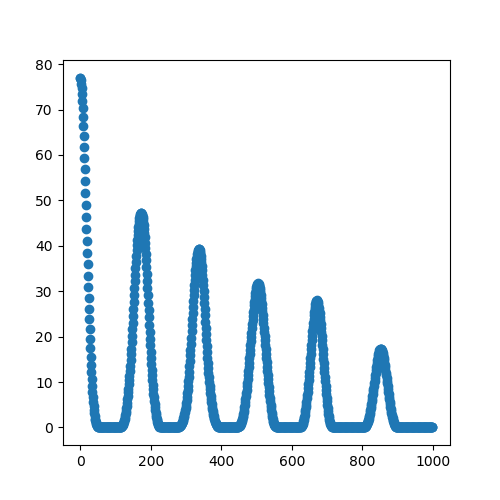

In [663]:
corr = autocorr(results[-1000:, 106])
plt.figure()
plt.scatter(np.arange(corr.size), corr)
plt.show()

In [664]:
scales = getScales(results[-1000:, 100:200])

<IPython.core.display.Javascript object>


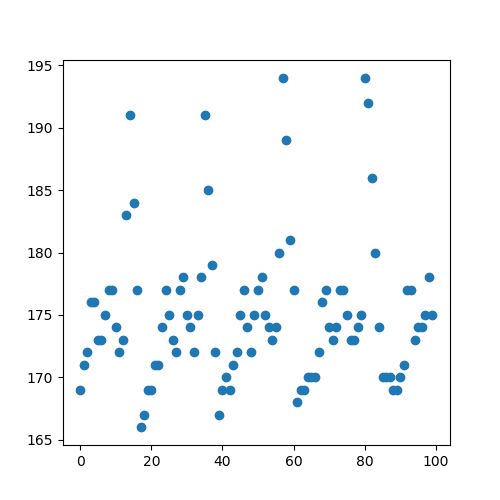

In [665]:
plt.figure()
plt.scatter(np.arange(scales.size), scales)
plt.show()

In [851]:
def compute_scales(W):
    num_gc = W.shape[1]
    scales = np.zeros(num_gc)
    for i in range(num_gc):
        f   = (W[:,i] > 1.).astype(float)
        df  = f[1:] - f[:-1]
        ind = np.where(df == -1.)[0]
        ind = ind.astype(float)

        if len(ind) > 1:
            scales[i] = np.median(ind[1:] - ind[:-1])

        else:
            scales[i] = -1.

    return scales

In [3]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [4]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.1

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return -1*np.exp(-beta * x)


def mexican_hat(x, sigma=1.):
    a = 2./(np.sqrt(3*sigma)*np.power(np.pi, 0.25))
    b = (1. - (x/(.8*sigma))**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c


# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [831]:
class GCN1D(object):
    def __init__(self,
                 numX=500,
                 inhibitionWindow=15,
                 inhibitionRadius=.5,                 
                 inhibitionStrength=50,
                 excitationWindow=5,
                 excitationCenterBlock=-1,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.005,
                 numPlaces=200,
                 placeAlpha=20,
                 placeMean=0.5,
                 placeMax=1.,
                 activityMeanAlpha=.1,
                 globalTonic=20,
                 tonicGradientX=0.,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactorP=.9,
                 negativeLearnFactorE=.9,
                 negativeLearnFactorI=.9,
                 learnFactorP=.9,
                 learnFactorE=.0,
                 initialWeightFactor=.2,
                 weightDecay=60,
                 placeWeightDecay=60,
                 excitatoryWeightDecay=60,
                 boostGradientX=1,
                 decayGradientX=1,
                 wideningFactor=0,
                 gradientType="linear",
                 envSize=1,
                 weightFunction=mexican_hat,
                 normalize=False,
                 weightNoise=None,
                ):
        
        self.activity = torch.zeros([1., 1., numX], device=device, dtype=torch.float)
        self.inhibitoryWeights=torch.randn(1, 2*inhibitionWindow+1, numX,
                        device=device, dtype=torch.float)
        
        self.directions = {"s": torch.tensor([1], device=device, dtype=torch.float),
                           "n": torch.tensor([-1], device=device, dtype=torch.float),
                          }
        
        self.excitatoryWeights = dict((k, torch.randn(1, (2*excitationWindow+1),
                                                      numX,
                        device=device, dtype=torch.float)*initialWeightFactor)
                                      for k in self.directions.keys())
        
        self.excitatoryKernel = ((2*excitationWindow+1), (2*excitationWindow+1))

        
        self.numX = numX
        self.numPlaces=numPlaces
        self.placeMean = placeMean
        self.placeMax = placeMax
        
                
        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)
        self.smoothingKernel /= size
        self.smoothingWindow = (smoothingWindow, )
        
        
        self.originalWeights = torch.tensor(self.inhibitoryWeights.cpu().numpy(), device=device, dtype=torch.float)
        if weightNoise is not None:
            mask = torch.zeros((1, 2*inhibitionWindow+1, self.numX), device=device, dtype=torch.float)
            mask.uniform_(0, weightNoise)
            self.inhibitoryWeights = mask*self.inhibitoryWeights
            
        self.longHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.activationHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.squaredHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        
        if isinstance(gradientType, str) and "linear" in gradientType.lower():
            gradient = np.linspace(1, boostGradientX, numX)
            decayGradient = np.linspace(1., decayGradientX, numX)
            tonicGradient = np.linspace(1., tonicGradientX, numX)
        elif isinstance(gradientType, str) and "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            decayBase = np.power(decayGradientX, 1./numX)
            decayGradient = np.power(decayBase, np.arange(0, numX))
            tonicBase = np.power(tonicGradientX, 1./numX)
            tonicGradient = np.power(tonicBase, np.arange(0, numX))
        elif isinstance(gradientType, float):
            upper = np.power(boostGradientX, 1./gradientType)
            gradient = np.power(np.linspace(1., upper, numX), gradientType)
            decayUpper = np.power(decayGradientX, 1./gradientType)
            decayGradient = np.power(np.linspace(1., decayUpper, numX), gradientType)
            tonicUpper = np.power(tonicGradientX, 1./gradientType)
            tonicGradient = np.power(np.linspace(1., tonicUpper, numX), gradientType)
            
        self.boostEffect = torch.tensor(
            gradient * boostEffect, device=device, dtype=torch.float)
        self.alpha = torch.tensor(
            decayGradient * boostDecay, device=device, dtype=torch.float)
        self.globalTonic = torch.tensor(
            tonicGradient * globalTonic, device=device, dtype=torch.float)
        
        
        
        
        for i in range(1+2*inhibitionWindow):
                xDist = np.abs(i - (inhibitionWindow))
                dist = max(xDist - wideningFactor, 0)**2
                if dist <= 0:
                    weight = 0
                else:
                    weight = weightFunction(dist/inhibitionRadius)*inhibitionStrength
                self.inhibitoryWeights[:, i, :] = weight
                
        self.excitationMask = torch.zeros(1, (2*excitationWindow+1), 1,
                        device=device, dtype=torch.float)

        for i in range(1+2*excitationWindow):
            dist = np.abs(i - (excitationWindow))
            if dist > excitationCenterBlock:
                self.excitationMask[:, i, :] = 1.

                
        
        self.symmetrizer = torch.zeros((1+2*inhibitionWindow,
                                        1+2*inhibitionWindow),
                                       device=device,
                                       dtype=torch.float)

        
        self.symmetrizer[inhibitionWindow, inhibitionWindow] = 1.
        for i in range(1, inhibitionWindow+1):
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow-i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow-i] = 1/2.
        
        self.dt = dt
        self.decay = decayConstant
        self.activityMeanAlpha = activityMeanAlpha
        self.placeAlpha = placeAlpha
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.negativeLearnFactorP = negativeLearnFactorP
        self.negativeLearnFactorE = negativeLearnFactorE
        self.negativeLearnFactorI = negativeLearnFactorI
        self.learnFactorP = learnFactorP
        self.learnFactorE = learnFactorE
        self.weightDecay = weightDecay
        self.placeWeightDecay = placeWeightDecay
        self.excitatoryWeightDecay = excitatoryWeightDecay
        self.normalize = normalize
        
        self.inhibitoryKernel = ((2*inhibitionWindow+1), 1)
        self.excitatoryKernel = ((2*excitationWindow+1), 1)
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.linspace(0, envSize, numPlaces), device=device, dtype=torch.float)
        self.envSize = envSize
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numPlaces),
                                         device=device, dtype=torch.float)
        
        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
        torch.min(self.placeWeights, self.zero + self.placeMax, out=self.placeWeights)
        self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, -1, keepdim=True)

        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """

        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]


        return np.asarray(envelopeX)
    
    def step(self, speed=1, vel=None, place=True, boosting=True): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX)
        else:
            self.instantaneous.fill_(0.)
            
        self.instantaneous += localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                 self.inhibitoryWeights,
                                                 self.inhibitoryKernel).view(1, 1, self.numX)
        if vel is not None:
            for k, weights in self.excitatoryWeights.items():
                direction = self.directions[k]*vel
                if direction > self.zero:
                    self.instantaneous += direction*localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                           weights,
                                                           self.excitatoryKernel).view(1, 1, self.numX)

        #self.instantaneous += conv1d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous *= self.envelope
        if boosting:
            self.instantaneous -= self.activationHistory * self.boostEffect
        self.instantaneous *= speed
        self.instantaneous = hardtanh(self.instantaneous, 0, 1000)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        #self.activationHistory += ( - self.activity)*self.dt*self.envelope
        self.activationHistory = self.alpha*self.dt*((self.instantaneous)) +\
                                 (1. - self.alpha*self.dt)*self.activationHistory
        self.squaredHistory = self.activityMeanAlpha*self.dt*((self.instantaneous**2)) +\
                                 (1. - self.activityMeanAlpha*self.dt)*self.squaredHistory
        self.longHistory = self.activityMeanAlpha*self.dt*(self.instantaneous) +\
                                 (1. - self.activityMeanAlpha*self.dt)*self.longHistory
        
        if torch.sum(self.activity**2) > 0 and self.normalize:
            self.activity = self.activity/torch.sqrt(torch.sum(self.activity**2))
        
    def simulate(self,
                 time,
                 logFreq=10,
                 startFrom=0,
                 vel=0,
                 boosting=True,
                 placeActivity=True):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                 dtype=torch.float)
     
        if placeActivity:
            distances = torch.abs(self.places - 0.5)
            torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
            self.placeActivity.fill_(torch.mean(self.placeActivity))
        else:
            self.placeActivity.fill_(0.)
        
        self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(place=placeActivity, vel=vel, boosting=boosting)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX))
                histOutput[s].copy_(self.activationHistory.view(self.numX))
                instOutput[s].copy_(self.instantaneous.view(self.numX))
                s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy(), instOutput.cpu().numpy()
    
    
    def staticLearning(self,
                       time,
                       logFreq=10,
                       startFrom=0,
                       startingActivity=None,
                       startingHistory=None,
                       symmetrize=True):
        
        if startingActivity is None:
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                     dtype=torch.float)
        else:
            self.activity = torch.tensor(startingActivity,
                                        device=device,
                                        dtype=torch.float).view((1, 1, self.numX))
        
        if startingHistory is None:  
            self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
            
        else:
            self.activationHistory =torch.tensor(startingHistory,
                                                   device=device,
                                                   dtype=torch.float).view((1, 1, self.numX))
        
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        alphaboost = 1.
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            
            if t*self.dt >= startFrom:
                self.covarianceInhibitoryUpdate()
                if symmetrize:
                    self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                self.decayInhibitoryWeights(toPattern=False)
                
                if t % logFreq == 0:
                    print("At {}".format(t*self.dt))
                    output[s].copy_(self.activity.view(self.numX))
                    histOutput[s].copy_(self.activationHistory.view(self.numX))
                    s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy()
    
    
    def decayPlaceWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*(self.placeWeights**2)/self.placeWeightDecay
       
    def decayExcitatoryWeights(self):
        """
        Only decay excitatory weights
        """
        for k, weights in self.excitatoryWeights.items():
            weights -= self.dt*(weights**2)/self.excitatoryWeightDecay


    def decayInhibitoryWeights(self, toPattern=True):
        """
        Only decay inhibitory weights
        """
        if toPattern:
            self.inhibitoryWeights -= self.dt*(self.inhibitoryWeights -
                                               self.originalWeights)/self.weightDecay
        else:
            self.inhibitoryWeights -= self.dt*self.inhibitoryWeights/self.weightDecay

    def learn(self,
              runs,
              plotting=True,
              plotInterval=100,
              speed=1,
              offsets=(0,0),
              randomSpeed=False,
              logFreq=None,
              wrap=False,
              learnInhibitory=False,
              symmetrize=True,
              learnExcitatory=False,
              learnPlace=True,
              useExcitatory=False,
              boosting=True,
              preSimulateTime=200.,
              simulateTonicBoost=1.,
              learnStart=0):
        
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.inputBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.historyBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        self.velBuffer = torch.zeros([self.stdpWindow], device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        # Space the starting points of the runs out.  This tends to improve the
        # translation-invariance of the weight profiles, and thus gives better
        # overall path integration.
        startingPoint = 0
        trajectories = []
        timings = []
        time = 0
        residTime = 0
            
        for run in range(runs):
            if randomSpeed:
                speed = (np.random.random() + 0.5)*speed
            
            if np.random.random() > 0.5:
                direction = 1
            else:
                direction = -1.

            length = self.envSize / speed

            runTimes = np.arange(0, length, self.dt)
            trajectory = np.linspace(0, direction*self.envSize, len(runTimes))
            
            #(np.sin((runTimes * np.pi * direction / (self.envSize / speed) - np.pi / 2.)) + 1) * \
            #self.envSize/2.
            trajectories.append(trajectory)
            timings.append(runTimes + time)
            time += length
            startingPoint += 1. / runs
            
        
        self.longHistory.fill_(1.)
        if logFreq is not None:
            numSteps = int(time/self.dt)
            numLogs = int(numSteps/logFreq)
            index = 0
            output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            placeOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        for run, (trajectory, times) in enumerate(zip(trajectories, timings)):
            print("Starting run {}".format(run))
            self.bufferIndex = 0
            velocity = np.diff(trajectory)/self.dt
            trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
            velocity = torch.tensor(velocity, device=device, dtype=torch.float)
            speed = torch.abs(velocity)
            distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)

            self.globalTonic *= simulateTonicBoost
            self.simulate(preSimulateTime, logFreq=100000, startFrom=10000, vel=torch.mean(velocity))
            self.globalTonic /= simulateTonicBoost
            
            for i, t in enumerate(times[:-1]):
                pos = trajectory[i] % self.envSize
                s = speed[i]/torch.mean(speed)
                vel = velocity[i]
                if wrap:
                    distances = torch.min(torch.abs(self.places - pos),
                                          torch.abs(self.envSize - self.places + pos))
                else:
                    distances = torch.abs(self.places - pos)
                    
                torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
                self.placeActivity *= s
                self.placeHistory = -self.placeAlpha*self.dt*self.placeActivity +\
                         (1. - self.placeAlpha*self.dt)*self.placeHistory
                if useExcitatory:
                    self.step(speed=s, vel=vel, boosting=boosting)
                else:
                    self.step(speed=s, boosting=boosting)
                #self.covariancePlaceUpdate()
                if i*self.dt > learnStart:
                    if learnInhibitory:
                        self.covarianceInhibitoryUpdate()
                        if symmetrize:
                            self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                        self.decayInhibitoryWeights(toPattern=True)
                    self.stdpUpdate(i,
                                    vel=vel,
                                    learnPlace=learnPlace,
                                    learnExcitatory=learnExcitatory)
                    if learnPlace:
#                         self.placeWeights += self.BCMPlaceUpdate(self.placeActivity,
#                                                            self.instantaneous,
#                                                            self.squaredHistory)
                        self.decayPlaceWeights()
                        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
                        #torch.min(self.placeWeights, self.zero + self.placeMax, out=self.placeWeights)
                        #self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, -1, keepdim=True)

                    if learnExcitatory:
                        #self.bcmExcitatoryUpdate(vel)
                        #self.adaptiveSTDPUpdate(vel, boosting=boosting)
                        for k, weights in self.excitatoryWeights.items():
                            weights = torch.max(weights, self.zero)
    #                         weights = torch.min(weights, self.zero + .5)
                            self.excitatoryWeights[k] = self.excitationMask*weights
                        self.decayExcitatoryWeights()
           
                if logFreq is not None and i % logFreq == 0:
                    output[index].copy_(self.activity.view(self.numX))
                    histOutput[index].copy_(self.activationHistory.view(self.numX))
                    instOutput[index].copy_(self.instantaneous.view(self.numX))
                    input = torch.matmul(self.placeWeights, self.placeActivity).view(self.numX)
                    input += self.globalTonic
                    if boosting:
                        input -= (self.activationHistory * self.boostEffect).view(self.numX)
                    relu_(input)
                    placeOutput[index].copy_(input)
                    index = index + 1
                    
                #self.decayWeights()
                if i % plotInterval == 0:
                    if plotting:
                        ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                        ax2.clear()
                        ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                        ax3.clear()
                        ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                        ax1.set_title(str(t))
                        fig.canvas.draw()

#             self.stdpUpdate(i+1,
#                             vel=vel,
#                             learnPlace=learnPlace,
#                             learnExcitatory=learnExcitatory,
#                             clearBuffer=True)
            
        return(output, histOutput, instOutput, placeOutput)


#     def bcmPlaceUpdate(self):
#         update = self.dt*self.learningRate*(torch.ger(self.instantaneous.view(self.numX),
#                                                     self.placeActivity) -\
#                                                torch.ger(self.longHistory.view(self.numX),
#                                                     self.placeHistory)).view(self.numX, self.numPlaces)
#         update = torch.transpose(update, 0, -1)
#         update = update.view(self.numPlaces, 1, self.numX)
#         update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
#         update = update.view(self.numPlaces, self.numX)
#         update = torch.transpose(update, 0, -1)
#         self.placeWeights += update 

        
    def BCMPlaceUpdate(self, presyn, postsyn, history):
        """
        Return: update
        """
        postsyn = postsyn.view(postsyn.numel())
        presyn = presyn.view(presyn.numel())
        history = history.view(history.numel())
        delta = torch.ger(postsyn*(postsyn - history), presyn)/(history[:, None] + 0.001)
        
        return (delta * self.learningRate * self.learnFactorP * self.dt)    
    
        
    def covariancePlaceUpdate(self):
        update = (torch.ger(self.instantaneous - self.longHistory).view(self.numX),
                                                    self.placeActivity).view(self.numX, self.numPlaces)
        self.placeWeights += self.dt*self.learningRate*self.learnFactorP*update
    
    
    def BCMRecurrentUpdate(self, kernel, presyn, postsyn, history):
        padding = tuple((k//2 for k in kernel))
        stride = (1, 1)
        unfoldedActivity = unfold(postsyn*(postsyn - history).view(1, 1, self.numX, 1),
                                  kernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        self.inhibitoryWeights += update
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)

    
    def stdpUpdate(self,
                   time,
                   vel=0,
                   clearBuffer=False,
                   learnPlace=True,
                   learnExcitatory=False,
                   adaptive=False,
                   boosting=False):
        if time < self.activityBuffer.shape[0]:
            input = torch.matmul(self.placeWeights, self.placeActivity)
            input += self.globalTonic
            if boosting:
                input += (self.activationHistory * self.boostEffect)
            relu_(input)
            self.inputBuffer[self.bufferIndex].copy_(input.view(self.numX,))
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.historyBuffer[self.bufferIndex].copy_(self.activationHistory.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel
            
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                if learnPlace:
                    update = torch.ger(self.activity.view(self.numX),
                                        self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                        self.learnFactorP
                    update -= torch.ger(self.activityBuffer[i],
                                         self.placeActivity *\
                                         self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                         self.negativeLearnFactorP *\
                                         self.learnFactorP

                    
                    self.placeWeights += update 
                
                    
        
                if learnExcitatory:
                    padding = tuple((k//2 for k in self.excitatoryKernel))
                    stride = (1, 1)
                    unfoldedActivity = unfold(self.instantaneous.view(1, 1, self.numX, 1),
                                              self.excitatoryKernel,
                                              1,
                                              padding,
                                              stride)

                    updateNeg = unfoldedActivity*\
                                self.stdpValues[t]*\
                                self.negativeLearnFactorE*\
                                (self.activityBuffer[i].view(self.numX))*self.learnFactorE

                    unfoldedActivity = unfold(self.activityBuffer[i].view(1, 1, self.numX, 1),
                                              self.excitatoryKernel,
                                              1,
                                              padding,
                                              stride)

                    updatePos = unfoldedActivity*\
                                 self.stdpValues[t]*\
                                 (self.instantaneous.view(self.numX))*self.learnFactorE    

                    for k, weights in self.excitatoryWeights.items():
                        dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
                        dBackward = torch.max(self.directions[k]*vel, self.zero)
                        weights += dForward*updatePos - dBackward*updateNeg


            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            input = torch.matmul(self.placeWeights, self.placeActivity)
            input += self.globalTonic
            if boosting:
                input -= self.activationHistory * self.boostEffect
            self.inputBuffer[self.bufferIndex].copy_(input.view(self.numX,))
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel

        if clearBuffer:
            for j in range(self.stdpWindow):
                for t in range(self.stdpWindow):
                    i = (j + self.bufferIndex - t) % self.stdpWindow
                    if learnPlace:
                        update = torch.ger(self.activityBuffer[j]/(self.longHistory + 0.001),
                                           self.placeBuffer[i]* \
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                                self.learnFactorP
                        update -= torch.ger(self.activityBuffer[i]/(self.longHistory + 0.001),
                                             self.placeBuffer[j] *\
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                              self.negativeLearnFactorP *\
                                                self.learnFactorP

                        self.placeWeights += update 

                self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
                self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
                self.historyBuffer[self.bufferIndex].copy_(self.activitionHistory.view(self.numX,))


    def covarianceInhibitoryUpdate(self):
        padding = tuple((k//2 for k in self.inhibitoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold((self.instantaneous - self.longHistory).view(1, 1, self.numX, 1),
                                  self.inhibitoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        positive = relu(update)
        negative = -relu(-update)
        self.inhibitoryWeights += positive * self.negativeLearnFactorI + negative
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)
        
        
    def covarianceExcitatoryUpdate(self, vel):
        padding = tuple((k//2 for k in self.excitatoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold((self.instantaneous - self.activationHistory).view(1, 1, self.numX, 1),
                                  self.excitatoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.activationHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt*self.learnFactorE
        for k, dir in self.directions.items():
            match = torch.max(self.directions[k]*vel, self.zero)
            positive = relu(update*match)
            negative = -relu(-update*match)
            self.excitatoryWeights[k] += self.negativeLearnFactorE*negative + positive
        return(update)
    
    
    def bcmExcitatoryUpdate(self, vel, boosting=False):
        padding = tuple((k//2 for k in self.excitatoryKernel))
        stride = (1, 1)
        input = (self.placeWeights @ self.placeActivity).view(self.numX)
        input += self.globalTonic
        if boosting:
            input -= (self.activationHistory * self.boostEffect).view(self.numX)
        relu_(input)        
        unfoldedActivity = unfold(input.view(1, 1, self.numX, 1),
                                  self.excitatoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*\
                 (self.instantaneous*(self.instantaneous + self.activationHistory))/\
                 (-self.activationHistory+ 0.001).view(self.numX)
        update = update*self.learningRate*self.dt*self.learnFactorE
        for k, dir in self.directions.items():
            match = torch.max(self.directions[k]*vel, self.zero)
            positive = relu(update*match)
            negative = -relu(-update*match)
            self.excitatoryWeights[k] += self.negativeLearnFactorE*negative + positive
        return(update)
    
    
    def adaptiveSTDPUpdate(self, vel, boosting=False):
        """
        Call STDPUpdate before this to set up the buffers properly.
        It can be called with all learning rules set to false if necessary.
        """
        for t in range(self.stdpWindow):
            i = (self.bufferIndex - t) % self.stdpWindow

            padding = tuple((k//2 for k in self.excitatoryKernel))
            stride = (1, 1)
            input = (self.placeWeights @ self.placeActivity).view(self.numX)
            input += self.globalTonic
            if boosting:
                input -= (self.activationHistory * self.boostEffect).view(self.numX)
            relu_(input)
            unfoldedActivity = unfold((input/(self.longHistory + 0.001)).\
                                      view(1, 1, self.numX, 1),
                                      self.excitatoryKernel,
                                      1,
                                      padding,
                                      stride)

            updateNeg = unfoldedActivity*\
                        self.stdpValues[t]*\
                        self.negativeLearnFactorE*\
                        (self.activityBuffer[i].view(self.numX) - self.historyBuffer[i])*self.learnFactorE

            unfoldedActivity = unfold((self.inputBuffer[i]/\
                                      (self.longHistory + 0.001)).view(1, 1, self.numX, 1),
                                      self.excitatoryKernel,
                                      1,
                                      padding,
                                      stride)

            updatePos = unfoldedActivity*\
                         self.stdpValues[t]*\
                         (self.instantaneous.view(self.numX) -\
                          self.activationHistory.view(self.numX))*self.learnFactorE    

            for k, weights in self.excitatoryWeights.items():
                dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
                dBackward = torch.max(self.directions[k]*vel, self.zero)
                weights += dForward*updatePos - dBackward*updateNeg
        



In [832]:
with open(os.getcwd() + "\\perfectmodel.pkl", "rb") as f:
    inhibGCN2 = pkl.load(f)

<IPython.core.display.Javascript object>


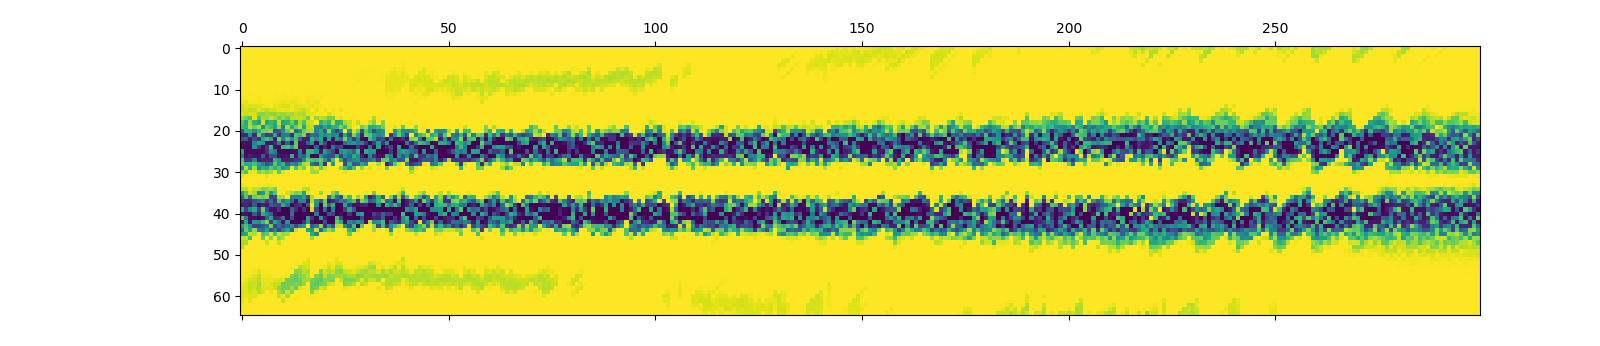

<IPython.core.display.Javascript object>


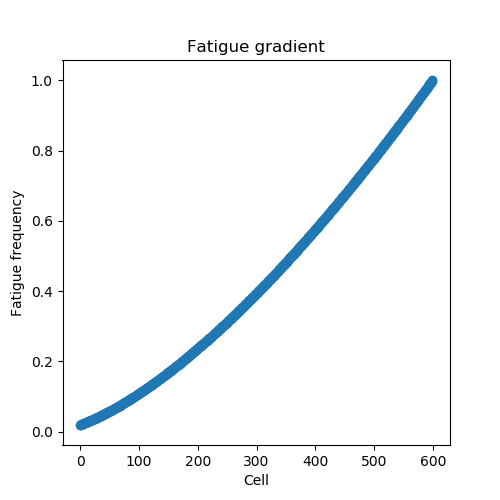

<IPython.core.display.Javascript object>


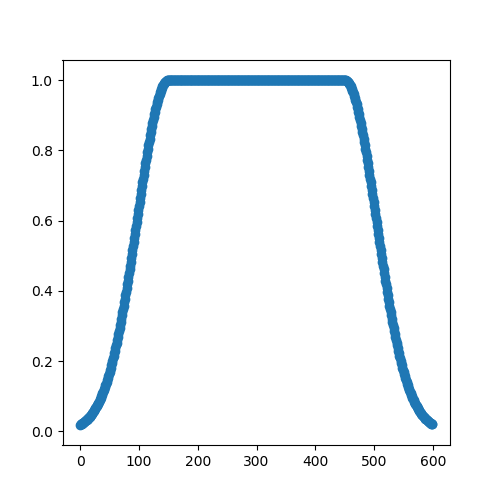

<IPython.core.display.Javascript object>


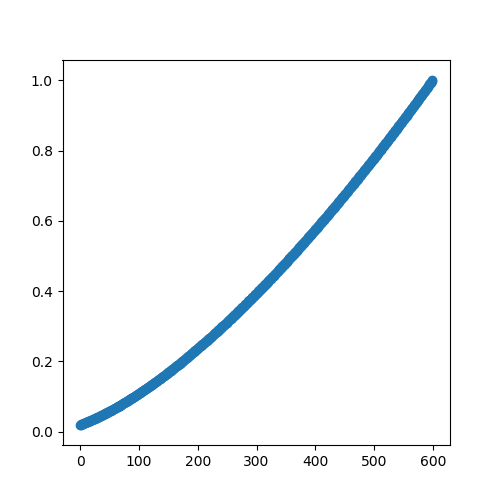

In [578]:
plt.rcParams['figure.figsize'] = [5, 5]

# hatGCN = GCN1D(500,
#             10,
#             20.,
#             5.,
#             globalTonic=.025,
#             tonicGradientX=0,
#             stdpWindow=1,
#             dt=0.01,
#             boostEffect=.5,
#             boostDecay=1.,
#             placeAlpha=100.,
#             decayConstant=.5,
#             numPlaces=500,
#             learningRate=100.,
#             initialWeightFactor=.02,
#             boostGradientX=19.5,
#             decayGradientX=0.,
#             weightDecay=500,
#             wideningFactor=2,
#             negativeLearnFactorE=.9,
#             envelopeWidth=10,
#             envelopeFactor=2,
#             sigmaLoc=.0005,
#             gradientType="exponential",
#             envSize=5.,
#             weightFunction=mexican_hat,
#             normalize=True,
#             weightNoise=2.)


inhibGCN2 = GCN1D(600,
            128,
            1.,
            500.,
            excitationWindow=10,
            excitationCenterBlock=0.,
            globalTonic=20.,
            tonicGradientX=1.,
            stdpWindow=10,
            dt=0.01,
            boostEffect=10.,
            boostDecay=.02,
            activityMeanAlpha=.1,
            placeAlpha=0.01,
            decayConstant=.03,
            numPlaces=500,
            placeMax=.5,
            placeMean=.25,
            learningRate=.01,
            initialWeightFactor=.02,
            boostGradientX=1.,
            decayGradientX=50.,
            weightDecay=3000,
            placeWeightDecay=10000,
            excitatoryWeightDecay=100000,
            wideningFactor=0.,
            negativeLearnFactorP=.0,
            negativeLearnFactorE=1.5,
            negativeLearnFactorI=2.5,
            learnFactorP=1000.,
            learnFactorE=10.,
            envelopeWidth=150,
            envelopeFactor=4.,
            sigmaLoc=.01,
            gradientType=1.5,
            envSize=5.,
            weightFunction=w_0,
            normalize=False,
            weightNoise=2.)


#GCN.randomLesions(10, 10, 5)
plt.matshow(inhibGCN.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.boostEffect.shape[0]), (inhibGCN2.alpha))
plt.xlabel("Cell")
plt.ylabel("Fatigue frequency")
plt.title("Fatigue gradient")
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.envelope.shape[0]), inhibGCN2.envelope)
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.alpha.shape[0]), inhibGCN2.alpha)
plt.show()


In [748]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN2.simulate(100,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 0.,
                                                      boosting=True)

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.53
At 9.540000000000001
At 9.55
At 9.56
At 9.57
At 9.58
At 9.59
At 9.6
At 9.61
At 9.620000000000001
At 9.63
At 9.64
At 9.65
At 9.66
At 9.67
At 9.68
At 9.69
At 9.700000000000001
At 9.71
At 9.72
At 9.73
At 9.74
At 9.75
At 9.76
At 9.77
At 9.78
At 9.790000000000001
At 9.8
At 9.81
At 9.82
At 9.83
At 9.84
At 9.85
At 9.86
At 9.870000000000001
At 9.88
At 9.89
At 9.9
At 9.91
At 9.92
At 9.93
At 9.94
At 9.950000000000001
At 9.96
At 9.97
At 9.98
At 9.99
At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 

At 17.38
At 17.39
At 17.400000000000002
At 17.41
At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.54
At 17.55
At 17.56
At 17.57
At 17.580000000000002
At 17.59
At 17.6
At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000000002
At 17.75
At 17.76
At 17.77
At 17.78
At 17.79
At 17.8
At 17.81
At 17.82
At 17.830000000000002
At 17.84
At 17.85
At 17.86
At 17.87
At 17.88
At 17.89
At 17.900000000000002
At 17.91
At 17.92
At 17.93
At 17.94
At 17.95
At 17.96
At 17.97
At 17.98
At 17.990000000000002
At 18.0
At 18.01
At 18.02
At 18.03
At 18.04
At 18.05
At 18.06
At 18.07
At 18.080000000000002
At 18.09
At 18.1
At 18.11
At 18.12
At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.3300

At 25.47
At 25.48
At 25.490000000000002
At 25.5
At 25.51
At 25.52
At 25.53
At 25.54
At 25.55
At 25.560000000000002
At 25.57
At 25.580000000000002
At 25.59
At 25.6
At 25.61
At 25.62
At 25.63
At 25.64
At 25.650000000000002
At 25.66
At 25.67
At 25.68
At 25.69
At 25.7
At 25.71
At 25.72
At 25.73
At 25.740000000000002
At 25.75
At 25.76
At 25.77
At 25.78
At 25.79
At 25.8
At 25.810000000000002
At 25.82
At 25.830000000000002
At 25.84
At 25.85
At 25.86
At 25.87
At 25.88
At 25.89
At 25.900000000000002
At 25.91
At 25.92
At 25.93
At 25.94
At 25.95
At 25.96
At 25.97
At 25.98
At 25.990000000000002
At 26.0
At 26.01
At 26.02
At 26.03
At 26.04
At 26.05
At 26.060000000000002
At 26.07
At 26.080000000000002
At 26.09
At 26.1
At 26.11
At 26.12
At 26.13
At 26.14
At 26.150000000000002
At 26.16
At 26.17
At 26.18
At 26.19
At 26.2
At 26.21
At 26.22
At 26.23
At 26.240000000000002
At 26.25
At 26.26
At 26.27
At 26.28
At 26.29
At 26.3
At 26.310000000000002
At 26.32
At 26.330000000000002
At 26.34
At 26.35
At 26.36
At 

At 33.65
At 33.660000000000004
At 33.67
At 33.68
At 33.69
At 33.7
At 33.71
At 33.72
At 33.730000000000004
At 33.74
At 33.75
At 33.76
At 33.77
At 33.78
At 33.79
At 33.8
At 33.81
At 33.82
At 33.83
At 33.84
At 33.85
At 33.86
At 33.87
At 33.88
At 33.89
At 33.9
At 33.910000000000004
At 33.92
At 33.93
At 33.94
At 33.95
At 33.96
At 33.97
At 33.980000000000004
At 33.99
At 34.0
At 34.01
At 34.02
At 34.03
At 34.04
At 34.05
At 34.06
At 34.07
At 34.08
At 34.09
At 34.1
At 34.11
At 34.12
At 34.13
At 34.14
At 34.15
At 34.160000000000004
At 34.17
At 34.18
At 34.19
At 34.2
At 34.21
At 34.22
At 34.230000000000004
At 34.24
At 34.25
At 34.26
At 34.27
At 34.28
At 34.29
At 34.300000000000004
At 34.31
At 34.32
At 34.33
At 34.34
At 34.35
At 34.36
At 34.37
At 34.38
At 34.39
At 34.4
At 34.410000000000004
At 34.42
At 34.43
At 34.44
At 34.45
At 34.46
At 34.47
At 34.480000000000004
At 34.49
At 34.5
At 34.51
At 34.52
At 34.53
At 34.54
At 34.550000000000004
At 34.56
At 34.57
At 34.58
At 34.59
At 34.6
At 34.61
At 34.

At 41.65
At 41.660000000000004
At 41.67
At 41.68
At 41.69
At 41.7
At 41.71
At 41.72
At 41.730000000000004
At 41.74
At 41.75
At 41.76
At 41.77
At 41.78
At 41.79
At 41.800000000000004
At 41.81
At 41.82
At 41.83
At 41.84
At 41.85
At 41.86
At 41.87
At 41.88
At 41.89
At 41.9
At 41.910000000000004
At 41.92
At 41.93
At 41.94
At 41.95
At 41.96
At 41.97
At 41.980000000000004
At 41.99
At 42.0
At 42.01
At 42.02
At 42.03
At 42.04
At 42.050000000000004
At 42.06
At 42.07
At 42.08
At 42.09
At 42.1
At 42.11
At 42.12
At 42.13
At 42.14
At 42.15
At 42.160000000000004
At 42.17
At 42.18
At 42.19
At 42.2
At 42.21
At 42.22
At 42.230000000000004
At 42.24
At 42.25
At 42.26
At 42.27
At 42.28
At 42.29
At 42.300000000000004
At 42.31
At 42.32
At 42.33
At 42.34
At 42.35
At 42.36
At 42.37
At 42.38
At 42.39
At 42.4
At 42.410000000000004
At 42.42
At 42.43
At 42.44
At 42.45
At 42.46
At 42.47
At 42.480000000000004
At 42.49
At 42.5
At 42.51
At 42.52
At 42.53
At 42.54
At 42.550000000000004
At 42.56
At 42.57
At 42.58
At 42

At 50.11
At 50.120000000000005
At 50.13
At 50.14
At 50.15
At 50.160000000000004
At 50.17
At 50.18
At 50.19
At 50.2
At 50.21
At 50.22
At 50.230000000000004
At 50.24
At 50.25
At 50.26
At 50.27
At 50.28
At 50.29
At 50.300000000000004
At 50.31
At 50.32
At 50.33
At 50.34
At 50.35
At 50.36
At 50.370000000000005
At 50.38
At 50.39
At 50.4
At 50.410000000000004
At 50.42
At 50.43
At 50.44
At 50.45
At 50.46
At 50.47
At 50.480000000000004
At 50.49
At 50.5
At 50.51
At 50.52
At 50.53
At 50.54
At 50.550000000000004
At 50.56
At 50.57
At 50.58
At 50.59
At 50.6
At 50.61
At 50.620000000000005
At 50.63
At 50.64
At 50.65
At 50.660000000000004
At 50.67
At 50.68
At 50.69
At 50.7
At 50.71
At 50.72
At 50.730000000000004
At 50.74
At 50.75
At 50.76
At 50.77
At 50.78
At 50.79
At 50.800000000000004
At 50.81
At 50.82
At 50.83
At 50.84
At 50.85
At 50.86
At 50.870000000000005
At 50.88
At 50.89
At 50.9
At 50.910000000000004
At 50.92
At 50.93
At 50.94
At 50.95
At 50.96
At 50.97
At 50.980000000000004
At 50.99
At 51.0
At

At 58.2
At 58.21
At 58.22
At 58.230000000000004
At 58.24
At 58.25
At 58.26
At 58.27
At 58.28
At 58.29
At 58.300000000000004
At 58.31
At 58.32
At 58.33
At 58.34
At 58.35
At 58.36
At 58.370000000000005
At 58.38
At 58.39
At 58.4
At 58.410000000000004
At 58.42
At 58.43
At 58.44
At 58.45
At 58.46
At 58.47
At 58.480000000000004
At 58.49
At 58.5
At 58.51
At 58.52
At 58.53
At 58.54
At 58.550000000000004
At 58.56
At 58.57
At 58.58
At 58.59
At 58.6
At 58.61
At 58.620000000000005
At 58.63
At 58.64
At 58.65
At 58.660000000000004
At 58.67
At 58.68
At 58.69
At 58.7
At 58.71
At 58.72
At 58.730000000000004
At 58.74
At 58.75
At 58.76
At 58.77
At 58.78
At 58.79
At 58.800000000000004
At 58.81
At 58.82
At 58.83
At 58.84
At 58.85
At 58.86
At 58.870000000000005
At 58.88
At 58.89
At 58.9
At 58.910000000000004
At 58.92
At 58.93
At 58.94
At 58.95
At 58.96
At 58.97
At 58.980000000000004
At 58.99
At 59.0
At 59.01
At 59.02
At 59.03
At 59.04
At 59.050000000000004
At 59.06
At 59.07
At 59.08
At 59.09
At 59.1
At 59.1

At 65.95
At 65.96000000000001
At 65.97
At 65.98
At 65.99
At 66.0
At 66.01
At 66.02
At 66.03
At 66.04
At 66.05
At 66.06
At 66.07000000000001
At 66.08
At 66.09
At 66.1
At 66.11
At 66.12
At 66.13
At 66.14
At 66.15
At 66.16
At 66.17
At 66.18
At 66.19
At 66.2
At 66.21000000000001
At 66.22
At 66.23
At 66.24
At 66.25
At 66.26
At 66.27
At 66.28
At 66.29
At 66.3
At 66.31
At 66.32000000000001
At 66.33
At 66.34
At 66.35
At 66.36
At 66.37
At 66.38
At 66.39
At 66.4
At 66.41
At 66.42
At 66.43
At 66.44
At 66.45
At 66.46000000000001
At 66.47
At 66.48
At 66.49
At 66.5
At 66.51
At 66.52
At 66.53
At 66.54
At 66.55
At 66.56
At 66.57000000000001
At 66.58
At 66.59
At 66.6
At 66.61
At 66.62
At 66.63
At 66.64
At 66.65
At 66.66
At 66.67
At 66.68
At 66.69
At 66.7
At 66.71000000000001
At 66.72
At 66.73
At 66.74
At 66.75
At 66.76
At 66.77
At 66.78
At 66.79
At 66.8
At 66.81
At 66.82000000000001
At 66.83
At 66.84
At 66.85
At 66.86
At 66.87
At 66.88
At 66.89
At 66.9
At 66.91
At 66.92
At 66.93
At 66.94
At 66.95
At 66

At 74.24
At 74.25
At 74.26
At 74.27
At 74.28
At 74.29
At 74.3
At 74.31
At 74.32000000000001
At 74.33
At 74.34
At 74.35000000000001
At 74.36
At 74.37
At 74.38
At 74.39
At 74.4
At 74.41
At 74.42
At 74.43
At 74.44
At 74.45
At 74.46000000000001
At 74.47
At 74.48
At 74.49
At 74.5
At 74.51
At 74.52
At 74.53
At 74.54
At 74.55
At 74.56
At 74.57000000000001
At 74.58
At 74.59
At 74.60000000000001
At 74.61
At 74.62
At 74.63
At 74.64
At 74.65
At 74.66
At 74.67
At 74.68
At 74.69
At 74.7
At 74.71000000000001
At 74.72
At 74.73
At 74.74
At 74.75
At 74.76
At 74.77
At 74.78
At 74.79
At 74.8
At 74.81
At 74.82000000000001
At 74.83
At 74.84
At 74.85000000000001
At 74.86
At 74.87
At 74.88
At 74.89
At 74.9
At 74.91
At 74.92
At 74.93
At 74.94
At 74.95
At 74.96000000000001
At 74.97
At 74.98
At 74.99
At 75.0
At 75.01
At 75.02
At 75.03
At 75.04
At 75.05
At 75.06
At 75.07000000000001
At 75.08
At 75.09
At 75.10000000000001
At 75.11
At 75.12
At 75.13
At 75.14
At 75.15
At 75.16
At 75.17
At 75.18
At 75.19
At 75.2
At 

At 82.36
At 82.37
At 82.38
At 82.39
At 82.4
At 82.41
At 82.42
At 82.43
At 82.44
At 82.45
At 82.46000000000001
At 82.47
At 82.48
At 82.49
At 82.5
At 82.51
At 82.52
At 82.53
At 82.54
At 82.55
At 82.56
At 82.57000000000001
At 82.58
At 82.59
At 82.60000000000001
At 82.61
At 82.62
At 82.63
At 82.64
At 82.65
At 82.66
At 82.67
At 82.68
At 82.69
At 82.7
At 82.71000000000001
At 82.72
At 82.73
At 82.74
At 82.75
At 82.76
At 82.77
At 82.78
At 82.79
At 82.8
At 82.81
At 82.82000000000001
At 82.83
At 82.84
At 82.85000000000001
At 82.86
At 82.87
At 82.88
At 82.89
At 82.9
At 82.91
At 82.92
At 82.93
At 82.94
At 82.95
At 82.96000000000001
At 82.97
At 82.98
At 82.99
At 83.0
At 83.01
At 83.02
At 83.03
At 83.04
At 83.05
At 83.06
At 83.07000000000001
At 83.08
At 83.09
At 83.10000000000001
At 83.11
At 83.12
At 83.13
At 83.14
At 83.15
At 83.16
At 83.17
At 83.18
At 83.19
At 83.2
At 83.21000000000001
At 83.22
At 83.23
At 83.24
At 83.25
At 83.26
At 83.27
At 83.28
At 83.29
At 83.3
At 83.31
At 83.32000000000001
At 

At 90.85000000000001
At 90.86
At 90.87
At 90.88
At 90.89
At 90.9
At 90.91
At 90.92
At 90.93
At 90.94
At 90.95
At 90.96000000000001
At 90.97
At 90.98
At 90.99
At 91.0
At 91.01
At 91.02
At 91.03
At 91.04
At 91.05
At 91.06
At 91.07000000000001
At 91.08
At 91.09
At 91.10000000000001
At 91.11
At 91.12
At 91.13
At 91.14
At 91.15
At 91.16
At 91.17
At 91.18
At 91.19
At 91.2
At 91.21000000000001
At 91.22
At 91.23
At 91.24
At 91.25
At 91.26
At 91.27
At 91.28
At 91.29
At 91.3
At 91.31
At 91.32000000000001
At 91.33
At 91.34
At 91.35000000000001
At 91.36
At 91.37
At 91.38
At 91.39
At 91.4
At 91.41
At 91.42
At 91.43
At 91.44
At 91.45
At 91.46000000000001
At 91.47
At 91.48
At 91.49
At 91.5
At 91.51
At 91.52
At 91.53
At 91.54
At 91.55
At 91.56
At 91.57000000000001
At 91.58
At 91.59
At 91.60000000000001
At 91.61
At 91.62
At 91.63
At 91.64
At 91.65
At 91.66
At 91.67
At 91.68
At 91.69
At 91.7
At 91.71000000000001
At 91.72
At 91.73
At 91.74
At 91.75
At 91.76
At 91.77
At 91.78
At 91.79
At 91.8
At 91.81
At 

At 99.44
At 99.45
At 99.46000000000001
At 99.47
At 99.48
At 99.49000000000001
At 99.5
At 99.51
At 99.52
At 99.53
At 99.54
At 99.55
At 99.56
At 99.57000000000001
At 99.58
At 99.59
At 99.60000000000001
At 99.61
At 99.62
At 99.63
At 99.64
At 99.65
At 99.66
At 99.67
At 99.68
At 99.69
At 99.7
At 99.71000000000001
At 99.72
At 99.73
At 99.74000000000001
At 99.75
At 99.76
At 99.77
At 99.78
At 99.79
At 99.8
At 99.81
At 99.82000000000001
At 99.83
At 99.84
At 99.85000000000001
At 99.86
At 99.87
At 99.88
At 99.89
At 99.9
At 99.91
At 99.92
At 99.93
At 99.94
At 99.95
At 99.96000000000001
At 99.97
At 99.98
At 99.99000000000001


<IPython.core.display.Javascript object>


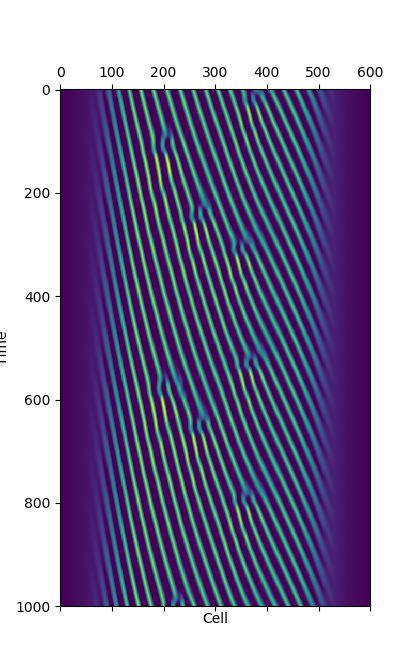

In [588]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(results[-1000:, :])
plt.xlabel("Cell")
plt.ylabel("Time")
plt.show()

In [676]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(results[100:, :]/np.mean(results[100:, :], axis=0, keepdims=True))/100.
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(activityScales.shape[0]), (activityScales))
mod = 0.25
plt.xlabel("Cell")
plt.ylabel("Preferred scale (s)")
plt.ylim((0, 1.2*max(activityScales)))
plt.show()

TypeError: mean() received an invalid combination of arguments - got (axis=int, dtype=NoneType, keepdims=bool, out=NoneType, ), but expected one of:
 * ()
 * (int dim, bool keepdim)


In [380]:
plt.rcParams['figure.figsize'] = [5, 5]
for i in range(5):
    print(i)
    inhibGCN2.staticLearning(200,
                            logFreq=100000,
                            startFrom = 10.,
                            symmetrize=True)

0
tensor(1.00000e-04 *
       1.5175, device='cuda:0')
tensor(1.00000e-04 *
       1.5192, device='cuda:0')
tensor(1.00000e-04 *
       1.5106, device='cuda:0')
tensor(1.00000e-04 *
       1.4842, device='cuda:0')
tensor(1.00000e-04 *
       1.4820, device='cuda:0')
tensor(1.00000e-04 *
       1.4513, device='cuda:0')
tensor(1.00000e-04 *
       1.4389, device='cuda:0')
tensor(1.00000e-04 *
       1.4158, device='cuda:0')
tensor(1.00000e-04 *
       1.3872, device='cuda:0')
tensor(1.00000e-04 *
       1.3704, device='cuda:0')
tensor(1.00000e-04 *
       1.3370, device='cuda:0')
tensor(1.00000e-04 *
       1.3127, device='cuda:0')
tensor(1.00000e-04 *
       1.2930, device='cuda:0')
tensor(1.00000e-04 *
       1.2570, device='cuda:0')
tensor(1.00000e-04 *
       1.2382, device='cuda:0')
tensor(1.00000e-04 *
       1.2111, device='cuda:0')
tensor(1.00000e-04 *
       1.1924, device='cuda:0')
tensor(1.00000e-04 *
       1.1701, device='cuda:0')
tensor(1.00000e-04 *
       1.1454, device='

tensor(1.00000e-05 *
       5.9008, device='cuda:0')
tensor(1.00000e-05 *
       6.0130, device='cuda:0')
tensor(1.00000e-05 *
       6.0891, device='cuda:0')
tensor(1.00000e-05 *
       6.2749, device='cuda:0')
tensor(1.00000e-05 *
       6.3932, device='cuda:0')
tensor(1.00000e-05 *
       6.4970, device='cuda:0')
tensor(1.00000e-05 *
       6.6685, device='cuda:0')
tensor(1.00000e-05 *
       6.6926, device='cuda:0')
tensor(1.00000e-05 *
       6.5810, device='cuda:0')
tensor(1.00000e-05 *
       6.6310, device='cuda:0')
tensor(1.00000e-05 *
       6.4757, device='cuda:0')
tensor(1.00000e-05 *
       6.4048, device='cuda:0')
tensor(1.00000e-05 *
       6.2170, device='cuda:0')
tensor(1.00000e-05 *
       6.0792, device='cuda:0')
tensor(1.00000e-05 *
       6.0598, device='cuda:0')
tensor(1.00000e-05 *
       5.9226, device='cuda:0')
tensor(1.00000e-05 *
       5.9802, device='cuda:0')
tensor(1.00000e-05 *
       5.9969, device='cuda:0')
tensor(1.00000e-05 *
       6.1049, device='cu

tensor(1.00000e-05 *
       2.2740, device='cuda:0')
tensor(1.00000e-05 *
       2.2371, device='cuda:0')
tensor(1.00000e-05 *
       2.2000, device='cuda:0')
tensor(1.00000e-05 *
       2.1513, device='cuda:0')
tensor(1.00000e-05 *
       2.0691, device='cuda:0')
tensor(1.00000e-05 *
       2.1861, device='cuda:0')
tensor(1.00000e-05 *
       2.0948, device='cuda:0')
tensor(1.00000e-05 *
       2.1646, device='cuda:0')
tensor(1.00000e-05 *
       2.1826, device='cuda:0')
tensor(1.00000e-05 *
       2.3874, device='cuda:0')
tensor(1.00000e-05 *
       2.3581, device='cuda:0')
tensor(1.00000e-05 *
       2.5972, device='cuda:0')
tensor(1.00000e-05 *
       2.7962, device='cuda:0')
tensor(1.00000e-05 *
       3.0092, device='cuda:0')
tensor(1.00000e-05 *
       3.0397, device='cuda:0')
tensor(1.00000e-05 *
       2.9883, device='cuda:0')
tensor(1.00000e-05 *
       3.0127, device='cuda:0')
tensor(1.00000e-05 *
       2.8855, device='cuda:0')
tensor(1.00000e-05 *
       2.7229, device='cu

tensor(1.00000e-05 *
       3.1720, device='cuda:0')
tensor(1.00000e-05 *
       3.1550, device='cuda:0')
tensor(1.00000e-05 *
       2.9657, device='cuda:0')
tensor(1.00000e-05 *
       2.7602, device='cuda:0')
tensor(1.00000e-05 *
       2.5082, device='cuda:0')
tensor(1.00000e-05 *
       2.2485, device='cuda:0')
tensor(1.00000e-05 *
       2.0278, device='cuda:0')
tensor(1.00000e-05 *
       1.7465, device='cuda:0')
tensor(1.00000e-05 *
       1.5200, device='cuda:0')
tensor(1.00000e-05 *
       1.2454, device='cuda:0')
tensor(1.00000e-05 *
       1.0681, device='cuda:0')
tensor(1.00000e-06 *
       8.2136, device='cuda:0')
tensor(1.00000e-06 *
       6.5541, device='cuda:0')
tensor(1.00000e-06 *
       4.5563, device='cuda:0')
tensor(1.00000e-06 *
       3.6296, device='cuda:0')
tensor(1.00000e-06 *
       1.8368, device='cuda:0')
tensor(1.00000e-07 *
       9.0634, device='cuda:0')
tensor(1.00000e-07 *
       4.9283, device='cuda:0')
tensor(1.00000e-07 *
       3.6594, device='cu

tensor(1.00000e-05 *
       4.7019, device='cuda:0')
tensor(1.00000e-05 *
       4.8100, device='cuda:0')
tensor(1.00000e-05 *
       4.6234, device='cuda:0')
tensor(1.00000e-05 *
       4.7050, device='cuda:0')
tensor(1.00000e-05 *
       4.6756, device='cuda:0')
tensor(1.00000e-05 *
       4.6104, device='cuda:0')
tensor(1.00000e-05 *
       4.3976, device='cuda:0')
tensor(1.00000e-05 *
       4.3879, device='cuda:0')
tensor(1.00000e-05 *
       4.2506, device='cuda:0')
tensor(1.00000e-05 *
       4.0623, device='cuda:0')
tensor(1.00000e-05 *
       3.8278, device='cuda:0')
tensor(1.00000e-05 *
       3.7372, device='cuda:0')
tensor(1.00000e-05 *
       3.5142, device='cuda:0')
tensor(1.00000e-05 *
       3.2262, device='cuda:0')
tensor(1.00000e-05 *
       3.0435, device='cuda:0')
tensor(1.00000e-05 *
       2.9331, device='cuda:0')
tensor(1.00000e-05 *
       2.7534, device='cuda:0')
tensor(1.00000e-05 *
       2.5556, device='cuda:0')
tensor(1.00000e-05 *
       2.4963, device='cu

tensor(1.00000e-06 *
       -3.8372, device='cuda:0')
tensor(1.00000e-06 *
       -3.6286, device='cuda:0')
tensor(1.00000e-06 *
       -3.4617, device='cuda:0')
tensor(1.00000e-06 *
       -3.1731, device='cuda:0')
tensor(1.00000e-06 *
       -3.0389, device='cuda:0')
tensor(1.00000e-06 *
       -2.6191, device='cuda:0')
tensor(1.00000e-06 *
       -2.3730, device='cuda:0')
tensor(1.00000e-06 *
       -1.7334, device='cuda:0')
tensor(1.00000e-06 *
       -1.2393, device='cuda:0')
tensor(1.00000e-07 *
       1.8882, device='cuda:0')
tensor(1.00000e-06 *
       1.0868, device='cuda:0')
tensor(1.00000e-06 *
       3.1789, device='cuda:0')
tensor(1.00000e-06 *
       8.3572, device='cuda:0')
tensor(1.00000e-05 *
       1.6295, device='cuda:0')
tensor(1.00000e-05 *
       2.6749, device='cuda:0')
tensor(1.00000e-05 *
       3.4304, device='cuda:0')
tensor(1.00000e-05 *
       4.1117, device='cuda:0')
tensor(1.00000e-05 *
       4.6484, device='cuda:0')
tensor(1.00000e-05 *
       4.9482, d

tensor(1.00000e-05 *
       1.1158, device='cuda:0')
tensor(1.00000e-05 *
       1.1466, device='cuda:0')
tensor(1.00000e-05 *
       1.0053, device='cuda:0')
tensor(1.00000e-06 *
       8.9989, device='cuda:0')
tensor(1.00000e-06 *
       6.7577, device='cuda:0')
tensor(1.00000e-06 *
       6.0468, device='cuda:0')
tensor(1.00000e-06 *
       3.9664, device='cuda:0')
tensor(1.00000e-06 *
       2.1251, device='cuda:0')
tensor(1.00000e-07 *
       -1.0243, device='cuda:0')
tensor(1.00000e-06 *
       -1.4522, device='cuda:0')
tensor(1.00000e-06 *
       -2.9515, device='cuda:0')
tensor(1.00000e-06 *
       -4.2744, device='cuda:0')
tensor(1.00000e-06 *
       -5.4854, device='cuda:0')
tensor(1.00000e-06 *
       -6.6175, device='cuda:0')
tensor(1.00000e-06 *
       -7.2368, device='cuda:0')
tensor(1.00000e-06 *
       -8.1258, device='cuda:0')
tensor(1.00000e-06 *
       -8.5913, device='cuda:0')
tensor(1.00000e-06 *
       -8.7698, device='cuda:0')
tensor(1.00000e-06 *
       -9.2194,

tensor(1.00000e-06 *
       -6.4518, device='cuda:0')
tensor(1.00000e-06 *
       -6.4314, device='cuda:0')
tensor(1.00000e-06 *
       -6.2940, device='cuda:0')
tensor(1.00000e-06 *
       -6.1137, device='cuda:0')
tensor(1.00000e-06 *
       -5.6650, device='cuda:0')
tensor(1.00000e-06 *
       -5.1959, device='cuda:0')
tensor(1.00000e-06 *
       -4.7835, device='cuda:0')
tensor(1.00000e-06 *
       -4.3764, device='cuda:0')
tensor(1.00000e-06 *
       -3.8122, device='cuda:0')
tensor(1.00000e-06 *
       -3.1821, device='cuda:0')
tensor(1.00000e-06 *
       -2.5154, device='cuda:0')
tensor(1.00000e-06 *
       -2.2815, device='cuda:0')
tensor(1.00000e-06 *
       -2.1179, device='cuda:0')
tensor(1.00000e-06 *
       -2.0141, device='cuda:0')
tensor(1.00000e-06 *
       -1.8123, device='cuda:0')
tensor(1.00000e-08 *
       7.6498, device='cuda:0')
tensor(1.00000e-06 *
       2.7693, device='cuda:0')
tensor(1.00000e-06 *
       9.0193, device='cuda:0')
tensor(1.00000e-05 *
       1.4

tensor(1.00000e-06 *
       3.0193, device='cuda:0')
tensor(1.00000e-06 *
       3.3865, device='cuda:0')
tensor(1.00000e-06 *
       3.2277, device='cuda:0')
tensor(1.00000e-06 *
       4.0010, device='cuda:0')
tensor(1.00000e-06 *
       3.5613, device='cuda:0')
tensor(1.00000e-06 *
       3.7606, device='cuda:0')
tensor(1.00000e-06 *
       3.3148, device='cuda:0')
tensor(1.00000e-06 *
       2.8863, device='cuda:0')
tensor(1.00000e-07 *
       7.9356, device='cuda:0')
tensor(1.00000e-07 *
       5.6511, device='cuda:0')
tensor(1.00000e-07 *
       -6.7927, device='cuda:0')
tensor(1.00000e-06 *
       -2.1562, device='cuda:0')
tensor(1.00000e-06 *
       -3.7163, device='cuda:0')
tensor(1.00000e-06 *
       -5.0744, device='cuda:0')
tensor(1.00000e-06 *
       -6.0646, device='cuda:0')
tensor(1.00000e-06 *
       -7.0652, device='cuda:0')
tensor(1.00000e-06 *
       -8.2059, device='cuda:0')
tensor(1.00000e-06 *
       -8.4598, device='cuda:0')
tensor(1.00000e-06 *
       -9.2819, d

tensor(1.00000e-06 *
       -4.8299, device='cuda:0')
tensor(1.00000e-06 *
       -3.9668, device='cuda:0')
tensor(1.00000e-06 *
       -3.0904, device='cuda:0')
tensor(1.00000e-06 *
       -2.4388, device='cuda:0')
tensor(1.00000e-06 *
       -1.8223, device='cuda:0')
tensor(1.00000e-06 *
       -1.4595, device='cuda:0')
tensor(1.00000e-06 *
       -1.3871, device='cuda:0')
tensor(1.00000e-06 *
       -1.6171, device='cuda:0')
tensor(1.00000e-06 *
       -2.6870, device='cuda:0')
tensor(1.00000e-06 *
       -3.1244, device='cuda:0')
tensor(1.00000e-06 *
       -2.5816, device='cuda:0')
tensor(1.00000e-06 *
       -1.0925, device='cuda:0')
tensor(1.00000e-06 *
       2.5875, device='cuda:0')
tensor(1.00000e-06 *
       7.2020, device='cuda:0')
tensor(1.00000e-05 *
       1.2172, device='cuda:0')
tensor(1.00000e-05 *
       1.5982, device='cuda:0')
tensor(1.00000e-05 *
       1.8845, device='cuda:0')
tensor(1.00000e-05 *
       2.1198, device='cuda:0')
tensor(1.00000e-05 *
       2.3325

tensor(1.00000e-06 *
       -1.1709, device='cuda:0')
tensor(1.00000e-06 *
       -1.5815, device='cuda:0')
tensor(1.00000e-06 *
       -1.1682, device='cuda:0')
tensor(1.00000e-06 *
       -1.2356, device='cuda:0')
tensor(1.00000e-06 *
       -1.3460, device='cuda:0')
tensor(1.00000e-06 *
       -2.1163, device='cuda:0')
tensor(1.00000e-06 *
       -3.1121, device='cuda:0')
tensor(1.00000e-06 *
       -4.1509, device='cuda:0')
tensor(1.00000e-06 *
       -4.4478, device='cuda:0')
tensor(1.00000e-06 *
       -6.0474, device='cuda:0')
tensor(1.00000e-06 *
       -7.2525, device='cuda:0')
tensor(1.00000e-06 *
       -8.4713, device='cuda:0')
tensor(1.00000e-06 *
       -9.0769, device='cuda:0')
tensor(1.00000e-06 *
       -9.6924, device='cuda:0')
tensor(1.00000e-05 *
       -1.0313, device='cuda:0')
tensor(1.00000e-05 *
       -1.0648, device='cuda:0')
tensor(1.00000e-05 *
       -1.0928, device='cuda:0')
tensor(1.00000e-05 *
       -1.1138, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-07 *
       3.7686, device='cuda:0')
tensor(1.00000e-08 *
       -3.3762, device='cuda:0')
tensor(1.00000e-06 *
       -1.7703, device='cuda:0')
tensor(1.00000e-06 *
       -2.8924, device='cuda:0')
tensor(1.00000e-06 *
       -3.9088, device='cuda:0')
tensor(1.00000e-06 *
       -3.8798, device='cuda:0')
tensor(1.00000e-06 *
       -2.8477, device='cuda:0')
tensor(1.00000e-08 *
       -6.3438, device='cuda:0')
tensor(1.00000e-06 *
       4.0785, device='cuda:0')
tensor(1.00000e-06 *
       7.6886, device='cuda:0')
tensor(1.00000e-05 *
       1.0548, device='cuda:0')
tensor(1.00000e-05 *
       1.3097, device='cuda:0')
tensor(1.00000e-05 *
       1.5816, device='cuda:0')
tensor(1.00000e-05 *
       1.5883, device='cuda:0')
tensor(1.00000e-05 *
       1.5757, device='cuda:0')
tensor(1.00000e-05 *
       1.4905, device='cuda:0')
tensor(1.00000e-05 *
       1.4519, device='cuda:0')
tensor(1.00000e-05 *
       1.3038, device='cuda:0')
tensor(1.00000e-05 *
       1.2504, dev

tensor(1.00000e-05 *
       -1.1738, device='cuda:0')
tensor(1.00000e-05 *
       -1.1372, device='cuda:0')
tensor(1.00000e-05 *
       -1.0809, device='cuda:0')
tensor(1.00000e-05 *
       -1.0519, device='cuda:0')
tensor(1.00000e-05 *
       -1.0129, device='cuda:0')
tensor(1.00000e-06 *
       -9.7001, device='cuda:0')
tensor(1.00000e-06 *
       -9.2242, device='cuda:0')
tensor(1.00000e-06 *
       -8.8935, device='cuda:0')
tensor(1.00000e-06 *
       -8.8846, device='cuda:0')
tensor(1.00000e-06 *
       -8.8474, device='cuda:0')
tensor(1.00000e-06 *
       -9.1570, device='cuda:0')
tensor(1.00000e-06 *
       -9.2194, device='cuda:0')
tensor(1.00000e-06 *
       -9.6425, device='cuda:0')
tensor(1.00000e-05 *
       -1.0049, device='cuda:0')
tensor(1.00000e-05 *
       -1.0528, device='cuda:0')
tensor(1.00000e-05 *
       -1.0682, device='cuda:0')
tensor(1.00000e-05 *
       -1.0784, device='cuda:0')
tensor(1.00000e-05 *
       -1.0761, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-05 *
       1.0115, device='cuda:0')
tensor(1.00000e-06 *
       9.7646, device='cuda:0')
tensor(1.00000e-06 *
       8.1696, device='cuda:0')
tensor(1.00000e-06 *
       7.1336, device='cuda:0')
tensor(1.00000e-06 *
       5.3588, device='cuda:0')
tensor(1.00000e-06 *
       4.6434, device='cuda:0')
tensor(1.00000e-06 *
       3.8812, device='cuda:0')
tensor(1.00000e-06 *
       3.7045, device='cuda:0')
tensor(1.00000e-06 *
       2.6915, device='cuda:0')
tensor(1.00000e-06 *
       3.6776, device='cuda:0')
tensor(1.00000e-06 *
       3.2686, device='cuda:0')
tensor(1.00000e-06 *
       3.4854, device='cuda:0')
tensor(1.00000e-06 *
       2.8333, device='cuda:0')
tensor(1.00000e-06 *
       4.3431, device='cuda:0')
tensor(1.00000e-06 *
       3.6065, device='cuda:0')
tensor(1.00000e-06 *
       3.1514, device='cuda:0')
tensor(1.00000e-06 *
       2.8995, device='cuda:0')
tensor(1.00000e-06 *
       2.9388, device='cuda:0')
tensor(1.00000e-06 *
       1.7308, device='cu

tensor(1.00000e-06 *
       -9.2943, device='cuda:0')
tensor(1.00000e-06 *
       -9.5802, device='cuda:0')
tensor(1.00000e-06 *
       -9.3911, device='cuda:0')
tensor(1.00000e-06 *
       -9.2988, device='cuda:0')
tensor(1.00000e-06 *
       -8.5306, device='cuda:0')
tensor(1.00000e-06 *
       -8.0080, device='cuda:0')
tensor(1.00000e-06 *
       -7.9303, device='cuda:0')
tensor(1.00000e-06 *
       -7.2454, device='cuda:0')
tensor(1.00000e-06 *
       -6.9324, device='cuda:0')
tensor(1.00000e-06 *
       -6.9282, device='cuda:0')
tensor(1.00000e-06 *
       -7.0892, device='cuda:0')
tensor(1.00000e-06 *
       -7.4904, device='cuda:0')
tensor(1.00000e-06 *
       -8.7767, device='cuda:0')
tensor(1.00000e-06 *
       -9.7550, device='cuda:0')
tensor(1.00000e-05 *
       -1.0155, device='cuda:0')
tensor(1.00000e-05 *
       -1.0494, device='cuda:0')
tensor(1.00000e-05 *
       -1.0546, device='cuda:0')
tensor(1.00000e-05 *
       -1.0196, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       1.5556, device='cuda:0')
tensor(1.00000e-06 *
       1.2677, device='cuda:0')
tensor(1.00000e-06 *
       1.1228, device='cuda:0')
tensor(1.00000e-07 *
       9.7353, device='cuda:0')
tensor(1.00000e-08 *
       -3.0939, device='cuda:0')
tensor(1.00000e-07 *
       -1.9580, device='cuda:0')
tensor(1.00000e-07 *
       -7.2527, device='cuda:0')
tensor(1.00000e-06 *
       -1.7494, device='cuda:0')
tensor(1.00000e-06 *
       -2.4317, device='cuda:0')
tensor(1.00000e-06 *
       -3.5086, device='cuda:0')
tensor(1.00000e-06 *
       -3.7707, device='cuda:0')
tensor(1.00000e-06 *
       -4.3398, device='cuda:0')
tensor(1.00000e-06 *
       -4.9690, device='cuda:0')
tensor(1.00000e-06 *
       -5.5308, device='cuda:0')
tensor(1.00000e-06 *
       -5.8420, device='cuda:0')
tensor(1.00000e-06 *
       -5.9913, device='cuda:0')
tensor(1.00000e-06 *
       -6.2094, device='cuda:0')
tensor(1.00000e-06 *
       -6.2002, device='cuda:0')
tensor(1.00000e-06 *
       -6.6

tensor(1.00000e-06 *
       -7.9551, device='cuda:0')
tensor(1.00000e-06 *
       -8.9861, device='cuda:0')
tensor(1.00000e-05 *
       -1.0091, device='cuda:0')
tensor(1.00000e-05 *
       -1.0742, device='cuda:0')
tensor(1.00000e-05 *
       -1.0601, device='cuda:0')
tensor(1.00000e-05 *
       -1.0401, device='cuda:0')
tensor(1.00000e-06 *
       -9.7972, device='cuda:0')
tensor(1.00000e-06 *
       -9.4390, device='cuda:0')
tensor(1.00000e-06 *
       -9.1677, device='cuda:0')
tensor(1.00000e-06 *
       -8.3237, device='cuda:0')
tensor(1.00000e-06 *
       -7.3010, device='cuda:0')
tensor(1.00000e-06 *
       -5.9820, device='cuda:0')
tensor(1.00000e-06 *
       -4.0129, device='cuda:0')
tensor(1.00000e-06 *
       -2.4077, device='cuda:0')
tensor(1.00000e-07 *
       -7.2494, device='cuda:0')
tensor(1.00000e-07 *
       9.3846, device='cuda:0')
tensor(1.00000e-06 *
       2.7002, device='cuda:0')
tensor(1.00000e-06 *
       4.4854, device='cuda:0')
tensor(1.00000e-06 *
       6.1

tensor(1.00000e-06 *
       -6.7791, device='cuda:0')
tensor(1.00000e-06 *
       -7.2242, device='cuda:0')
tensor(1.00000e-06 *
       -7.2568, device='cuda:0')
tensor(1.00000e-06 *
       -7.5813, device='cuda:0')
tensor(1.00000e-06 *
       -7.5922, device='cuda:0')
tensor(1.00000e-06 *
       -8.0646, device='cuda:0')
tensor(1.00000e-06 *
       -8.5748, device='cuda:0')
tensor(1.00000e-06 *
       -9.3921, device='cuda:0')
tensor(1.00000e-05 *
       -1.0082, device='cuda:0')
tensor(1.00000e-05 *
       -1.0582, device='cuda:0')
tensor(1.00000e-05 *
       -1.1243, device='cuda:0')
tensor(1.00000e-05 *
       -1.2042, device='cuda:0')
tensor(1.00000e-05 *
       -1.2551, device='cuda:0')
tensor(1.00000e-05 *
       -1.2893, device='cuda:0')
tensor(1.00000e-05 *
       -1.3103, device='cuda:0')
tensor(1.00000e-05 *
       -1.3191, device='cuda:0')
tensor(1.00000e-05 *
       -1.3265, device='cuda:0')
tensor(1.00000e-05 *
       -1.3294, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -6.6499, device='cuda:0')
tensor(1.00000e-06 *
       -4.4769, device='cuda:0')
tensor(1.00000e-06 *
       -2.7818, device='cuda:0')
tensor(1.00000e-07 *
       -5.5753, device='cuda:0')
tensor(1.00000e-06 *
       1.1064, device='cuda:0')
tensor(1.00000e-06 *
       3.2272, device='cuda:0')
tensor(1.00000e-06 *
       4.9442, device='cuda:0')
tensor(1.00000e-06 *
       7.0677, device='cuda:0')
tensor(1.00000e-06 *
       8.0252, device='cuda:0')
tensor(1.00000e-06 *
       9.0469, device='cuda:0')
tensor(1.00000e-06 *
       7.4286, device='cuda:0')
tensor(1.00000e-06 *
       6.2964, device='cuda:0')
tensor(1.00000e-06 *
       4.1546, device='cuda:0')
tensor(1.00000e-06 *
       1.9879, device='cuda:0')
tensor(1.00000e-07 *
       -6.4639, device='cuda:0')
tensor(1.00000e-06 *
       -2.3605, device='cuda:0')
tensor(1.00000e-06 *
       -4.5418, device='cuda:0')
tensor(1.00000e-06 *
       -5.9327, device='cuda:0')
tensor(1.00000e-06 *
       -6.4194, d

tensor(1.00000e-06 *
       -9.9258, device='cuda:0')
tensor(1.00000e-05 *
       -1.0501, device='cuda:0')
tensor(1.00000e-05 *
       -1.1109, device='cuda:0')
tensor(1.00000e-05 *
       -1.1575, device='cuda:0')
tensor(1.00000e-05 *
       -1.2120, device='cuda:0')
tensor(1.00000e-05 *
       -1.2499, device='cuda:0')
tensor(1.00000e-05 *
       -1.2677, device='cuda:0')
tensor(1.00000e-05 *
       -1.3045, device='cuda:0')
tensor(1.00000e-05 *
       -1.3151, device='cuda:0')
tensor(1.00000e-05 *
       -1.3201, device='cuda:0')
tensor(1.00000e-05 *
       -1.3195, device='cuda:0')
tensor(1.00000e-05 *
       -1.2877, device='cuda:0')
tensor(1.00000e-05 *
       -1.2695, device='cuda:0')
tensor(1.00000e-05 *
       -1.2540, device='cuda:0')
tensor(1.00000e-05 *
       -1.2316, device='cuda:0')
tensor(1.00000e-05 *
       -1.1831, device='cuda:0')
tensor(1.00000e-05 *
       -1.1298, device='cuda:0')
tensor(1.00000e-05 *
       -1.1223, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       5.7142, device='cuda:0')
tensor(1.00000e-06 *
       7.8063, device='cuda:0')
tensor(1.00000e-06 *
       8.9413, device='cuda:0')
tensor(1.00000e-05 *
       1.0225, device='cuda:0')
tensor(1.00000e-05 *
       1.0004, device='cuda:0')
tensor(1.00000e-06 *
       8.4649, device='cuda:0')
tensor(1.00000e-06 *
       6.5274, device='cuda:0')
tensor(1.00000e-06 *
       4.1066, device='cuda:0')
tensor(1.00000e-06 *
       2.0095, device='cuda:0')
tensor(1.00000e-07 *
       -6.8557, device='cuda:0')
tensor(1.00000e-06 *
       -2.4690, device='cuda:0')
tensor(1.00000e-06 *
       -5.1341, device='cuda:0')
tensor(1.00000e-06 *
       -6.5463, device='cuda:0')
tensor(1.00000e-06 *
       -6.9939, device='cuda:0')
tensor(1.00000e-06 *
       -5.8158, device='cuda:0')
tensor(1.00000e-06 *
       -2.7812, device='cuda:0')
tensor(1.00000e-07 *
       -4.7277, device='cuda:0')
tensor(1.00000e-06 *
       3.0141, device='cuda:0')
tensor(1.00000e-06 *
       4.5327, de

tensor(1.00000e-05 *
       -1.1211, device='cuda:0')
tensor(1.00000e-05 *
       -1.1574, device='cuda:0')
tensor(1.00000e-05 *
       -1.2014, device='cuda:0')
tensor(1.00000e-05 *
       -1.2457, device='cuda:0')
tensor(1.00000e-05 *
       -1.2557, device='cuda:0')
tensor(1.00000e-05 *
       -1.2932, device='cuda:0')
tensor(1.00000e-05 *
       -1.3081, device='cuda:0')
tensor(1.00000e-05 *
       -1.3143, device='cuda:0')
tensor(1.00000e-05 *
       -1.3125, device='cuda:0')
tensor(1.00000e-05 *
       -1.2794, device='cuda:0')
tensor(1.00000e-05 *
       -1.2589, device='cuda:0')
tensor(1.00000e-05 *
       -1.2391, device='cuda:0')
tensor(1.00000e-05 *
       -1.2177, device='cuda:0')
tensor(1.00000e-05 *
       -1.1666, device='cuda:0')
tensor(1.00000e-05 *
       -1.1040, device='cuda:0')
tensor(1.00000e-05 *
       -1.0965, device='cuda:0')
tensor(1.00000e-05 *
       -1.0580, device='cuda:0')
tensor(1.00000e-05 *
       -1.0605, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       7.1120, device='cuda:0')
tensor(1.00000e-06 *
       8.7147, device='cuda:0')
tensor(1.00000e-05 *
       1.0151, device='cuda:0')
tensor(1.00000e-05 *
       1.1274, device='cuda:0')
tensor(1.00000e-05 *
       1.1141, device='cuda:0')
tensor(1.00000e-05 *
       1.0141, device='cuda:0')
tensor(1.00000e-06 *
       7.7952, device='cuda:0')
tensor(1.00000e-06 *
       5.7429, device='cuda:0')
tensor(1.00000e-06 *
       3.5315, device='cuda:0')
tensor(1.00000e-07 *
       9.1602, device='cuda:0')
tensor(1.00000e-06 *
       -1.0399, device='cuda:0')
tensor(1.00000e-06 *
       -4.2393, device='cuda:0')
tensor(1.00000e-06 *
       -5.9414, device='cuda:0')
tensor(1.00000e-06 *
       -7.7432, device='cuda:0')
tensor(1.00000e-06 *
       -7.4971, device='cuda:0')
tensor(1.00000e-06 *
       -5.0812, device='cuda:0')
tensor(1.00000e-06 *
       -2.3765, device='cuda:0')
tensor(1.00000e-07 *
       3.1760, device='cuda:0')
tensor(1.00000e-06 *
       2.9826, dev

tensor(1.00000e-05 *
       -1.1159, device='cuda:0')
tensor(1.00000e-05 *
       -1.1657, device='cuda:0')
tensor(1.00000e-05 *
       -1.2000, device='cuda:0')
tensor(1.00000e-05 *
       -1.2477, device='cuda:0')
tensor(1.00000e-05 *
       -1.2430, device='cuda:0')
tensor(1.00000e-05 *
       -1.2856, device='cuda:0')
tensor(1.00000e-05 *
       -1.3016, device='cuda:0')
tensor(1.00000e-05 *
       -1.3076, device='cuda:0')
tensor(1.00000e-05 *
       -1.3057, device='cuda:0')
tensor(1.00000e-05 *
       -1.2722, device='cuda:0')
tensor(1.00000e-05 *
       -1.2493, device='cuda:0')
tensor(1.00000e-05 *
       -1.2241, device='cuda:0')
tensor(1.00000e-05 *
       -1.1971, device='cuda:0')
tensor(1.00000e-05 *
       -1.1338, device='cuda:0')
tensor(1.00000e-05 *
       -1.0853, device='cuda:0')
tensor(1.00000e-05 *
       -1.0739, device='cuda:0')
tensor(1.00000e-05 *
       -1.0270, device='cuda:0')
tensor(1.00000e-05 *
       -1.0381, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-05 *
       1.0926, device='cuda:0')
tensor(1.00000e-05 *
       1.2519, device='cuda:0')
tensor(1.00000e-05 *
       1.1588, device='cuda:0')
tensor(1.00000e-05 *
       1.1630, device='cuda:0')
tensor(1.00000e-06 *
       8.1223, device='cuda:0')
tensor(1.00000e-06 *
       6.5255, device='cuda:0')
tensor(1.00000e-06 *
       3.6853, device='cuda:0')
tensor(1.00000e-06 *
       2.1269, device='cuda:0')
tensor(1.00000e-07 *
       -6.7715, device='cuda:0')
tensor(1.00000e-06 *
       -3.4690, device='cuda:0')
tensor(1.00000e-06 *
       -5.7403, device='cuda:0')
tensor(1.00000e-06 *
       -8.0348, device='cuda:0')
tensor(1.00000e-06 *
       -8.3220, device='cuda:0')
tensor(1.00000e-06 *
       -6.6830, device='cuda:0')
tensor(1.00000e-06 *
       -3.4328, device='cuda:0')
tensor(1.00000e-06 *
       -1.1145, device='cuda:0')
tensor(1.00000e-06 *
       1.7452, device='cuda:0')
tensor(1.00000e-06 *
       4.5566, device='cuda:0')
tensor(1.00000e-06 *
       5.5798, de

tensor(1.00000e-05 *
       -1.2094, device='cuda:0')
tensor(1.00000e-05 *
       -1.2468, device='cuda:0')
tensor(1.00000e-05 *
       -1.2419, device='cuda:0')
tensor(1.00000e-05 *
       -1.2869, device='cuda:0')
tensor(1.00000e-05 *
       -1.2943, device='cuda:0')
tensor(1.00000e-05 *
       -1.3104, device='cuda:0')
tensor(1.00000e-05 *
       -1.2937, device='cuda:0')
tensor(1.00000e-05 *
       -1.2638, device='cuda:0')
tensor(1.00000e-05 *
       -1.2434, device='cuda:0')
tensor(1.00000e-05 *
       -1.1996, device='cuda:0')
tensor(1.00000e-05 *
       -1.1684, device='cuda:0')
tensor(1.00000e-05 *
       -1.0901, device='cuda:0')
tensor(1.00000e-05 *
       -1.0614, device='cuda:0')
tensor(1.00000e-05 *
       -1.0329, device='cuda:0')
tensor(1.00000e-05 *
       -1.0070, device='cuda:0')
tensor(1.00000e-05 *
       -1.0059, device='cuda:0')
tensor(1.00000e-06 *
       -9.5004, device='cuda:0')
tensor(1.00000e-06 *
       -9.6728, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-05 *
       1.0967, device='cuda:0')
tensor(1.00000e-05 *
       1.2435, device='cuda:0')
tensor(1.00000e-05 *
       1.3051, device='cuda:0')
tensor(1.00000e-05 *
       1.2858, device='cuda:0')
tensor(1.00000e-05 *
       1.1758, device='cuda:0')
tensor(1.00000e-06 *
       7.7624, device='cuda:0')
tensor(1.00000e-06 *
       6.9305, device='cuda:0')
tensor(1.00000e-06 *
       3.0211, device='cuda:0')
tensor(1.00000e-06 *
       2.7669, device='cuda:0')
tensor(1.00000e-06 *
       -1.3803, device='cuda:0')
tensor(1.00000e-06 *
       -3.2007, device='cuda:0')
tensor(1.00000e-06 *
       -6.4526, device='cuda:0')
tensor(1.00000e-06 *
       -8.5576, device='cuda:0')
tensor(1.00000e-06 *
       -8.8419, device='cuda:0')
tensor(1.00000e-06 *
       -7.0742, device='cuda:0')
tensor(1.00000e-06 *
       -3.5594, device='cuda:0')
tensor(1.00000e-06 *
       -1.9861, device='cuda:0')
tensor(1.00000e-06 *
       2.4485, device='cuda:0')
tensor(1.00000e-06 *
       4.4854, de

tensor(1.00000e-06 *
       -9.8111, device='cuda:0')
tensor(1.00000e-05 *
       -1.0337, device='cuda:0')
tensor(1.00000e-05 *
       -1.0690, device='cuda:0')
tensor(1.00000e-05 *
       -1.1102, device='cuda:0')
tensor(1.00000e-05 *
       -1.1752, device='cuda:0')
tensor(1.00000e-05 *
       -1.1974, device='cuda:0')
tensor(1.00000e-05 *
       -1.2318, device='cuda:0')
tensor(1.00000e-05 *
       -1.2402, device='cuda:0')
tensor(1.00000e-05 *
       -1.2635, device='cuda:0')
tensor(1.00000e-05 *
       -1.2869, device='cuda:0')
tensor(1.00000e-05 *
       -1.2946, device='cuda:0')
tensor(1.00000e-05 *
       -1.3006, device='cuda:0')
tensor(1.00000e-05 *
       -1.2791, device='cuda:0')
tensor(1.00000e-05 *
       -1.2524, device='cuda:0')
tensor(1.00000e-05 *
       -1.2159, device='cuda:0')
tensor(1.00000e-05 *
       -1.1553, device='cuda:0')
tensor(1.00000e-05 *
       -1.1038, device='cuda:0')
tensor(1.00000e-05 *
       -1.0459, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -6.1059, device='cuda:0')
tensor(1.00000e-06 *
       -3.5669, device='cuda:0')
tensor(1.00000e-08 *
       -6.3962, device='cuda:0')
tensor(1.00000e-06 *
       2.3436, device='cuda:0')
tensor(1.00000e-06 *
       5.4371, device='cuda:0')
tensor(1.00000e-06 *
       7.4124, device='cuda:0')
tensor(1.00000e-06 *
       8.7944, device='cuda:0')
tensor(1.00000e-05 *
       1.1032, device='cuda:0')
tensor(1.00000e-05 *
       1.2755, device='cuda:0')
tensor(1.00000e-05 *
       1.3624, device='cuda:0')
tensor(1.00000e-05 *
       1.3416, device='cuda:0')
tensor(1.00000e-05 *
       1.3397, device='cuda:0')
tensor(1.00000e-06 *
       9.3151, device='cuda:0')
tensor(1.00000e-06 *
       7.9750, device='cuda:0')
tensor(1.00000e-06 *
       4.2106, device='cuda:0')
tensor(1.00000e-06 *
       3.8309, device='cuda:0')
tensor(1.00000e-07 *
       3.9816, device='cuda:0')
tensor(1.00000e-06 *
       -1.7901, device='cuda:0')
tensor(1.00000e-06 *
       -4.8771, devic

tensor(1.00000e-06 *
       -6.5449, device='cuda:0')
tensor(1.00000e-06 *
       -6.9396, device='cuda:0')
tensor(1.00000e-06 *
       -7.1808, device='cuda:0')
tensor(1.00000e-06 *
       -6.7667, device='cuda:0')
tensor(1.00000e-06 *
       -6.8349, device='cuda:0')
tensor(1.00000e-06 *
       -6.8813, device='cuda:0')
tensor(1.00000e-06 *
       -7.1036, device='cuda:0')
tensor(1.00000e-06 *
       -7.0527, device='cuda:0')
tensor(1.00000e-06 *
       -7.2699, device='cuda:0')
tensor(1.00000e-06 *
       -7.7271, device='cuda:0')
tensor(1.00000e-06 *
       -8.8100, device='cuda:0')
tensor(1.00000e-06 *
       -9.7576, device='cuda:0')
tensor(1.00000e-05 *
       -1.0279, device='cuda:0')
tensor(1.00000e-05 *
       -1.0685, device='cuda:0')
tensor(1.00000e-05 *
       -1.1053, device='cuda:0')
tensor(1.00000e-05 *
       -1.1768, device='cuda:0')
tensor(1.00000e-05 *
       -1.1963, device='cuda:0')
tensor(1.00000e-05 *
       -1.2226, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       9.0037, device='cuda:0')
tensor(1.00000e-06 *
       1.5653, device='cuda:0')
tensor(1.00000e-06 *
       -2.6578, device='cuda:0')
tensor(1.00000e-06 *
       -5.6286, device='cuda:0')
tensor(1.00000e-06 *
       -7.7181, device='cuda:0')
tensor(1.00000e-05 *
       -1.0653, device='cuda:0')
tensor(1.00000e-05 *
       -1.2008, device='cuda:0')
tensor(1.00000e-05 *
       -1.2763, device='cuda:0')
tensor(1.00000e-05 *
       -1.2065, device='cuda:0')
tensor(1.00000e-05 *
       -1.1714, device='cuda:0')
tensor(1.00000e-05 *
       -1.1299, device='cuda:0')
tensor(1.00000e-06 *
       -9.1894, device='cuda:0')
tensor(1.00000e-06 *
       -7.8613, device='cuda:0')
tensor(1.00000e-06 *
       -5.4339, device='cuda:0')
tensor(1.00000e-06 *
       -2.5309, device='cuda:0')
tensor(1.00000e-07 *
       4.3071, device='cuda:0')
tensor(1.00000e-06 *
       2.6625, device='cuda:0')
tensor(1.00000e-06 *
       5.6460, device='cuda:0')
tensor(1.00000e-06 *
       7.191

tensor(1.00000e-06 *
       -8.1701, device='cuda:0')
tensor(1.00000e-06 *
       -7.3340, device='cuda:0')
tensor(1.00000e-06 *
       -5.1464, device='cuda:0')
tensor(1.00000e-06 *
       -5.1292, device='cuda:0')
tensor(1.00000e-06 *
       -4.9864, device='cuda:0')
tensor(1.00000e-06 *
       -4.3809, device='cuda:0')
tensor(1.00000e-06 *
       -3.4911, device='cuda:0')
tensor(1.00000e-06 *
       -4.2904, device='cuda:0')
tensor(1.00000e-06 *
       -4.5876, device='cuda:0')
tensor(1.00000e-06 *
       -5.2949, device='cuda:0')
tensor(1.00000e-06 *
       -5.2383, device='cuda:0')
tensor(1.00000e-06 *
       -5.4787, device='cuda:0')
tensor(1.00000e-06 *
       -6.0539, device='cuda:0')
tensor(1.00000e-06 *
       -6.4244, device='cuda:0')
tensor(1.00000e-06 *
       -6.7816, device='cuda:0')
tensor(1.00000e-06 *
       -6.8345, device='cuda:0')
tensor(1.00000e-06 *
       -6.6392, device='cuda:0')
tensor(1.00000e-06 *
       -6.4978, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       -3.4383, device='cuda:0')
tensor(1.00000e-06 *
       -3.2278, device='cuda:0')
tensor(1.00000e-06 *
       -3.3625, device='cuda:0')
tensor(1.00000e-06 *
       -3.2591, device='cuda:0')
tensor(1.00000e-06 *
       -2.9315, device='cuda:0')
tensor(1.00000e-06 *
       -2.1166, device='cuda:0')
tensor(1.00000e-07 *
       1.1403, device='cuda:0')
tensor(1.00000e-06 *
       2.0038, device='cuda:0')
tensor(1.00000e-06 *
       4.3660, device='cuda:0')
tensor(1.00000e-06 *
       8.5902, device='cuda:0')
tensor(1.00000e-05 *
       1.2901, device='cuda:0')
tensor(1.00000e-05 *
       1.7034, device='cuda:0')
tensor(1.00000e-05 *
       1.9938, device='cuda:0')
tensor(1.00000e-05 *
       1.9631, device='cuda:0')
tensor(1.00000e-05 *
       1.4659, device='cuda:0')
tensor(1.00000e-06 *
       4.8154, device='cuda:0')
tensor(1.00000e-07 *
       -5.8123, device='cuda:0')
tensor(1.00000e-06 *
       -3.7398, device='cuda:0')
tensor(1.00000e-06 *
       -6.2331, d

tensor(1.00000e-06 *
       3.4326, device='cuda:0')
tensor(1.00000e-06 *
       2.3696, device='cuda:0')
tensor(1.00000e-07 *
       4.5078, device='cuda:0')
tensor(1.00000e-06 *
       -2.4466, device='cuda:0')
tensor(1.00000e-06 *
       -5.1758, device='cuda:0')
tensor(1.00000e-06 *
       -9.1512, device='cuda:0')
tensor(1.00000e-05 *
       -1.1845, device='cuda:0')
tensor(1.00000e-05 *
       -1.2263, device='cuda:0')
tensor(1.00000e-05 *
       -1.3245, device='cuda:0')
tensor(1.00000e-05 *
       -1.2873, device='cuda:0')
tensor(1.00000e-05 *
       -1.2939, device='cuda:0')
tensor(1.00000e-05 *
       -1.1501, device='cuda:0')
tensor(1.00000e-05 *
       -1.0181, device='cuda:0')
tensor(1.00000e-06 *
       -8.6481, device='cuda:0')
tensor(1.00000e-06 *
       -8.2987, device='cuda:0')
tensor(1.00000e-06 *
       -5.4458, device='cuda:0')
tensor(1.00000e-06 *
       -5.4584, device='cuda:0')
tensor(1.00000e-06 *
       -4.9884, device='cuda:0')
tensor(1.00000e-06 *
       -4.

tensor(1.00000e-06 *
       -9.6579, device='cuda:0')
tensor(1.00000e-06 *
       -9.2391, device='cuda:0')
tensor(1.00000e-06 *
       -8.9823, device='cuda:0')
tensor(1.00000e-06 *
       -9.0931, device='cuda:0')
tensor(1.00000e-06 *
       -8.7198, device='cuda:0')
tensor(1.00000e-06 *
       -8.0028, device='cuda:0')
tensor(1.00000e-06 *
       -7.2528, device='cuda:0')
tensor(1.00000e-06 *
       -7.2778, device='cuda:0')
tensor(1.00000e-06 *
       -6.4059, device='cuda:0')
tensor(1.00000e-06 *
       -5.9994, device='cuda:0')
tensor(1.00000e-06 *
       -4.4069, device='cuda:0')
tensor(1.00000e-06 *
       -4.1149, device='cuda:0')
tensor(1.00000e-06 *
       -3.9859, device='cuda:0')
tensor(1.00000e-06 *
       -3.5204, device='cuda:0')
tensor(1.00000e-06 *
       -3.1195, device='cuda:0')
tensor(1.00000e-06 *
       -2.8334, device='cuda:0')
tensor(1.00000e-06 *
       -2.9490, device='cuda:0')
tensor(1.00000e-06 *
       -2.9124, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-07 *
       -9.3575, device='cuda:0')
tensor(1.00000e-06 *
       1.5486, device='cuda:0')
tensor(1.00000e-06 *
       3.7695, device='cuda:0')
tensor(1.00000e-06 *
       5.8047, device='cuda:0')
tensor(1.00000e-06 *
       7.1200, device='cuda:0')
tensor(1.00000e-05 *
       1.0744, device='cuda:0')
tensor(1.00000e-05 *
       1.2889, device='cuda:0')
tensor(1.00000e-05 *
       1.4566, device='cuda:0')
tensor(1.00000e-05 *
       1.5111, device='cuda:0')
tensor(1.00000e-05 *
       1.6208, device='cuda:0')
tensor(1.00000e-05 *
       1.3993, device='cuda:0')
tensor(1.00000e-05 *
       1.2885, device='cuda:0')
tensor(1.00000e-06 *
       9.0728, device='cuda:0')
tensor(1.00000e-06 *
       8.1252, device='cuda:0')
tensor(1.00000e-06 *
       5.9522, device='cuda:0')
tensor(1.00000e-06 *
       2.6887, device='cuda:0')
tensor(1.00000e-08 *
       -7.6119, device='cuda:0')
tensor(1.00000e-06 *
       -3.0121, device='cuda:0')
tensor(1.00000e-06 *
       -5.6748, device

tensor(1.00000e-06 *
       -5.7388, device='cuda:0')
tensor(1.00000e-06 *
       -4.5755, device='cuda:0')
tensor(1.00000e-06 *
       -4.7131, device='cuda:0')
tensor(1.00000e-06 *
       -3.5101, device='cuda:0')
tensor(1.00000e-06 *
       -3.9143, device='cuda:0')
tensor(1.00000e-06 *
       -3.6738, device='cuda:0')
tensor(1.00000e-06 *
       -4.2168, device='cuda:0')
tensor(1.00000e-06 *
       -4.5787, device='cuda:0')
tensor(1.00000e-06 *
       -4.9625, device='cuda:0')
tensor(1.00000e-06 *
       -5.4341, device='cuda:0')
tensor(1.00000e-06 *
       -5.6739, device='cuda:0')
tensor(1.00000e-06 *
       -5.7558, device='cuda:0')
tensor(1.00000e-06 *
       -5.9998, device='cuda:0')
tensor(1.00000e-06 *
       -6.0308, device='cuda:0')
tensor(1.00000e-06 *
       -6.1141, device='cuda:0')
tensor(1.00000e-06 *
       -5.5363, device='cuda:0')
tensor(1.00000e-06 *
       -6.0345, device='cuda:0')
tensor(1.00000e-06 *
       -5.6592, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       -3.7430, device='cuda:0')
tensor(1.00000e-06 *
       -3.3612, device='cuda:0')
tensor(1.00000e-06 *
       -3.5301, device='cuda:0')
tensor(1.00000e-06 *
       -3.2618, device='cuda:0')
tensor(1.00000e-06 *
       -2.8722, device='cuda:0')
tensor(1.00000e-06 *
       -2.3252, device='cuda:0')
tensor(1.00000e-06 *
       -2.3773, device='cuda:0')
tensor(1.00000e-06 *
       -2.7450, device='cuda:0')
tensor(1.00000e-06 *
       -2.2204, device='cuda:0')
tensor(1.00000e-07 *
       -8.0874, device='cuda:0')
tensor(1.00000e-06 *
       1.6227, device='cuda:0')
tensor(1.00000e-06 *
       5.1985, device='cuda:0')
tensor(1.00000e-06 *
       9.9543, device='cuda:0')
tensor(1.00000e-05 *
       1.3410, device='cuda:0')
tensor(1.00000e-05 *
       1.8173, device='cuda:0')
tensor(1.00000e-05 *
       2.3343, device='cuda:0')
tensor(1.00000e-05 *
       2.3507, device='cuda:0')
tensor(1.00000e-05 *
       2.0678, device='cuda:0')
tensor(1.00000e-05 *
       1.2619, 

tensor(1.00000e-06 *
       -6.2957, device='cuda:0')
tensor(1.00000e-05 *
       -1.0102, device='cuda:0')
tensor(1.00000e-05 *
       -1.1005, device='cuda:0')
tensor(1.00000e-06 *
       -9.7684, device='cuda:0')
tensor(1.00000e-06 *
       -6.9327, device='cuda:0')
tensor(1.00000e-06 *
       -2.4528, device='cuda:0')
tensor(1.00000e-06 *
       2.9073, device='cuda:0')
tensor(1.00000e-06 *
       6.5162, device='cuda:0')
tensor(1.00000e-06 *
       5.6504, device='cuda:0')
tensor(1.00000e-06 *
       6.3189, device='cuda:0')
tensor(1.00000e-06 *
       5.9246, device='cuda:0')
tensor(1.00000e-06 *
       5.0047, device='cuda:0')
tensor(1.00000e-06 *
       4.4532, device='cuda:0')
tensor(1.00000e-07 *
       2.9536, device='cuda:0')
tensor(1.00000e-06 *
       -3.4632, device='cuda:0')
tensor(1.00000e-06 *
       -7.6111, device='cuda:0')
tensor(1.00000e-05 *
       -1.1164, device='cuda:0')
tensor(1.00000e-05 *
       -1.2486, device='cuda:0')
tensor(1.00000e-05 *
       -1.4568,

tensor(1.00000e-05 *
       -1.1101, device='cuda:0')
tensor(1.00000e-05 *
       -1.1556, device='cuda:0')
tensor(1.00000e-05 *
       -1.2070, device='cuda:0')
tensor(1.00000e-05 *
       -1.2053, device='cuda:0')
tensor(1.00000e-05 *
       -1.2122, device='cuda:0')
tensor(1.00000e-05 *
       -1.2474, device='cuda:0')
tensor(1.00000e-05 *
       -1.2360, device='cuda:0')
tensor(1.00000e-05 *
       -1.2687, device='cuda:0')
tensor(1.00000e-05 *
       -1.2638, device='cuda:0')
tensor(1.00000e-05 *
       -1.2907, device='cuda:0')
tensor(1.00000e-05 *
       -1.2848, device='cuda:0')
tensor(1.00000e-05 *
       -1.2551, device='cuda:0')
tensor(1.00000e-05 *
       -1.2136, device='cuda:0')
tensor(1.00000e-05 *
       -1.0929, device='cuda:0')
tensor(1.00000e-05 *
       -1.0634, device='cuda:0')
tensor(1.00000e-06 *
       -9.9711, device='cuda:0')
tensor(1.00000e-06 *
       -9.0146, device='cuda:0')
tensor(1.00000e-06 *
       -9.1597, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       -8.8028, device='cuda:0')
tensor(1.00000e-05 *
       -1.2019, device='cuda:0')
tensor(1.00000e-05 *
       -1.3220, device='cuda:0')
tensor(1.00000e-05 *
       -1.2555, device='cuda:0')
tensor(1.00000e-05 *
       -1.2469, device='cuda:0')
tensor(1.00000e-05 *
       -1.2429, device='cuda:0')
tensor(1.00000e-05 *
       -1.1724, device='cuda:0')
tensor(1.00000e-06 *
       -9.6664, device='cuda:0')
tensor(1.00000e-06 *
       -7.1704, device='cuda:0')
tensor(1.00000e-06 *
       -4.5276, device='cuda:0')
tensor(1.00000e-06 *
       -2.2579, device='cuda:0')
tensor(1.00000e-07 *
       7.6451, device='cuda:0')
tensor(1.00000e-06 *
       2.5781, device='cuda:0')
tensor(1.00000e-06 *
       4.5571, device='cuda:0')
tensor(1.00000e-06 *
       6.5682, device='cuda:0')
tensor(1.00000e-05 *
       1.0125, device='cuda:0')
tensor(1.00000e-05 *
       1.2721, device='cuda:0')
tensor(1.00000e-05 *
       1.5349, device='cuda:0')
tensor(1.00000e-05 *
       1.5989,

tensor(1.00000e-05 *
       -1.5185, device='cuda:0')
tensor(1.00000e-05 *
       -1.5404, device='cuda:0')
tensor(1.00000e-05 *
       -1.5448, device='cuda:0')
tensor(1.00000e-05 *
       -1.5114, device='cuda:0')
tensor(1.00000e-05 *
       -1.4130, device='cuda:0')
tensor(1.00000e-05 *
       -1.3210, device='cuda:0')
tensor(1.00000e-05 *
       -1.0315, device='cuda:0')
tensor(1.00000e-06 *
       -9.7370, device='cuda:0')
tensor(1.00000e-06 *
       -7.1982, device='cuda:0')
tensor(1.00000e-06 *
       -5.5524, device='cuda:0')
tensor(1.00000e-06 *
       -4.1599, device='cuda:0')
tensor(1.00000e-06 *
       -4.4314, device='cuda:0')
tensor(1.00000e-06 *
       -3.7535, device='cuda:0')
tensor(1.00000e-06 *
       -3.3161, device='cuda:0')
tensor(1.00000e-06 *
       -2.9803, device='cuda:0')
tensor(1.00000e-06 *
       -3.1268, device='cuda:0')
tensor(1.00000e-06 *
       -3.6587, device='cuda:0')
tensor(1.00000e-06 *
       -4.4325, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       -8.9036, device='cuda:0')
tensor(1.00000e-06 *
       -8.2930, device='cuda:0')
tensor(1.00000e-06 *
       -8.6269, device='cuda:0')
tensor(1.00000e-06 *
       -8.9117, device='cuda:0')
tensor(1.00000e-06 *
       -8.3789, device='cuda:0')
tensor(1.00000e-06 *
       -7.1802, device='cuda:0')
tensor(1.00000e-06 *
       -6.7887, device='cuda:0')
tensor(1.00000e-06 *
       -6.4006, device='cuda:0')
tensor(1.00000e-06 *
       -6.1337, device='cuda:0')
tensor(1.00000e-06 *
       -5.1295, device='cuda:0')
tensor(1.00000e-06 *
       -4.0111, device='cuda:0')
tensor(1.00000e-06 *
       -3.1996, device='cuda:0')
tensor(1.00000e-06 *
       -2.4729, device='cuda:0')
tensor(1.00000e-06 *
       -3.6707, device='cuda:0')
tensor(1.00000e-06 *
       -2.5970, device='cuda:0')
tensor(1.00000e-06 *
       -2.9168, device='cuda:0')
tensor(1.00000e-06 *
       -1.8400, device='cuda:0')
tensor(1.00000e-06 *
       -1.5696, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       5.3919, device='cuda:0')
tensor(1.00000e-06 *
       8.0017, device='cuda:0')
tensor(1.00000e-05 *
       1.1186, device='cuda:0')
tensor(1.00000e-05 *
       1.3953, device='cuda:0')
tensor(1.00000e-05 *
       1.7270, device='cuda:0')
tensor(1.00000e-05 *
       1.6733, device='cuda:0')
tensor(1.00000e-05 *
       1.7492, device='cuda:0')
tensor(1.00000e-05 *
       1.6335, device='cuda:0')
tensor(1.00000e-05 *
       1.4290, device='cuda:0')
tensor(1.00000e-05 *
       1.2582, device='cuda:0')
tensor(1.00000e-05 *
       1.1745, device='cuda:0')
tensor(1.00000e-06 *
       9.8818, device='cuda:0')
tensor(1.00000e-06 *
       7.7082, device='cuda:0')
tensor(1.00000e-06 *
       5.1354, device='cuda:0')
tensor(1.00000e-06 *
       1.6672, device='cuda:0')
tensor(1.00000e-06 *
       -1.7664, device='cuda:0')
tensor(1.00000e-06 *
       -5.1794, device='cuda:0')
tensor(1.00000e-05 *
       -1.0004, device='cuda:0')
tensor(1.00000e-05 *
       -1.1777, device

tensor(1.00000e-06 *
       -3.4092, device='cuda:0')
tensor(1.00000e-06 *
       -4.0819, device='cuda:0')
tensor(1.00000e-06 *
       -4.5753, device='cuda:0')
tensor(1.00000e-06 *
       -4.9056, device='cuda:0')
tensor(1.00000e-06 *
       -4.4497, device='cuda:0')
tensor(1.00000e-06 *
       -4.6240, device='cuda:0')
tensor(1.00000e-06 *
       -5.2223, device='cuda:0')
tensor(1.00000e-06 *
       -5.6615, device='cuda:0')
tensor(1.00000e-06 *
       -5.5380, device='cuda:0')
tensor(1.00000e-06 *
       -6.1667, device='cuda:0')
tensor(1.00000e-06 *
       -6.1105, device='cuda:0')
tensor(1.00000e-06 *
       -6.0102, device='cuda:0')
tensor(1.00000e-06 *
       -7.6944, device='cuda:0')
tensor(1.00000e-06 *
       -8.0678, device='cuda:0')
tensor(1.00000e-06 *
       -8.9563, device='cuda:0')
tensor(1.00000e-06 *
       -9.5190, device='cuda:0')
tensor(1.00000e-06 *
       -9.8943, device='cuda:0')
tensor(1.00000e-05 *
       -1.0421, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -2.9297, device='cuda:0')
tensor(1.00000e-06 *
       -1.8168, device='cuda:0')
tensor(1.00000e-06 *
       -1.5172, device='cuda:0')
tensor(1.00000e-06 *
       -2.1057, device='cuda:0')
tensor(1.00000e-06 *
       -1.9950, device='cuda:0')
tensor(1.00000e-06 *
       -1.2317, device='cuda:0')
tensor(1.00000e-07 *
       9.1002, device='cuda:0')
tensor(1.00000e-06 *
       5.0393, device='cuda:0')
tensor(1.00000e-05 *
       1.0706, device='cuda:0')
tensor(1.00000e-05 *
       1.6578, device='cuda:0')
tensor(1.00000e-05 *
       2.1982, device='cuda:0')
tensor(1.00000e-05 *
       2.7339, device='cuda:0')
tensor(1.00000e-05 *
       2.8473, device='cuda:0')
tensor(1.00000e-05 *
       2.3246, device='cuda:0')
tensor(1.00000e-05 *
       1.8352, device='cuda:0')
tensor(1.00000e-05 *
       1.3087, device='cuda:0')
tensor(1.00000e-06 *
       7.1236, device='cuda:0')
tensor(1.00000e-06 *
       1.2273, device='cuda:0')
tensor(1.00000e-06 *
       -2.1688, dev

tensor(1.00000e-06 *
       -7.4424, device='cuda:0')
tensor(1.00000e-05 *
       -1.1434, device='cuda:0')
tensor(1.00000e-05 *
       -1.2046, device='cuda:0')
tensor(1.00000e-05 *
       -1.0802, device='cuda:0')
tensor(1.00000e-06 *
       -5.4265, device='cuda:0')
tensor(1.00000e-07 *
       -7.6023, device='cuda:0')
tensor(1.00000e-06 *
       6.4668, device='cuda:0')
tensor(1.00000e-06 *
       6.7158, device='cuda:0')
tensor(1.00000e-05 *
       1.0459, device='cuda:0')
tensor(1.00000e-05 *
       1.2147, device='cuda:0')
tensor(1.00000e-05 *
       1.1103, device='cuda:0')
tensor(1.00000e-06 *
       8.7682, device='cuda:0')
tensor(1.00000e-06 *
       4.7048, device='cuda:0')
tensor(1.00000e-06 *
       1.6133, device='cuda:0')
tensor(1.00000e-06 *
       -5.0113, device='cuda:0')
tensor(1.00000e-06 *
       -8.0790, device='cuda:0')
tensor(1.00000e-05 *
       -1.0129, device='cuda:0')
tensor(1.00000e-05 *
       -1.4629, device='cuda:0')
tensor(1.00000e-05 *
       -1.6548,

tensor(1.00000e-06 *
       -9.7856, device='cuda:0')
tensor(1.00000e-05 *
       -1.0119, device='cuda:0')
tensor(1.00000e-05 *
       -1.0866, device='cuda:0')
tensor(1.00000e-05 *
       -1.1537, device='cuda:0')
tensor(1.00000e-05 *
       -1.1895, device='cuda:0')
tensor(1.00000e-05 *
       -1.2357, device='cuda:0')
tensor(1.00000e-05 *
       -1.2113, device='cuda:0')
tensor(1.00000e-05 *
       -1.2120, device='cuda:0')
tensor(1.00000e-05 *
       -1.2128, device='cuda:0')
tensor(1.00000e-05 *
       -1.2306, device='cuda:0')
tensor(1.00000e-05 *
       -1.2395, device='cuda:0')
tensor(1.00000e-05 *
       -1.2818, device='cuda:0')
tensor(1.00000e-05 *
       -1.3002, device='cuda:0')
tensor(1.00000e-05 *
       -1.2483, device='cuda:0')
tensor(1.00000e-05 *
       -1.2318, device='cuda:0')
tensor(1.00000e-05 *
       -1.1637, device='cuda:0')
tensor(1.00000e-05 *
       -1.0925, device='cuda:0')
tensor(1.00000e-05 *
       -1.0465, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-05 *
       1.8807, device='cuda:0')
tensor(1.00000e-05 *
       2.6474, device='cuda:0')
tensor(1.00000e-05 *
       3.1111, device='cuda:0')
tensor(1.00000e-05 *
       2.7405, device='cuda:0')
tensor(1.00000e-05 *
       2.1289, device='cuda:0')
tensor(1.00000e-05 *
       1.7260, device='cuda:0')
tensor(1.00000e-05 *
       1.2376, device='cuda:0')
tensor(1.00000e-06 *
       6.6998, device='cuda:0')
tensor(1.00000e-06 *
       1.6170, device='cuda:0')
tensor(1.00000e-06 *
       -3.0582, device='cuda:0')
tensor(1.00000e-06 *
       -6.1550, device='cuda:0')
tensor(1.00000e-05 *
       -1.0390, device='cuda:0')
tensor(1.00000e-05 *
       -1.1977, device='cuda:0')
tensor(1.00000e-05 *
       -1.2139, device='cuda:0')
tensor(1.00000e-05 *
       -1.2939, device='cuda:0')
tensor(1.00000e-05 *
       -1.2896, device='cuda:0')
tensor(1.00000e-05 *
       -1.3555, device='cuda:0')
tensor(1.00000e-05 *
       -1.2223, device='cuda:0')
tensor(1.00000e-06 *
       -9.6484, 

tensor(1.00000e-05 *
       -1.2327, device='cuda:0')
tensor(1.00000e-05 *
       -1.0584, device='cuda:0')
tensor(1.00000e-06 *
       -5.4783, device='cuda:0')
tensor(1.00000e-07 *
       1.4325, device='cuda:0')
tensor(1.00000e-06 *
       6.3973, device='cuda:0')
tensor(1.00000e-06 *
       8.2682, device='cuda:0')
tensor(1.00000e-05 *
       1.1890, device='cuda:0')
tensor(1.00000e-05 *
       1.4125, device='cuda:0')
tensor(1.00000e-05 *
       1.3177, device='cuda:0')
tensor(1.00000e-06 *
       9.2708, device='cuda:0')
tensor(1.00000e-06 *
       4.9333, device='cuda:0')
tensor(1.00000e-06 *
       1.7984, device='cuda:0')
tensor(1.00000e-06 *
       -4.8754, device='cuda:0')
tensor(1.00000e-06 *
       -7.4342, device='cuda:0')
tensor(1.00000e-05 *
       -1.0126, device='cuda:0')
tensor(1.00000e-05 *
       -1.4905, device='cuda:0')
tensor(1.00000e-05 *
       -1.6624, device='cuda:0')
tensor(1.00000e-05 *
       -1.7507, device='cuda:0')
tensor(1.00000e-05 *
       -1.7841, 

tensor(1.00000e-06 *
       -7.2811, device='cuda:0')
tensor(1.00000e-06 *
       -7.8043, device='cuda:0')
tensor(1.00000e-06 *
       -8.5964, device='cuda:0')
tensor(1.00000e-06 *
       -9.1917, device='cuda:0')
tensor(1.00000e-06 *
       -9.8305, device='cuda:0')
tensor(1.00000e-05 *
       -1.0196, device='cuda:0')
tensor(1.00000e-05 *
       -1.0792, device='cuda:0')
tensor(1.00000e-05 *
       -1.1582, device='cuda:0')
tensor(1.00000e-05 *
       -1.1859, device='cuda:0')
tensor(1.00000e-05 *
       -1.2457, device='cuda:0')
tensor(1.00000e-05 *
       -1.2196, device='cuda:0')
tensor(1.00000e-05 *
       -1.2009, device='cuda:0')
tensor(1.00000e-05 *
       -1.2053, device='cuda:0')
tensor(1.00000e-05 *
       -1.2197, device='cuda:0')
tensor(1.00000e-05 *
       -1.2340, device='cuda:0')
tensor(1.00000e-05 *
       -1.2707, device='cuda:0')
tensor(1.00000e-05 *
       -1.2994, device='cuda:0')
tensor(1.00000e-05 *
       -1.2539, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       2.7527, device='cuda:0')
tensor(1.00000e-06 *
       8.2907, device='cuda:0')
tensor(1.00000e-05 *
       1.3895, device='cuda:0')
tensor(1.00000e-05 *
       1.9183, device='cuda:0')
tensor(1.00000e-05 *
       2.7718, device='cuda:0')
tensor(1.00000e-05 *
       3.3446, device='cuda:0')
tensor(1.00000e-05 *
       2.7833, device='cuda:0')
tensor(1.00000e-05 *
       2.1637, device='cuda:0')
tensor(1.00000e-05 *
       1.8276, device='cuda:0')
tensor(1.00000e-05 *
       1.3633, device='cuda:0')
tensor(1.00000e-06 *
       8.3121, device='cuda:0')
tensor(1.00000e-06 *
       3.3287, device='cuda:0')
tensor(1.00000e-06 *
       -1.5882, device='cuda:0')
tensor(1.00000e-06 *
       -5.2841, device='cuda:0')
tensor(1.00000e-06 *
       -9.0579, device='cuda:0')
tensor(1.00000e-05 *
       -1.1520, device='cuda:0')
tensor(1.00000e-05 *
       -1.1580, device='cuda:0')
tensor(1.00000e-05 *
       -1.2784, device='cuda:0')
tensor(1.00000e-05 *
       -1.3022, dev

tensor(1.00000e-07 *
       -2.1575, device='cuda:0')
tensor(1.00000e-06 *
       -5.3429, device='cuda:0')
tensor(1.00000e-05 *
       -1.0044, device='cuda:0')
tensor(1.00000e-05 *
       -1.2466, device='cuda:0')
tensor(1.00000e-05 *
       -1.1911, device='cuda:0')
tensor(1.00000e-06 *
       -7.4460, device='cuda:0')
tensor(1.00000e-06 *
       -2.2140, device='cuda:0')
tensor(1.00000e-06 *
       5.2141, device='cuda:0')
tensor(1.00000e-06 *
       8.5113, device='cuda:0')
tensor(1.00000e-05 *
       1.1987, device='cuda:0')
tensor(1.00000e-05 *
       1.6184, device='cuda:0')
tensor(1.00000e-05 *
       1.6269, device='cuda:0')
tensor(1.00000e-05 *
       1.2199, device='cuda:0')
tensor(1.00000e-06 *
       7.6105, device='cuda:0')
tensor(1.00000e-06 *
       3.9091, device='cuda:0')
tensor(1.00000e-06 *
       -2.1785, device='cuda:0')
tensor(1.00000e-06 *
       -6.6167, device='cuda:0')
tensor(1.00000e-06 *
       -7.5262, device='cuda:0')
tensor(1.00000e-05 *
       -1.2611,

tensor(1.00000e-06 *
       -5.3071, device='cuda:0')
tensor(1.00000e-06 *
       -6.1664, device='cuda:0')
tensor(1.00000e-06 *
       -6.6338, device='cuda:0')
tensor(1.00000e-06 *
       -6.8673, device='cuda:0')
tensor(1.00000e-06 *
       -6.4357, device='cuda:0')
tensor(1.00000e-06 *
       -7.1873, device='cuda:0')
tensor(1.00000e-06 *
       -7.4875, device='cuda:0')
tensor(1.00000e-06 *
       -8.3097, device='cuda:0')
tensor(1.00000e-06 *
       -9.2676, device='cuda:0')
tensor(1.00000e-06 *
       -9.6073, device='cuda:0')
tensor(1.00000e-05 *
       -1.0325, device='cuda:0')
tensor(1.00000e-05 *
       -1.0343, device='cuda:0')
tensor(1.00000e-05 *
       -1.1426, device='cuda:0')
tensor(1.00000e-05 *
       -1.1548, device='cuda:0')
tensor(1.00000e-05 *
       -1.2278, device='cuda:0')
tensor(1.00000e-05 *
       -1.2332, device='cuda:0')
tensor(1.00000e-05 *
       -1.2049, device='cuda:0')
tensor(1.00000e-05 *
       -1.2099, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -2.6582, device='cuda:0')
tensor(1.00000e-06 *
       -2.7241, device='cuda:0')
tensor(1.00000e-06 *
       -1.9916, device='cuda:0')
tensor(1.00000e-06 *
       -1.7523, device='cuda:0')
tensor(1.00000e-06 *
       -1.2127, device='cuda:0')
tensor(1.00000e-06 *
       -1.1351, device='cuda:0')
tensor(1.00000e-06 *
       -2.2880, device='cuda:0')
tensor(1.00000e-06 *
       -1.1373, device='cuda:0')
tensor(1.00000e-06 *
       -2.5288, device='cuda:0')
tensor(1.00000e-06 *
       -2.7056, device='cuda:0')
tensor(1.00000e-06 *
       -1.3950, device='cuda:0')
tensor(1.00000e-07 *
       -6.4936, device='cuda:0')
tensor(1.00000e-06 *
       1.8338, device='cuda:0')
tensor(1.00000e-06 *
       6.1262, device='cuda:0')
tensor(1.00000e-05 *
       1.1398, device='cuda:0')
tensor(1.00000e-05 *
       1.7375, device='cuda:0')
tensor(1.00000e-05 *
       2.4557, device='cuda:0')
tensor(1.00000e-05 *
       3.3011, device='cuda:0')
tensor(1.00000e-05 *
       3.2157

tensor(1.00000e-05 *
       1.7869, device='cuda:0')
tensor(1.00000e-05 *
       1.8553, device='cuda:0')
tensor(1.00000e-05 *
       1.9354, device='cuda:0')
tensor(1.00000e-05 *
       1.9459, device='cuda:0')
tensor(1.00000e-05 *
       1.8558, device='cuda:0')
tensor(1.00000e-05 *
       1.8559, device='cuda:0')
tensor(1.00000e-05 *
       1.6403, device='cuda:0')
tensor(1.00000e-05 *
       1.4102, device='cuda:0')
tensor(1.00000e-05 *
       1.2058, device='cuda:0')
tensor(1.00000e-05 *
       1.0295, device='cuda:0')
tensor(1.00000e-06 *
       9.4455, device='cuda:0')
tensor(1.00000e-06 *
       6.2833, device='cuda:0')
tensor(1.00000e-06 *
       2.5159, device='cuda:0')
tensor(1.00000e-06 *
       -1.5502, device='cuda:0')
tensor(1.00000e-06 *
       -6.0692, device='cuda:0')
tensor(1.00000e-05 *
       -1.1269, device='cuda:0')
tensor(1.00000e-05 *
       -1.2697, device='cuda:0')
tensor(1.00000e-05 *
       -1.0857, device='cuda:0')
tensor(1.00000e-06 *
       -6.2606, devi

tensor(1.00000e-06 *
       -2.9139, device='cuda:0')
tensor(1.00000e-06 *
       -2.8785, device='cuda:0')
tensor(1.00000e-07 *
       -8.5154, device='cuda:0')
tensor(1.00000e-07 *
       5.1142, device='cuda:0')
tensor(1.00000e-07 *
       -1.6314, device='cuda:0')
tensor(1.00000e-06 *
       -1.7643, device='cuda:0')
tensor(1.00000e-06 *
       -2.8851, device='cuda:0')
tensor(1.00000e-06 *
       -3.6496, device='cuda:0')
tensor(1.00000e-06 *
       -3.6533, device='cuda:0')
tensor(1.00000e-06 *
       -3.3616, device='cuda:0')
tensor(1.00000e-06 *
       -4.1435, device='cuda:0')
tensor(1.00000e-06 *
       -4.3603, device='cuda:0')
tensor(1.00000e-06 *
       -5.8129, device='cuda:0')
tensor(1.00000e-06 *
       -6.2501, device='cuda:0')
tensor(1.00000e-06 *
       -6.8983, device='cuda:0')
tensor(1.00000e-06 *
       -6.8240, device='cuda:0')
tensor(1.00000e-06 *
       -7.0409, device='cuda:0')
tensor(1.00000e-06 *
       -7.4892, device='cuda:0')
tensor(1.00000e-06 *
       -

tensor(1.00000e-06 *
       -9.0789, device='cuda:0')
tensor(1.00000e-06 *
       -7.2094, device='cuda:0')
tensor(1.00000e-06 *
       -7.5191, device='cuda:0')
tensor(1.00000e-06 *
       -6.5419, device='cuda:0')
tensor(1.00000e-06 *
       -6.7405, device='cuda:0')
tensor(1.00000e-06 *
       -7.3905, device='cuda:0')
tensor(1.00000e-06 *
       -6.8918, device='cuda:0')
tensor(1.00000e-06 *
       -7.1437, device='cuda:0')
tensor(1.00000e-06 *
       -6.6816, device='cuda:0')
tensor(1.00000e-06 *
       -6.2584, device='cuda:0')
tensor(1.00000e-06 *
       -4.4377, device='cuda:0')
tensor(1.00000e-06 *
       -4.3681, device='cuda:0')
tensor(1.00000e-06 *
       -2.0180, device='cuda:0')
tensor(1.00000e-06 *
       -2.4628, device='cuda:0')
tensor(1.00000e-06 *
       -2.0392, device='cuda:0')
tensor(1.00000e-06 *
       -1.3553, device='cuda:0')
tensor(1.00000e-06 *
       -1.6820, device='cuda:0')
tensor(1.00000e-07 *
       -2.5667, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-05 *
       -1.0238, device='cuda:0')
tensor(1.00000e-05 *
       -1.1258, device='cuda:0')
tensor(1.00000e-05 *
       -1.2285, device='cuda:0')
tensor(1.00000e-05 *
       -1.3388, device='cuda:0')
tensor(1.00000e-05 *
       -1.4087, device='cuda:0')
tensor(1.00000e-05 *
       -1.3556, device='cuda:0')
tensor(1.00000e-05 *
       -1.1550, device='cuda:0')
tensor(1.00000e-05 *
       -1.0514, device='cuda:0')
tensor(1.00000e-06 *
       -8.4785, device='cuda:0')
tensor(1.00000e-06 *
       -6.3422, device='cuda:0')
tensor(1.00000e-06 *
       -3.1369, device='cuda:0')
tensor(1.00000e-07 *
       3.2654, device='cuda:0')
tensor(1.00000e-06 *
       3.2287, device='cuda:0')
tensor(1.00000e-06 *
       6.2728, device='cuda:0')
tensor(1.00000e-06 *
       8.3557, device='cuda:0')
tensor(1.00000e-05 *
       1.1049, device='cuda:0')
tensor(1.00000e-05 *
       1.5136, device='cuda:0')
tensor(1.00000e-05 *
       1.7018, device='cuda:0')
tensor(1.00000e-05 *
       1.8660,

tensor(1.00000e-06 *
       -5.1796, device='cuda:0')
tensor(1.00000e-06 *
       1.6626, device='cuda:0')
tensor(1.00000e-06 *
       9.0734, device='cuda:0')
tensor(1.00000e-05 *
       1.4817, device='cuda:0')
tensor(1.00000e-05 *
       1.8120, device='cuda:0')
tensor(1.00000e-05 *
       2.2152, device='cuda:0')
tensor(1.00000e-05 *
       1.8231, device='cuda:0')
tensor(1.00000e-05 *
       1.2064, device='cuda:0')
tensor(1.00000e-06 *
       8.5353, device='cuda:0')
tensor(1.00000e-06 *
       1.2034, device='cuda:0')
tensor(1.00000e-06 *
       -2.0587, device='cuda:0')
tensor(1.00000e-06 *
       -5.7922, device='cuda:0')
tensor(1.00000e-06 *
       -9.0327, device='cuda:0')
tensor(1.00000e-05 *
       -1.3962, device='cuda:0')
tensor(1.00000e-05 *
       -1.7076, device='cuda:0')
tensor(1.00000e-05 *
       -1.9682, device='cuda:0')
tensor(1.00000e-05 *
       -2.0086, device='cuda:0')
tensor(1.00000e-05 *
       -1.7265, device='cuda:0')
tensor(1.00000e-05 *
       -1.7866, 

tensor(1.00000e-06 *
       -3.0409, device='cuda:0')
tensor(1.00000e-06 *
       -3.4430, device='cuda:0')
tensor(1.00000e-06 *
       -3.3461, device='cuda:0')
tensor(1.00000e-06 *
       -4.1561, device='cuda:0')
tensor(1.00000e-06 *
       -4.1955, device='cuda:0')
tensor(1.00000e-06 *
       -5.6016, device='cuda:0')
tensor(1.00000e-06 *
       -6.3771, device='cuda:0')
tensor(1.00000e-06 *
       -6.9729, device='cuda:0')
tensor(1.00000e-06 *
       -7.1147, device='cuda:0')
tensor(1.00000e-06 *
       -7.2675, device='cuda:0')
tensor(1.00000e-06 *
       -7.5753, device='cuda:0')
tensor(1.00000e-06 *
       -7.2385, device='cuda:0')
tensor(1.00000e-06 *
       -8.6835, device='cuda:0')
tensor(1.00000e-06 *
       -8.9126, device='cuda:0')
tensor(1.00000e-06 *
       -9.6498, device='cuda:0')
tensor(1.00000e-05 *
       -1.0609, device='cuda:0')
tensor(1.00000e-05 *
       -1.0435, device='cuda:0')
tensor(1.00000e-05 *
       -1.1346, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -6.7358, device='cuda:0')
tensor(1.00000e-06 *
       -6.5213, device='cuda:0')
tensor(1.00000e-06 *
       -6.4867, device='cuda:0')
tensor(1.00000e-06 *
       -6.6136, device='cuda:0')
tensor(1.00000e-06 *
       -4.7343, device='cuda:0')
tensor(1.00000e-06 *
       -4.0009, device='cuda:0')
tensor(1.00000e-06 *
       -2.4115, device='cuda:0')
tensor(1.00000e-06 *
       -1.3797, device='cuda:0')
tensor(1.00000e-06 *
       -1.9673, device='cuda:0')
tensor(1.00000e-06 *
       -1.2823, device='cuda:0')
tensor(1.00000e-06 *
       -1.3806, device='cuda:0')
tensor(1.00000e-07 *
       -7.9840, device='cuda:0')
tensor(1.00000e-07 *
       1.8274, device='cuda:0')
tensor(1.00000e-06 *
       -1.5158, device='cuda:0')
tensor(1.00000e-07 *
       -9.5291, device='cuda:0')
tensor(1.00000e-06 *
       -2.1416, device='cuda:0')
tensor(1.00000e-06 *
       -3.7491, device='cuda:0')
tensor(1.00000e-06 *
       -2.7406, device='cuda:0')
tensor(1.00000e-07 *
       -

tensor(1.00000e-05 *
       -1.3644, device='cuda:0')
tensor(1.00000e-05 *
       -1.4192, device='cuda:0')
tensor(1.00000e-05 *
       -1.3688, device='cuda:0')
tensor(1.00000e-05 *
       -1.2149, device='cuda:0')
tensor(1.00000e-05 *
       -1.1181, device='cuda:0')
tensor(1.00000e-06 *
       -9.5339, device='cuda:0')
tensor(1.00000e-06 *
       -7.6593, device='cuda:0')
tensor(1.00000e-06 *
       -4.4824, device='cuda:0')
tensor(1.00000e-06 *
       -1.0026, device='cuda:0')
tensor(1.00000e-06 *
       2.4783, device='cuda:0')
tensor(1.00000e-06 *
       6.1003, device='cuda:0')
tensor(1.00000e-06 *
       7.3135, device='cuda:0')
tensor(1.00000e-06 *
       9.9461, device='cuda:0')
tensor(1.00000e-05 *
       1.3460, device='cuda:0')
tensor(1.00000e-05 *
       1.5730, device='cuda:0')
tensor(1.00000e-05 *
       1.6963, device='cuda:0')
tensor(1.00000e-05 *
       2.0611, device='cuda:0')
tensor(1.00000e-05 *
       1.8971, device='cuda:0')
tensor(1.00000e-05 *
       2.0539, d

tensor(1.00000e-05 *
       2.3846, device='cuda:0')
tensor(1.00000e-05 *
       2.3173, device='cuda:0')
tensor(1.00000e-05 *
       1.6626, device='cuda:0')
tensor(1.00000e-05 *
       1.1698, device='cuda:0')
tensor(1.00000e-06 *
       6.0303, device='cuda:0')
tensor(1.00000e-07 *
       8.9642, device='cuda:0')
tensor(1.00000e-06 *
       -2.9747, device='cuda:0')
tensor(1.00000e-06 *
       -6.2559, device='cuda:0')
tensor(1.00000e-05 *
       -1.0964, device='cuda:0')
tensor(1.00000e-05 *
       -1.6285, device='cuda:0')
tensor(1.00000e-05 *
       -1.8522, device='cuda:0')
tensor(1.00000e-05 *
       -2.0540, device='cuda:0')
tensor(1.00000e-05 *
       -1.9413, device='cuda:0')
tensor(1.00000e-05 *
       -1.7967, device='cuda:0')
tensor(1.00000e-05 *
       -1.7832, device='cuda:0')
tensor(1.00000e-05 *
       -1.4879, device='cuda:0')
tensor(1.00000e-05 *
       -1.1150, device='cuda:0')
tensor(1.00000e-06 *
       -9.1856, device='cuda:0')
tensor(1.00000e-06 *
       -9.090

tensor(1.00000e-06 *
       -7.6777, device='cuda:0')
tensor(1.00000e-06 *
       -7.7979, device='cuda:0')
tensor(1.00000e-06 *
       -7.4445, device='cuda:0')
tensor(1.00000e-06 *
       -9.0225, device='cuda:0')
tensor(1.00000e-06 *
       -8.7684, device='cuda:0')
tensor(1.00000e-06 *
       -9.7030, device='cuda:0')
tensor(1.00000e-05 *
       -1.0623, device='cuda:0')
tensor(1.00000e-05 *
       -1.0654, device='cuda:0')
tensor(1.00000e-05 *
       -1.1247, device='cuda:0')
tensor(1.00000e-05 *
       -1.1708, device='cuda:0')
tensor(1.00000e-05 *
       -1.2212, device='cuda:0')
tensor(1.00000e-05 *
       -1.2261, device='cuda:0')
tensor(1.00000e-05 *
       -1.1866, device='cuda:0')
tensor(1.00000e-05 *
       -1.1688, device='cuda:0')
tensor(1.00000e-05 *
       -1.1544, device='cuda:0')
tensor(1.00000e-05 *
       -1.1494, device='cuda:0')
tensor(1.00000e-05 *
       -1.1739, device='cuda:0')
tensor(1.00000e-05 *
       -1.1971, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-07 *
       -9.8792, device='cuda:0')
tensor(1.00000e-07 *
       -6.9776, device='cuda:0')
tensor(1.00000e-06 *
       -1.2894, device='cuda:0')
tensor(1.00000e-06 *
       -1.5034, device='cuda:0')
tensor(1.00000e-07 *
       9.9506, device='cuda:0')
tensor(1.00000e-07 *
       -3.4330, device='cuda:0')
tensor(1.00000e-07 *
       -9.7545, device='cuda:0')
tensor(1.00000e-06 *
       -1.4996, device='cuda:0')
tensor(1.00000e-06 *
       -3.5699, device='cuda:0')
tensor(1.00000e-06 *
       -3.8210, device='cuda:0')
tensor(1.00000e-06 *
       -1.8997, device='cuda:0')
tensor(1.00000e-06 *
       1.0406, device='cuda:0')
tensor(1.00000e-06 *
       3.7897, device='cuda:0')
tensor(1.00000e-06 *
       7.8394, device='cuda:0')
tensor(1.00000e-05 *
       1.3005, device='cuda:0')
tensor(1.00000e-05 *
       1.9698, device='cuda:0')
tensor(1.00000e-05 *
       2.7324, device='cuda:0')
tensor(1.00000e-05 *
       3.4345, device='cuda:0')
tensor(1.00000e-05 *
       3.1371, 

tensor(1.00000e-05 *
       -1.3257, device='cuda:0')
tensor(1.00000e-05 *
       -1.2037, device='cuda:0')
tensor(1.00000e-05 *
       -1.1494, device='cuda:0')
tensor(1.00000e-05 *
       -1.0136, device='cuda:0')
tensor(1.00000e-06 *
       -7.4175, device='cuda:0')
tensor(1.00000e-06 *
       -4.7503, device='cuda:0')
tensor(1.00000e-07 *
       -9.0858, device='cuda:0')
tensor(1.00000e-06 *
       3.8001, device='cuda:0')
tensor(1.00000e-06 *
       6.0088, device='cuda:0')
tensor(1.00000e-06 *
       7.1348, device='cuda:0')
tensor(1.00000e-06 *
       9.1712, device='cuda:0')
tensor(1.00000e-05 *
       1.3212, device='cuda:0')
tensor(1.00000e-05 *
       1.4331, device='cuda:0')
tensor(1.00000e-05 *
       1.7175, device='cuda:0')
tensor(1.00000e-05 *
       2.0801, device='cuda:0')
tensor(1.00000e-05 *
       1.8551, device='cuda:0')
tensor(1.00000e-05 *
       2.1095, device='cuda:0')
tensor(1.00000e-05 *
       2.4100, device='cuda:0')
tensor(1.00000e-05 *
       1.9696, dev

tensor(1.00000e-05 *
       1.3757, device='cuda:0')
tensor(1.00000e-06 *
       7.0681, device='cuda:0')
tensor(1.00000e-06 *
       2.2448, device='cuda:0')
tensor(1.00000e-07 *
       -9.0535, device='cuda:0')
tensor(1.00000e-06 *
       -5.4196, device='cuda:0')
tensor(1.00000e-05 *
       -1.0640, device='cuda:0')
tensor(1.00000e-05 *
       -1.5332, device='cuda:0')
tensor(1.00000e-05 *
       -1.8482, device='cuda:0')
tensor(1.00000e-05 *
       -2.0964, device='cuda:0')
tensor(1.00000e-05 *
       -2.0900, device='cuda:0')
tensor(1.00000e-05 *
       -1.8787, device='cuda:0')
tensor(1.00000e-05 *
       -1.8448, device='cuda:0')
tensor(1.00000e-05 *
       -1.5956, device='cuda:0')
tensor(1.00000e-05 *
       -1.2167, device='cuda:0')
tensor(1.00000e-06 *
       -9.5189, device='cuda:0')
tensor(1.00000e-06 *
       -8.5381, device='cuda:0')
tensor(1.00000e-06 *
       -6.5030, device='cuda:0')
tensor(1.00000e-06 *
       -1.6200, device='cuda:0')
tensor(1.00000e-06 *
       -1.

tensor(1.00000e-06 *
       -6.7909, device='cuda:0')
tensor(1.00000e-06 *
       -7.4900, device='cuda:0')
tensor(1.00000e-06 *
       -7.4191, device='cuda:0')
tensor(1.00000e-06 *
       -7.8883, device='cuda:0')
tensor(1.00000e-06 *
       -7.8513, device='cuda:0')
tensor(1.00000e-06 *
       -8.4258, device='cuda:0')
tensor(1.00000e-06 *
       -8.8950, device='cuda:0')
tensor(1.00000e-06 *
       -8.9374, device='cuda:0')
tensor(1.00000e-05 *
       -1.0207, device='cuda:0')
tensor(1.00000e-05 *
       -1.0644, device='cuda:0')
tensor(1.00000e-05 *
       -1.1071, device='cuda:0')
tensor(1.00000e-05 *
       -1.1298, device='cuda:0')
tensor(1.00000e-05 *
       -1.2150, device='cuda:0')
tensor(1.00000e-05 *
       -1.2125, device='cuda:0')
tensor(1.00000e-05 *
       -1.2091, device='cuda:0')
tensor(1.00000e-05 *
       -1.1519, device='cuda:0')
tensor(1.00000e-05 *
       -1.1417, device='cuda:0')
tensor(1.00000e-05 *
       -1.1273, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-07 *
       -7.8610, device='cuda:0')
tensor(1.00000e-07 *
       -7.3423, device='cuda:0')
tensor(1.00000e-07 *
       -2.5228, device='cuda:0')
tensor(1.00000e-08 *
       6.0095, device='cuda:0')
tensor(1.00000e-07 *
       -6.6981, device='cuda:0')
tensor(1.00000e-07 *
       -3.8545, device='cuda:0')
tensor(1.00000e-07 *
       7.4114, device='cuda:0')
tensor(1.00000e-07 *
       -5.4709, device='cuda:0')
tensor(1.00000e-07 *
       -6.5403, device='cuda:0')
tensor(1.00000e-06 *
       -1.9122, device='cuda:0')
tensor(1.00000e-06 *
       -4.0985, device='cuda:0')
tensor(1.00000e-06 *
       -4.1033, device='cuda:0')
tensor(1.00000e-06 *
       -1.9840, device='cuda:0')
tensor(1.00000e-06 *
       1.5461, device='cuda:0')
tensor(1.00000e-06 *
       4.9401, device='cuda:0')
tensor(1.00000e-06 *
       9.0051, device='cuda:0')
tensor(1.00000e-05 *
       1.4152, device='cuda:0')
tensor(1.00000e-05 *
       2.1381, device='cuda:0')
tensor(1.00000e-05 *
       2.9253,

tensor(1.00000e-05 *
       -1.3961, device='cuda:0')
tensor(1.00000e-05 *
       -1.3348, device='cuda:0')
tensor(1.00000e-05 *
       -1.2353, device='cuda:0')
tensor(1.00000e-05 *
       -1.2115, device='cuda:0')
tensor(1.00000e-05 *
       -1.1138, device='cuda:0')
tensor(1.00000e-06 *
       -8.7390, device='cuda:0')
tensor(1.00000e-06 *
       -5.9014, device='cuda:0')
tensor(1.00000e-06 *
       -2.4386, device='cuda:0')
tensor(1.00000e-06 *
       2.4886, device='cuda:0')
tensor(1.00000e-06 *
       5.6001, device='cuda:0')
tensor(1.00000e-06 *
       6.0703, device='cuda:0')
tensor(1.00000e-06 *
       7.4161, device='cuda:0')
tensor(1.00000e-05 *
       1.1365, device='cuda:0')
tensor(1.00000e-05 *
       1.2792, device='cuda:0')
tensor(1.00000e-05 *
       1.5054, device='cuda:0')
tensor(1.00000e-05 *
       1.9413, device='cuda:0')
tensor(1.00000e-05 *
       1.9425, device='cuda:0')
tensor(1.00000e-05 *
       1.9973, device='cuda:0')
tensor(1.00000e-05 *
       2.4582, de

tensor(1.00000e-05 *
       2.7064, device='cuda:0')
tensor(1.00000e-05 *
       2.7938, device='cuda:0')
tensor(1.00000e-05 *
       2.3369, device='cuda:0')
tensor(1.00000e-05 *
       1.7598, device='cuda:0')
tensor(1.00000e-05 *
       1.0059, device='cuda:0')
tensor(1.00000e-06 *
       6.6605, device='cuda:0')
tensor(1.00000e-06 *
       2.2563, device='cuda:0')
tensor(1.00000e-06 *
       -2.6070, device='cuda:0')
tensor(1.00000e-06 *
       -7.7072, device='cuda:0')
tensor(1.00000e-05 *
       -1.2839, device='cuda:0')
tensor(1.00000e-05 *
       -1.7534, device='cuda:0')
tensor(1.00000e-05 *
       -2.0510, device='cuda:0')
tensor(1.00000e-05 *
       -2.1719, device='cuda:0')
tensor(1.00000e-05 *
       -2.0689, device='cuda:0')
tensor(1.00000e-05 *
       -1.9069, device='cuda:0')
tensor(1.00000e-05 *
       -1.8146, device='cuda:0')
tensor(1.00000e-05 *
       -1.4914, device='cuda:0')
tensor(1.00000e-05 *
       -1.1559, device='cuda:0')
tensor(1.00000e-06 *
       -9.2511

tensor(1.00000e-06 *
       -6.5501, device='cuda:0')
tensor(1.00000e-06 *
       -6.9895, device='cuda:0')
tensor(1.00000e-06 *
       -7.6078, device='cuda:0')
tensor(1.00000e-06 *
       -7.6895, device='cuda:0')
tensor(1.00000e-06 *
       -8.1271, device='cuda:0')
tensor(1.00000e-06 *
       -8.0628, device='cuda:0')
tensor(1.00000e-06 *
       -8.7582, device='cuda:0')
tensor(1.00000e-06 *
       -9.0908, device='cuda:0')
tensor(1.00000e-06 *
       -9.1324, device='cuda:0')
tensor(1.00000e-05 *
       -1.0193, device='cuda:0')
tensor(1.00000e-05 *
       -1.0707, device='cuda:0')
tensor(1.00000e-05 *
       -1.1131, device='cuda:0')
tensor(1.00000e-05 *
       -1.1382, device='cuda:0')
tensor(1.00000e-05 *
       -1.2232, device='cuda:0')
tensor(1.00000e-05 *
       -1.1991, device='cuda:0')
tensor(1.00000e-05 *
       -1.1964, device='cuda:0')
tensor(1.00000e-05 *
       -1.1414, device='cuda:0')
tensor(1.00000e-05 *
       -1.1230, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -6.2665, device='cuda:0')
tensor(1.00000e-06 *
       -4.5597, device='cuda:0')
tensor(1.00000e-06 *
       -4.6537, device='cuda:0')
tensor(1.00000e-06 *
       -5.8239, device='cuda:0')
tensor(1.00000e-06 *
       -5.2915, device='cuda:0')
tensor(1.00000e-06 *
       -5.5009, device='cuda:0')
tensor(1.00000e-06 *
       -5.3262, device='cuda:0')
tensor(1.00000e-06 *
       -5.5590, device='cuda:0')
tensor(1.00000e-06 *
       -3.7576, device='cuda:0')
tensor(1.00000e-06 *
       -3.0018, device='cuda:0')
tensor(1.00000e-07 *
       -7.8850, device='cuda:0')
tensor(1.00000e-07 *
       -1.4311, device='cuda:0')
tensor(1.00000e-07 *
       4.3755, device='cuda:0')
tensor(1.00000e-07 *
       5.0942, device='cuda:0')
tensor(1.00000e-07 *
       -5.0438, device='cuda:0')
tensor(1.00000e-07 *
       -8.2245, device='cuda:0')
tensor(1.00000e-06 *
       1.3384, device='cuda:0')
tensor(1.00000e-08 *
       7.9512, device='cuda:0')
tensor(1.00000e-07 *
       -6.7

tensor(1.00000e-05 *
       1.2158, device='cuda:0')
tensor(1.00000e-06 *
       5.1035, device='cuda:0')
tensor(1.00000e-07 *
       3.3409, device='cuda:0')
tensor(1.00000e-06 *
       -3.7795, device='cuda:0')
tensor(1.00000e-06 *
       -4.5363, device='cuda:0')
tensor(1.00000e-06 *
       -5.5497, device='cuda:0')
tensor(1.00000e-06 *
       -8.6140, device='cuda:0')
tensor(1.00000e-05 *
       -1.1260, device='cuda:0')
tensor(1.00000e-05 *
       -1.3846, device='cuda:0')
tensor(1.00000e-05 *
       -1.4101, device='cuda:0')
tensor(1.00000e-05 *
       -1.2924, device='cuda:0')
tensor(1.00000e-05 *
       -1.3281, device='cuda:0')
tensor(1.00000e-05 *
       -1.2366, device='cuda:0')
tensor(1.00000e-05 *
       -1.2417, device='cuda:0')
tensor(1.00000e-05 *
       -1.0933, device='cuda:0')
tensor(1.00000e-06 *
       -7.9877, device='cuda:0')
tensor(1.00000e-06 *
       -5.3700, device='cuda:0')
tensor(1.00000e-06 *
       -1.4940, device='cuda:0')
tensor(1.00000e-06 *
       3.8

tensor(1.00000e-05 *
       2.0885, device='cuda:0')
tensor(1.00000e-05 *
       1.5959, device='cuda:0')
tensor(1.00000e-05 *
       1.3329, device='cuda:0')
tensor(1.00000e-06 *
       9.6551, device='cuda:0')
tensor(1.00000e-06 *
       2.7719, device='cuda:0')
tensor(1.00000e-06 *
       -2.4390, device='cuda:0')
tensor(1.00000e-06 *
       -9.5091, device='cuda:0')
tensor(1.00000e-05 *
       -1.3432, device='cuda:0')
tensor(1.00000e-05 *
       -1.2351, device='cuda:0')
tensor(1.00000e-06 *
       -9.2007, device='cuda:0')
tensor(1.00000e-06 *
       -5.9191, device='cuda:0')
tensor(1.00000e-06 *
       4.7218, device='cuda:0')
tensor(1.00000e-05 *
       1.5453, device='cuda:0')
tensor(1.00000e-05 *
       2.3549, device='cuda:0')
tensor(1.00000e-05 *
       2.9706, device='cuda:0')
tensor(1.00000e-05 *
       2.7697, device='cuda:0')
tensor(1.00000e-05 *
       2.3721, device='cuda:0')
tensor(1.00000e-05 *
       1.8231, device='cuda:0')
tensor(1.00000e-05 *
       1.0006, devi

tensor(1.00000e-07 *
       -5.7489, device='cuda:0')
tensor(1.00000e-07 *
       -1.8854, device='cuda:0')
tensor(1.00000e-06 *
       -1.2307, device='cuda:0')
tensor(1.00000e-07 *
       -5.7841, device='cuda:0')
tensor(1.00000e-06 *
       2.0219, device='cuda:0')
tensor(1.00000e-06 *
       1.8750, device='cuda:0')
tensor(1.00000e-06 *
       1.8029, device='cuda:0')
tensor(1.00000e-07 *
       3.6420, device='cuda:0')
tensor(1.00000e-06 *
       -1.4276, device='cuda:0')
tensor(1.00000e-06 *
       -2.3664, device='cuda:0')
tensor(1.00000e-06 *
       -2.8790, device='cuda:0')
tensor(1.00000e-06 *
       -3.5753, device='cuda:0')
tensor(1.00000e-06 *
       -4.0529, device='cuda:0')
tensor(1.00000e-06 *
       -4.0119, device='cuda:0')
tensor(1.00000e-06 *
       -5.5003, device='cuda:0')
tensor(1.00000e-06 *
       -6.4520, device='cuda:0')
tensor(1.00000e-06 *
       -7.0351, device='cuda:0')
tensor(1.00000e-06 *
       -7.8258, device='cuda:0')
tensor(1.00000e-06 *
       -7.6

tensor(1.00000e-05 *
       -1.1169, device='cuda:0')
tensor(1.00000e-05 *
       -1.0709, device='cuda:0')
tensor(1.00000e-05 *
       -1.0952, device='cuda:0')
tensor(1.00000e-05 *
       -1.1025, device='cuda:0')
tensor(1.00000e-05 *
       -1.0838, device='cuda:0')
tensor(1.00000e-05 *
       -1.1222, device='cuda:0')
tensor(1.00000e-05 *
       -1.1659, device='cuda:0')
tensor(1.00000e-05 *
       -1.1628, device='cuda:0')
tensor(1.00000e-05 *
       -1.1912, device='cuda:0')
tensor(1.00000e-05 *
       -1.1496, device='cuda:0')
tensor(1.00000e-05 *
       -1.0456, device='cuda:0')
tensor(1.00000e-06 *
       -8.5250, device='cuda:0')
tensor(1.00000e-06 *
       -7.2378, device='cuda:0')
tensor(1.00000e-06 *
       -6.1939, device='cuda:0')
tensor(1.00000e-06 *
       -4.8584, device='cuda:0')
tensor(1.00000e-06 *
       -3.8784, device='cuda:0')
tensor(1.00000e-06 *
       -5.1020, device='cuda:0')
tensor(1.00000e-06 *
       -4.6117, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       1.2822, device='cuda:0')
tensor(1.00000e-07 *
       4.4135, device='cuda:0')
tensor(1.00000e-07 *
       -6.3820, device='cuda:0')
tensor(1.00000e-06 *
       -1.7025, device='cuda:0')
tensor(1.00000e-06 *
       -3.6546, device='cuda:0')
tensor(1.00000e-06 *
       -4.8126, device='cuda:0')
tensor(1.00000e-06 *
       -3.5318, device='cuda:0')
tensor(1.00000e-07 *
       -6.3975, device='cuda:0')
tensor(1.00000e-06 *
       4.1756, device='cuda:0')
tensor(1.00000e-06 *
       8.6882, device='cuda:0')
tensor(1.00000e-05 *
       1.3660, device='cuda:0')
tensor(1.00000e-05 *
       2.0624, device='cuda:0')
tensor(1.00000e-05 *
       2.7887, device='cuda:0')
tensor(1.00000e-05 *
       3.2801, device='cuda:0')
tensor(1.00000e-05 *
       3.0991, device='cuda:0')
tensor(1.00000e-05 *
       2.9578, device='cuda:0')
tensor(1.00000e-05 *
       2.9216, device='cuda:0')
tensor(1.00000e-05 *
       2.3800, device='cuda:0')
tensor(1.00000e-05 *
       2.3548, devi

tensor(1.00000e-05 *
       -1.2993, device='cuda:0')
tensor(1.00000e-05 *
       -1.3028, device='cuda:0')
tensor(1.00000e-05 *
       -1.2867, device='cuda:0')
tensor(1.00000e-05 *
       -1.2683, device='cuda:0')
tensor(1.00000e-05 *
       -1.2421, device='cuda:0')
tensor(1.00000e-05 *
       -1.0707, device='cuda:0')
tensor(1.00000e-06 *
       -7.4755, device='cuda:0')
tensor(1.00000e-06 *
       -4.8057, device='cuda:0')
tensor(1.00000e-07 *
       -2.7468, device='cuda:0')
tensor(1.00000e-06 *
       3.9314, device='cuda:0')
tensor(1.00000e-06 *
       3.6865, device='cuda:0')
tensor(1.00000e-06 *
       5.0442, device='cuda:0')
tensor(1.00000e-06 *
       7.9065, device='cuda:0')
tensor(1.00000e-06 *
       9.4451, device='cuda:0')
tensor(1.00000e-05 *
       1.2081, device='cuda:0')
tensor(1.00000e-05 *
       1.6146, device='cuda:0')
tensor(1.00000e-05 *
       1.8454, device='cuda:0')
tensor(1.00000e-05 *
       1.9843, device='cuda:0')
tensor(1.00000e-05 *
       2.3049, d

tensor(1.00000e-05 *
       -1.3289, device='cuda:0')
tensor(1.00000e-06 *
       -9.8919, device='cuda:0')
tensor(1.00000e-06 *
       -8.0882, device='cuda:0')
tensor(1.00000e-06 *
       3.6055, device='cuda:0')
tensor(1.00000e-05 *
       1.4156, device='cuda:0')
tensor(1.00000e-05 *
       2.4041, device='cuda:0')
tensor(1.00000e-05 *
       3.1767, device='cuda:0')
tensor(1.00000e-05 *
       2.8494, device='cuda:0')
tensor(1.00000e-05 *
       2.6490, device='cuda:0')
tensor(1.00000e-05 *
       2.1071, device='cuda:0')
tensor(1.00000e-05 *
       1.3512, device='cuda:0')
tensor(1.00000e-06 *
       9.6939, device='cuda:0')
tensor(1.00000e-06 *
       6.9036, device='cuda:0')
tensor(1.00000e-06 *
       -1.2373, device='cuda:0')
tensor(1.00000e-06 *
       -5.9748, device='cuda:0')
tensor(1.00000e-05 *
       -1.2311, device='cuda:0')
tensor(1.00000e-05 *
       -1.8468, device='cuda:0')
tensor(1.00000e-05 *
       -2.0540, device='cuda:0')
tensor(1.00000e-05 *
       -2.2451, d

tensor(1.00000e-06 *
       2.4618, device='cuda:0')
tensor(1.00000e-06 *
       1.9690, device='cuda:0')
tensor(1.00000e-06 *
       1.3661, device='cuda:0')
tensor(1.00000e-07 *
       4.5160, device='cuda:0')
tensor(1.00000e-06 *
       -1.6332, device='cuda:0')
tensor(1.00000e-06 *
       -2.2555, device='cuda:0')
tensor(1.00000e-06 *
       -3.0674, device='cuda:0')
tensor(1.00000e-06 *
       -3.7511, device='cuda:0')
tensor(1.00000e-06 *
       -4.1962, device='cuda:0')
tensor(1.00000e-06 *
       -4.3710, device='cuda:0')
tensor(1.00000e-06 *
       -5.8111, device='cuda:0')
tensor(1.00000e-06 *
       -6.4759, device='cuda:0')
tensor(1.00000e-06 *
       -7.3785, device='cuda:0')
tensor(1.00000e-06 *
       -7.9448, device='cuda:0')
tensor(1.00000e-06 *
       -7.7423, device='cuda:0')
tensor(1.00000e-06 *
       -8.5039, device='cuda:0')
tensor(1.00000e-06 *
       -8.6170, device='cuda:0')
tensor(1.00000e-06 *
       -8.8399, device='cuda:0')
tensor(1.00000e-06 *
       -9.5

tensor(1.00000e-05 *
       -1.0726, device='cuda:0')
tensor(1.00000e-05 *
       -1.0590, device='cuda:0')
tensor(1.00000e-05 *
       -1.0770, device='cuda:0')
tensor(1.00000e-05 *
       -1.1338, device='cuda:0')
tensor(1.00000e-05 *
       -1.1397, device='cuda:0')
tensor(1.00000e-05 *
       -1.1764, device='cuda:0')
tensor(1.00000e-05 *
       -1.1638, device='cuda:0')
tensor(1.00000e-05 *
       -1.0597, device='cuda:0')
tensor(1.00000e-06 *
       -9.0622, device='cuda:0')
tensor(1.00000e-06 *
       -7.5812, device='cuda:0')
tensor(1.00000e-06 *
       -5.9847, device='cuda:0')
tensor(1.00000e-06 *
       -5.2923, device='cuda:0')
tensor(1.00000e-06 *
       -4.0914, device='cuda:0')
tensor(1.00000e-06 *
       -3.8926, device='cuda:0')
tensor(1.00000e-06 *
       -3.8437, device='cuda:0')
tensor(1.00000e-06 *
       -4.2620, device='cuda:0')
tensor(1.00000e-06 *
       -5.0479, device='cuda:0')
tensor(1.00000e-06 *
       -4.8725, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-07 *
       3.3017, device='cuda:0')
tensor(1.00000e-06 *
       5.6711, device='cuda:0')
tensor(1.00000e-05 *
       1.1246, device='cuda:0')
tensor(1.00000e-05 *
       1.7467, device='cuda:0')
tensor(1.00000e-05 *
       2.4442, device='cuda:0')
tensor(1.00000e-05 *
       2.9313, device='cuda:0')
tensor(1.00000e-05 *
       3.2507, device='cuda:0')
tensor(1.00000e-05 *
       3.0452, device='cuda:0')
tensor(1.00000e-05 *
       3.0039, device='cuda:0')
tensor(1.00000e-05 *
       2.8058, device='cuda:0')
tensor(1.00000e-05 *
       2.3858, device='cuda:0')
tensor(1.00000e-05 *
       2.1815, device='cuda:0')
tensor(1.00000e-05 *
       1.4829, device='cuda:0')
tensor(1.00000e-05 *
       1.3620, device='cuda:0')
tensor(1.00000e-06 *
       7.9583, device='cuda:0')
tensor(1.00000e-06 *
       3.7063, device='cuda:0')
tensor(1.00000e-06 *
       -1.3833, device='cuda:0')
tensor(1.00000e-06 *
       -2.8955, device='cuda:0')
tensor(1.00000e-06 *
       -2.3216, device=

tensor(1.00000e-06 *
       -5.9761, device='cuda:0')
tensor(1.00000e-06 *
       -2.1791, device='cuda:0')
tensor(1.00000e-06 *
       2.3475, device='cuda:0')
tensor(1.00000e-06 *
       2.4936, device='cuda:0')
tensor(1.00000e-06 *
       3.0497, device='cuda:0')
tensor(1.00000e-06 *
       6.2744, device='cuda:0')
tensor(1.00000e-06 *
       7.7214, device='cuda:0')
tensor(1.00000e-05 *
       1.0564, device='cuda:0')
tensor(1.00000e-05 *
       1.3930, device='cuda:0')
tensor(1.00000e-05 *
       1.7355, device='cuda:0')
tensor(1.00000e-05 *
       1.8090, device='cuda:0')
tensor(1.00000e-05 *
       2.2461, device='cuda:0')
tensor(1.00000e-05 *
       2.3338, device='cuda:0')
tensor(1.00000e-05 *
       2.1576, device='cuda:0')
tensor(1.00000e-05 *
       2.2511, device='cuda:0')
tensor(1.00000e-05 *
       2.3095, device='cuda:0')
tensor(1.00000e-05 *
       2.3632, device='cuda:0')
tensor(1.00000e-05 *
       2.4254, device='cuda:0')
tensor(1.00000e-05 *
       2.1380, device='

tensor(1.00000e-05 *
       1.8131, device='cuda:0')
tensor(1.00000e-05 *
       3.0685, device='cuda:0')
tensor(1.00000e-05 *
       3.3086, device='cuda:0')
tensor(1.00000e-05 *
       2.8247, device='cuda:0')
tensor(1.00000e-05 *
       2.6529, device='cuda:0')
tensor(1.00000e-05 *
       2.0392, device='cuda:0')
tensor(1.00000e-05 *
       1.4806, device='cuda:0')
tensor(1.00000e-05 *
       1.1136, device='cuda:0')
tensor(1.00000e-06 *
       6.0916, device='cuda:0')
tensor(1.00000e-06 *
       -2.0218, device='cuda:0')
tensor(1.00000e-06 *
       -8.1232, device='cuda:0')
tensor(1.00000e-05 *
       -1.4490, device='cuda:0')
tensor(1.00000e-05 *
       -2.0601, device='cuda:0')
tensor(1.00000e-05 *
       -2.1690, device='cuda:0')
tensor(1.00000e-05 *
       -2.3734, device='cuda:0')
tensor(1.00000e-05 *
       -2.2941, device='cuda:0')
tensor(1.00000e-05 *
       -2.0440, device='cuda:0')
tensor(1.00000e-05 *
       -1.9296, device='cuda:0')
tensor(1.00000e-05 *
       -1.5836, 

tensor(1.00000e-06 *
       1.9917, device='cuda:0')
tensor(1.00000e-06 *
       1.9931, device='cuda:0')
tensor(1.00000e-06 *
       1.4718, device='cuda:0')
tensor(1.00000e-07 *
       8.4533, device='cuda:0')
tensor(1.00000e-06 *
       -1.2245, device='cuda:0')
tensor(1.00000e-06 *
       -1.9545, device='cuda:0')
tensor(1.00000e-06 *
       -2.7409, device='cuda:0')
tensor(1.00000e-06 *
       -3.6265, device='cuda:0')
tensor(1.00000e-06 *
       -4.3700, device='cuda:0')
tensor(1.00000e-06 *
       -4.5017, device='cuda:0')
tensor(1.00000e-06 *
       -5.5249, device='cuda:0')
tensor(1.00000e-06 *
       -6.2295, device='cuda:0')
tensor(1.00000e-06 *
       -7.3361, device='cuda:0')
tensor(1.00000e-06 *
       -8.0265, device='cuda:0')
tensor(1.00000e-06 *
       -7.8459, device='cuda:0')
tensor(1.00000e-06 *
       -8.3387, device='cuda:0')
tensor(1.00000e-06 *
       -9.1218, device='cuda:0')
tensor(1.00000e-06 *
       -8.8958, device='cuda:0')
tensor(1.00000e-06 *
       -9.4

tensor(1.00000e-05 *
       -1.0799, device='cuda:0')
tensor(1.00000e-05 *
       -1.1364, device='cuda:0')
tensor(1.00000e-05 *
       -1.1729, device='cuda:0')
tensor(1.00000e-05 *
       -1.1861, device='cuda:0')
tensor(1.00000e-05 *
       -1.1670, device='cuda:0')
tensor(1.00000e-05 *
       -1.1383, device='cuda:0')
tensor(1.00000e-05 *
       -1.1538, device='cuda:0')
tensor(1.00000e-05 *
       -1.0432, device='cuda:0')
tensor(1.00000e-05 *
       -1.0314, device='cuda:0')
tensor(1.00000e-05 *
       -1.0665, device='cuda:0')
tensor(1.00000e-05 *
       -1.0303, device='cuda:0')
tensor(1.00000e-05 *
       -1.0271, device='cuda:0')
tensor(1.00000e-05 *
       -1.0796, device='cuda:0')
tensor(1.00000e-05 *
       -1.0975, device='cuda:0')
tensor(1.00000e-05 *
       -1.1459, device='cuda:0')
tensor(1.00000e-05 *
       -1.1836, device='cuda:0')
tensor(1.00000e-05 *
       -1.0993, device='cuda:0')
tensor(1.00000e-06 *
       -9.8532, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       -2.4666, device='cuda:0')
tensor(1.00000e-06 *
       -1.4498, device='cuda:0')
tensor(1.00000e-07 *
       5.8563, device='cuda:0')
tensor(1.00000e-06 *
       1.8980, device='cuda:0')
tensor(1.00000e-06 *
       2.8545, device='cuda:0')
tensor(1.00000e-06 *
       2.9103, device='cuda:0')
tensor(1.00000e-06 *
       2.5818, device='cuda:0')
tensor(1.00000e-06 *
       1.2526, device='cuda:0')
tensor(1.00000e-06 *
       2.0600, device='cuda:0')
tensor(1.00000e-06 *
       1.5689, device='cuda:0')
tensor(1.00000e-07 *
       -8.6988, device='cuda:0')
tensor(1.00000e-06 *
       -1.6109, device='cuda:0')
tensor(1.00000e-06 *
       -2.4888, device='cuda:0')
tensor(1.00000e-06 *
       -4.3130, device='cuda:0')
tensor(1.00000e-06 *
       -4.5978, device='cuda:0')
tensor(1.00000e-06 *
       -3.0102, device='cuda:0')
tensor(1.00000e-07 *
       3.2431, device='cuda:0')
tensor(1.00000e-06 *
       5.7738, device='cuda:0')
tensor(1.00000e-05 *
       1.2548, de

tensor(1.00000e-05 *
       3.0704, device='cuda:0')
tensor(1.00000e-05 *
       3.1317, device='cuda:0')
tensor(1.00000e-05 *
       2.7461, device='cuda:0')
tensor(1.00000e-05 *
       2.4552, device='cuda:0')
tensor(1.00000e-05 *
       2.0771, device='cuda:0')
tensor(1.00000e-05 *
       1.6685, device='cuda:0')
tensor(1.00000e-05 *
       1.4043, device='cuda:0')
tensor(1.00000e-06 *
       8.2086, device='cuda:0')
tensor(1.00000e-06 *
       6.3303, device='cuda:0')
tensor(1.00000e-07 *
       2.4293, device='cuda:0')
tensor(1.00000e-06 *
       -2.5150, device='cuda:0')
tensor(1.00000e-07 *
       -9.2676, device='cuda:0')
tensor(1.00000e-06 *
       -4.5699, device='cuda:0')
tensor(1.00000e-06 *
       -5.8939, device='cuda:0')
tensor(1.00000e-05 *
       -1.0719, device='cuda:0')
tensor(1.00000e-05 *
       -1.3524, device='cuda:0')
tensor(1.00000e-05 *
       -1.2444, device='cuda:0')
tensor(1.00000e-05 *
       -1.2069, device='cuda:0')
tensor(1.00000e-05 *
       -1.2980, d

tensor(1.00000e-06 *
       1.1676, device='cuda:0')
tensor(1.00000e-06 *
       1.4777, device='cuda:0')
tensor(1.00000e-06 *
       2.1363, device='cuda:0')
tensor(1.00000e-06 *
       3.9023, device='cuda:0')
tensor(1.00000e-06 *
       6.7276, device='cuda:0')
tensor(1.00000e-06 *
       9.4848, device='cuda:0')
tensor(1.00000e-05 *
       1.2665, device='cuda:0')
tensor(1.00000e-05 *
       1.6688, device='cuda:0')
tensor(1.00000e-05 *
       1.7233, device='cuda:0')
tensor(1.00000e-05 *
       2.2692, device='cuda:0')
tensor(1.00000e-05 *
       2.1371, device='cuda:0')
tensor(1.00000e-05 *
       2.1242, device='cuda:0')
tensor(1.00000e-05 *
       2.3437, device='cuda:0')
tensor(1.00000e-05 *
       2.3210, device='cuda:0')
tensor(1.00000e-05 *
       2.3459, device='cuda:0')
tensor(1.00000e-05 *
       2.4455, device='cuda:0')
tensor(1.00000e-05 *
       2.3615, device='cuda:0')
tensor(1.00000e-05 *
       2.1960, device='cuda:0')
tensor(1.00000e-05 *
       1.8228, device='cu

tensor(1.00000e-06 *
       -9.0919, device='cuda:0')
tensor(1.00000e-06 *
       2.0820, device='cuda:0')
tensor(1.00000e-05 *
       1.3359, device='cuda:0')
tensor(1.00000e-05 *
       2.5135, device='cuda:0')
tensor(1.00000e-05 *
       3.4785, device='cuda:0')
tensor(1.00000e-05 *
       3.2237, device='cuda:0')
tensor(1.00000e-05 *
       2.8430, device='cuda:0')
tensor(1.00000e-05 *
       2.5828, device='cuda:0')
tensor(1.00000e-05 *
       2.0622, device='cuda:0')
tensor(1.00000e-05 *
       1.6673, device='cuda:0')
tensor(1.00000e-05 *
       1.2381, device='cuda:0')
tensor(1.00000e-06 *
       2.8407, device='cuda:0')
tensor(1.00000e-06 *
       -3.5732, device='cuda:0')
tensor(1.00000e-05 *
       -1.0609, device='cuda:0')
tensor(1.00000e-05 *
       -1.8040, device='cuda:0')
tensor(1.00000e-05 *
       -2.1593, device='cuda:0')
tensor(1.00000e-05 *
       -2.3000, device='cuda:0')
tensor(1.00000e-05 *
       -2.4940, device='cuda:0')
tensor(1.00000e-05 *
       -2.2135, de

tensor(1.00000e-05 *
       -1.0131, device='cuda:0')
tensor(1.00000e-06 *
       -6.6609, device='cuda:0')
tensor(1.00000e-06 *
       -4.4195, device='cuda:0')
tensor(1.00000e-06 *
       -2.9418, device='cuda:0')
tensor(1.00000e-07 *
       -1.0011, device='cuda:0')
tensor(1.00000e-07 *
       7.6666, device='cuda:0')
tensor(1.00000e-07 *
       3.8001, device='cuda:0')
tensor(1.00000e-06 *
       1.5791, device='cuda:0')
tensor(1.00000e-06 *
       1.4251, device='cuda:0')
tensor(1.00000e-06 *
       2.1356, device='cuda:0')
tensor(1.00000e-06 *
       1.4705, device='cuda:0')
tensor(1.00000e-06 *
       1.1061, device='cuda:0')
tensor(1.00000e-07 *
       -4.5484, device='cuda:0')
tensor(1.00000e-06 *
       -1.5460, device='cuda:0')
tensor(1.00000e-06 *
       -2.1913, device='cuda:0')
tensor(1.00000e-06 *
       -3.0619, device='cuda:0')
tensor(1.00000e-06 *
       -4.1688, device='cuda:0')
tensor(1.00000e-06 *
       -4.4554, device='cuda:0')
tensor(1.00000e-06 *
       -5.3510

tensor(1.00000e-06 *
       -9.6163, device='cuda:0')
tensor(1.00000e-05 *
       -1.0019, device='cuda:0')
tensor(1.00000e-06 *
       -9.9916, device='cuda:0')
tensor(1.00000e-05 *
       -1.1017, device='cuda:0')
tensor(1.00000e-05 *
       -1.0904, device='cuda:0')
tensor(1.00000e-05 *
       -1.1694, device='cuda:0')
tensor(1.00000e-05 *
       -1.1878, device='cuda:0')
tensor(1.00000e-05 *
       -1.1462, device='cuda:0')
tensor(1.00000e-05 *
       -1.1536, device='cuda:0')
tensor(1.00000e-05 *
       -1.1067, device='cuda:0')
tensor(1.00000e-05 *
       -1.1324, device='cuda:0')
tensor(1.00000e-05 *
       -1.0163, device='cuda:0')
tensor(1.00000e-05 *
       -1.0144, device='cuda:0')
tensor(1.00000e-05 *
       -1.0292, device='cuda:0')
tensor(1.00000e-06 *
       -9.9412, device='cuda:0')
tensor(1.00000e-06 *
       -9.9603, device='cuda:0')
tensor(1.00000e-05 *
       -1.0380, device='cuda:0')
tensor(1.00000e-05 *
       -1.0706, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -3.7616, device='cuda:0')
tensor(1.00000e-06 *
       -2.5157, device='cuda:0')
tensor(1.00000e-06 *
       -1.8716, device='cuda:0')
tensor(1.00000e-06 *
       -2.3318, device='cuda:0')
tensor(1.00000e-06 *
       -3.8160, device='cuda:0')
tensor(1.00000e-06 *
       -4.1867, device='cuda:0')
tensor(1.00000e-06 *
       -3.2712, device='cuda:0')
tensor(1.00000e-06 *
       -1.1652, device='cuda:0')
tensor(1.00000e-07 *
       1.3220, device='cuda:0')
tensor(1.00000e-06 *
       2.2390, device='cuda:0')
tensor(1.00000e-06 *
       2.9270, device='cuda:0')
tensor(1.00000e-06 *
       3.5646, device='cuda:0')
tensor(1.00000e-06 *
       4.8403, device='cuda:0')
tensor(1.00000e-06 *
       3.1855, device='cuda:0')
tensor(1.00000e-07 *
       9.7516, device='cuda:0')
tensor(1.00000e-06 *
       2.3342, device='cuda:0')
tensor(1.00000e-06 *
       1.2947, device='cuda:0')
tensor(1.00000e-06 *
       -2.0892, device='cuda:0')
tensor(1.00000e-06 *
       -1.8922, 

tensor(1.00000e-07 *
       2.4080, device='cuda:0')
tensor(1.00000e-06 *
       5.6861, device='cuda:0')
tensor(1.00000e-05 *
       1.2581, device='cuda:0')
tensor(1.00000e-05 *
       2.1670, device='cuda:0')
tensor(1.00000e-05 *
       2.7571, device='cuda:0')
tensor(1.00000e-05 *
       2.9858, device='cuda:0')
tensor(1.00000e-05 *
       3.1831, device='cuda:0')
tensor(1.00000e-05 *
       3.1133, device='cuda:0')
tensor(1.00000e-05 *
       3.1237, device='cuda:0')
tensor(1.00000e-05 *
       2.7781, device='cuda:0')
tensor(1.00000e-05 *
       2.5478, device='cuda:0')
tensor(1.00000e-05 *
       2.0194, device='cuda:0')
tensor(1.00000e-05 *
       1.6367, device='cuda:0')
tensor(1.00000e-05 *
       1.5902, device='cuda:0')
tensor(1.00000e-06 *
       9.3460, device='cuda:0')
tensor(1.00000e-06 *
       6.6342, device='cuda:0')
tensor(1.00000e-06 *
       4.2474, device='cuda:0')
tensor(1.00000e-06 *
       -1.6053, device='cuda:0')
tensor(1.00000e-07 *
       -3.1873, device='

tensor(1.00000e-05 *
       -1.2532, device='cuda:0')
tensor(1.00000e-05 *
       -1.1353, device='cuda:0')
tensor(1.00000e-05 *
       -1.1594, device='cuda:0')
tensor(1.00000e-05 *
       -1.2463, device='cuda:0')
tensor(1.00000e-05 *
       -1.2950, device='cuda:0')
tensor(1.00000e-05 *
       -1.2371, device='cuda:0')
tensor(1.00000e-05 *
       -1.2737, device='cuda:0')
tensor(1.00000e-06 *
       -9.5783, device='cuda:0')
tensor(1.00000e-06 *
       -7.9908, device='cuda:0')
tensor(1.00000e-06 *
       -5.4612, device='cuda:0')
tensor(1.00000e-06 *
       -1.8516, device='cuda:0')
tensor(1.00000e-07 *
       -2.6926, device='cuda:0')
tensor(1.00000e-08 *
       4.2032, device='cuda:0')
tensor(1.00000e-06 *
       1.5452, device='cuda:0')
tensor(1.00000e-06 *
       2.0515, device='cuda:0')
tensor(1.00000e-06 *
       5.0117, device='cuda:0')
tensor(1.00000e-06 *
       7.7363, device='cuda:0')
tensor(1.00000e-05 *
       1.1267, device='cuda:0')
tensor(1.00000e-05 *
       1.4158

tensor(1.00000e-05 *
       2.0276, device='cuda:0')
tensor(1.00000e-05 *
       2.3219, device='cuda:0')
tensor(1.00000e-05 *
       2.4275, device='cuda:0')
tensor(1.00000e-05 *
       2.3611, device='cuda:0')
tensor(1.00000e-05 *
       2.4954, device='cuda:0')
tensor(1.00000e-05 *
       2.4885, device='cuda:0')
tensor(1.00000e-05 *
       2.3776, device='cuda:0')
tensor(1.00000e-05 *
       2.2453, device='cuda:0')
tensor(1.00000e-05 *
       1.4425, device='cuda:0')
tensor(1.00000e-06 *
       5.7653, device='cuda:0')
tensor(1.00000e-06 *
       -1.8930, device='cuda:0')
tensor(1.00000e-06 *
       -9.8370, device='cuda:0')
tensor(1.00000e-05 *
       -1.3834, device='cuda:0')
tensor(1.00000e-05 *
       -1.2212, device='cuda:0')
tensor(1.00000e-05 *
       -1.0898, device='cuda:0')
tensor(1.00000e-06 *
       -4.2486, device='cuda:0')
tensor(1.00000e-06 *
       8.2863, device='cuda:0')
tensor(1.00000e-05 *
       2.0210, device='cuda:0')
tensor(1.00000e-05 *
       3.2831, devi

tensor(1.00000e-05 *
       2.1151, device='cuda:0')
tensor(1.00000e-05 *
       1.4614, device='cuda:0')
tensor(1.00000e-06 *
       4.4072, device='cuda:0')
tensor(1.00000e-06 *
       -3.7168, device='cuda:0')
tensor(1.00000e-05 *
       -1.0682, device='cuda:0')
tensor(1.00000e-05 *
       -1.9805, device='cuda:0')
tensor(1.00000e-05 *
       -2.2997, device='cuda:0')
tensor(1.00000e-05 *
       -2.3143, device='cuda:0')
tensor(1.00000e-05 *
       -2.5028, device='cuda:0')
tensor(1.00000e-05 *
       -2.3472, device='cuda:0')
tensor(1.00000e-05 *
       -1.9688, device='cuda:0')
tensor(1.00000e-05 *
       -1.8498, device='cuda:0')
tensor(1.00000e-05 *
       -1.4220, device='cuda:0')
tensor(1.00000e-05 *
       -1.3141, device='cuda:0')
tensor(1.00000e-06 *
       -9.6285, device='cuda:0')
tensor(1.00000e-06 *
       -6.4923, device='cuda:0')
tensor(1.00000e-06 *
       -3.9499, device='cuda:0')
tensor(1.00000e-06 *
       -3.3539, device='cuda:0')
tensor(1.00000e-08 *
       -4.

tensor(1.00000e-06 *
       -2.0181, device='cuda:0')
tensor(1.00000e-09 *
       7.5066, device='cuda:0')
tensor(1.00000e-07 *
       2.6764, device='cuda:0')
tensor(1.00000e-06 *
       1.1288, device='cuda:0')
tensor(1.00000e-06 *
       2.2180, device='cuda:0')
tensor(1.00000e-06 *
       1.4562, device='cuda:0')
tensor(1.00000e-06 *
       1.7788, device='cuda:0')
tensor(1.00000e-06 *
       1.5261, device='cuda:0')
tensor(1.00000e-06 *
       1.2639, device='cuda:0')
tensor(1.00000e-07 *
       -2.6490, device='cuda:0')
tensor(1.00000e-06 *
       -1.3768, device='cuda:0')
tensor(1.00000e-06 *
       -1.6700, device='cuda:0')
tensor(1.00000e-06 *
       -2.7524, device='cuda:0')
tensor(1.00000e-06 *
       -4.0915, device='cuda:0')
tensor(1.00000e-06 *
       -4.8102, device='cuda:0')
tensor(1.00000e-06 *
       -5.5230, device='cuda:0')
tensor(1.00000e-06 *
       -5.7730, device='cuda:0')
tensor(1.00000e-06 *
       -6.5904, device='cuda:0')
tensor(1.00000e-06 *
       -7.8613,

tensor(1.00000e-06 *
       -7.7674, device='cuda:0')
tensor(1.00000e-06 *
       -8.3196, device='cuda:0')
tensor(1.00000e-06 *
       -8.5990, device='cuda:0')
tensor(1.00000e-06 *
       -9.2484, device='cuda:0')
tensor(1.00000e-06 *
       -9.6426, device='cuda:0')
tensor(1.00000e-06 *
       -9.3392, device='cuda:0')
tensor(1.00000e-06 *
       -9.7091, device='cuda:0')
tensor(1.00000e-05 *
       -1.0080, device='cuda:0')
tensor(1.00000e-05 *
       -1.0650, device='cuda:0')
tensor(1.00000e-05 *
       -1.0885, device='cuda:0')
tensor(1.00000e-05 *
       -1.1109, device='cuda:0')
tensor(1.00000e-05 *
       -1.2120, device='cuda:0')
tensor(1.00000e-05 *
       -1.1874, device='cuda:0')
tensor(1.00000e-05 *
       -1.1073, device='cuda:0')
tensor(1.00000e-05 *
       -1.1237, device='cuda:0')
tensor(1.00000e-05 *
       -1.0898, device='cuda:0')
tensor(1.00000e-05 *
       -1.0826, device='cuda:0')
tensor(1.00000e-05 *
       -1.0050, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-05 *
       -1.0752, device='cuda:0')
tensor(1.00000e-05 *
       -1.1466, device='cuda:0')
tensor(1.00000e-05 *
       -1.0942, device='cuda:0')
tensor(1.00000e-06 *
       -9.9081, device='cuda:0')
tensor(1.00000e-06 *
       -8.9172, device='cuda:0')
tensor(1.00000e-06 *
       -8.0019, device='cuda:0')
tensor(1.00000e-06 *
       -6.3244, device='cuda:0')
tensor(1.00000e-06 *
       -4.7967, device='cuda:0')
tensor(1.00000e-06 *
       -4.4060, device='cuda:0')
tensor(1.00000e-06 *
       -2.4447, device='cuda:0')
tensor(1.00000e-06 *
       -1.8370, device='cuda:0')
tensor(1.00000e-07 *
       -7.0694, device='cuda:0')
tensor(1.00000e-06 *
       -1.5471, device='cuda:0')
tensor(1.00000e-06 *
       -3.3148, device='cuda:0')
tensor(1.00000e-06 *
       -3.6828, device='cuda:0')
tensor(1.00000e-06 *
       -2.3316, device='cuda:0')
tensor(1.00000e-07 *
       -2.5479, device='cuda:0')
tensor(1.00000e-06 *
       1.6905, device='cuda:0')
tensor(1.00000e-06 *
       3

tensor(1.00000e-06 *
       4.4327, device='cuda:0')
tensor(1.00000e-06 *
       5.5276, device='cuda:0')
tensor(1.00000e-06 *
       6.1416, device='cuda:0')
tensor(1.00000e-06 *
       3.6009, device='cuda:0')
tensor(1.00000e-06 *
       1.6975, device='cuda:0')
tensor(1.00000e-06 *
       2.5729, device='cuda:0')
tensor(1.00000e-07 *
       2.0313, device='cuda:0')
tensor(1.00000e-06 *
       -2.6857, device='cuda:0')
tensor(1.00000e-06 *
       -1.8591, device='cuda:0')
tensor(1.00000e-06 *
       -3.5577, device='cuda:0')
tensor(1.00000e-06 *
       -4.5077, device='cuda:0')
tensor(1.00000e-06 *
       -3.8026, device='cuda:0')
tensor(1.00000e-06 *
       -1.2015, device='cuda:0')
tensor(1.00000e-06 *
       3.1673, device='cuda:0')
tensor(1.00000e-06 *
       9.0624, device='cuda:0')
tensor(1.00000e-05 *
       1.6977, device='cuda:0')
tensor(1.00000e-05 *
       2.6849, device='cuda:0')
tensor(1.00000e-05 *
       3.0590, device='cuda:0')
tensor(1.00000e-05 *
       3.0990, devi

tensor(1.00000e-05 *
       3.1013, device='cuda:0')
tensor(1.00000e-05 *
       3.0410, device='cuda:0')
tensor(1.00000e-05 *
       2.7652, device='cuda:0')
tensor(1.00000e-05 *
       2.4761, device='cuda:0')
tensor(1.00000e-05 *
       1.7554, device='cuda:0')
tensor(1.00000e-05 *
       1.4240, device='cuda:0')
tensor(1.00000e-05 *
       1.4310, device='cuda:0')
tensor(1.00000e-06 *
       9.8278, device='cuda:0')
tensor(1.00000e-06 *
       6.7173, device='cuda:0')
tensor(1.00000e-06 *
       5.5495, device='cuda:0')
tensor(1.00000e-07 *
       -3.5702, device='cuda:0')
tensor(1.00000e-07 *
       1.3103, device='cuda:0')
tensor(1.00000e-06 *
       -1.6787, device='cuda:0')
tensor(1.00000e-06 *
       -3.4642, device='cuda:0')
tensor(1.00000e-06 *
       -6.5651, device='cuda:0')
tensor(1.00000e-05 *
       -1.0807, device='cuda:0')
tensor(1.00000e-05 *
       -1.0517, device='cuda:0')
tensor(1.00000e-05 *
       -1.0315, device='cuda:0')
tensor(1.00000e-05 *
       -1.1439, de

tensor(1.00000e-05 *
       -1.2107, device='cuda:0')
tensor(1.00000e-05 *
       -1.2737, device='cuda:0')
tensor(1.00000e-06 *
       -9.3502, device='cuda:0')
tensor(1.00000e-06 *
       -8.0668, device='cuda:0')
tensor(1.00000e-06 *
       -6.5987, device='cuda:0')
tensor(1.00000e-06 *
       -3.1569, device='cuda:0')
tensor(1.00000e-06 *
       -1.6588, device='cuda:0')
tensor(1.00000e-06 *
       -1.6226, device='cuda:0')
tensor(1.00000e-07 *
       -3.4772, device='cuda:0')
tensor(1.00000e-07 *
       -6.1182, device='cuda:0')
tensor(1.00000e-06 *
       2.2248, device='cuda:0')
tensor(1.00000e-06 *
       4.5739, device='cuda:0')
tensor(1.00000e-06 *
       7.7449, device='cuda:0')
tensor(1.00000e-05 *
       1.1058, device='cuda:0')
tensor(1.00000e-05 *
       1.2747, device='cuda:0')
tensor(1.00000e-05 *
       1.6143, device='cuda:0')
tensor(1.00000e-05 *
       1.7952, device='cuda:0')
tensor(1.00000e-05 *
       1.8085, device='cuda:0')
tensor(1.00000e-05 *
       2.1522, 

tensor(1.00000e-05 *
       2.5929, device='cuda:0')
tensor(1.00000e-05 *
       2.4219, device='cuda:0')
tensor(1.00000e-05 *
       1.9487, device='cuda:0')
tensor(1.00000e-05 *
       1.0314, device='cuda:0')
tensor(1.00000e-06 *
       4.3312, device='cuda:0')
tensor(1.00000e-06 *
       -4.8934, device='cuda:0')
tensor(1.00000e-05 *
       -1.1261, device='cuda:0')
tensor(1.00000e-05 *
       -1.2499, device='cuda:0')
tensor(1.00000e-05 *
       -1.1566, device='cuda:0')
tensor(1.00000e-06 *
       -7.3793, device='cuda:0')
tensor(1.00000e-06 *
       2.3424, device='cuda:0')
tensor(1.00000e-05 *
       1.5145, device='cuda:0')
tensor(1.00000e-05 *
       2.8051, device='cuda:0')
tensor(1.00000e-05 *
       3.5821, device='cuda:0')
tensor(1.00000e-05 *
       3.5082, device='cuda:0')
tensor(1.00000e-05 *
       3.0944, device='cuda:0')
tensor(1.00000e-05 *
       3.0776, device='cuda:0')
tensor(1.00000e-05 *
       2.9625, device='cuda:0')
tensor(1.00000e-05 *
       2.7024, devic

tensor(1.00000e-06 *
       5.9289, device='cuda:0')
tensor(1.00000e-06 *
       3.8057, device='cuda:0')
tensor(1.00000e-06 *
       2.9078, device='cuda:0')
tensor(1.00000e-06 *
       1.5638, device='cuda:0')
tensor(1.00000e-06 *
       4.9932, device='cuda:0')
tensor(1.00000e-06 *
       7.0377, device='cuda:0')
tensor(1.00000e-06 *
       7.8936, device='cuda:0')
tensor(1.00000e-05 *
       1.0946, device='cuda:0')
tensor(1.00000e-05 *
       1.3896, device='cuda:0')
tensor(1.00000e-05 *
       1.3316, device='cuda:0')
tensor(1.00000e-05 *
       1.4094, device='cuda:0')
tensor(1.00000e-05 *
       1.4427, device='cuda:0')
tensor(1.00000e-05 *
       1.7833, device='cuda:0')
tensor(1.00000e-05 *
       2.0943, device='cuda:0')
tensor(1.00000e-05 *
       2.4221, device='cuda:0')
tensor(1.00000e-05 *
       2.9579, device='cuda:0')
tensor(1.00000e-05 *
       3.1179, device='cuda:0')
tensor(1.00000e-05 *
       3.5448, device='cuda:0')
tensor(1.00000e-05 *
       3.9598, device='cu

tensor(1.00000e-05 *
       4.3889, device='cuda:0')
tensor(1.00000e-05 *
       4.4255, device='cuda:0')
tensor(1.00000e-05 *
       4.6166, device='cuda:0')
tensor(1.00000e-05 *
       4.7692, device='cuda:0')
tensor(1.00000e-05 *
       4.6496, device='cuda:0')
tensor(1.00000e-05 *
       4.4353, device='cuda:0')
tensor(1.00000e-05 *
       3.7858, device='cuda:0')
tensor(1.00000e-05 *
       2.7429, device='cuda:0')
tensor(1.00000e-05 *
       1.9822, device='cuda:0')
tensor(1.00000e-06 *
       7.0017, device='cuda:0')
tensor(1.00000e-06 *
       -3.4957, device='cuda:0')
tensor(1.00000e-06 *
       -9.2462, device='cuda:0')
tensor(1.00000e-05 *
       -1.1840, device='cuda:0')
tensor(1.00000e-05 *
       -1.1527, device='cuda:0')
tensor(1.00000e-06 *
       -7.2064, device='cuda:0')
tensor(1.00000e-07 *
       -5.1373, device='cuda:0')
tensor(1.00000e-06 *
       7.1968, device='cuda:0')
tensor(1.00000e-05 *
       1.1287, device='cuda:0')
tensor(1.00000e-05 *
       1.0165, devi

tensor(1.00000e-06 *
       -4.8489, device='cuda:0')
tensor(1.00000e-06 *
       3.0828, device='cuda:0')
tensor(1.00000e-05 *
       1.1463, device='cuda:0')
tensor(1.00000e-05 *
       1.4263, device='cuda:0')
tensor(1.00000e-05 *
       1.1669, device='cuda:0')
tensor(1.00000e-06 *
       8.9681, device='cuda:0')
tensor(1.00000e-06 *
       9.2147, device='cuda:0')
tensor(1.00000e-06 *
       6.2410, device='cuda:0')
tensor(1.00000e-06 *
       3.4953, device='cuda:0')
tensor(1.00000e-06 *
       -5.1527, device='cuda:0')
tensor(1.00000e-05 *
       -1.5118, device='cuda:0')
tensor(1.00000e-05 *
       -2.0939, device='cuda:0')
tensor(1.00000e-05 *
       -2.8326, device='cuda:0')
tensor(1.00000e-05 *
       -3.5266, device='cuda:0')
tensor(1.00000e-05 *
       -3.7887, device='cuda:0')
tensor(1.00000e-05 *
       -3.3357, device='cuda:0')
tensor(1.00000e-05 *
       -3.2827, device='cuda:0')
tensor(1.00000e-05 *
       -3.1917, device='cuda:0')
tensor(1.00000e-05 *
       -2.6874,

tensor(1.00000e-06 *
       -9.5239, device='cuda:0')
tensor(1.00000e-06 *
       -4.2219, device='cuda:0')
tensor(1.00000e-06 *
       4.5895, device='cuda:0')
tensor(1.00000e-05 *
       1.3524, device='cuda:0')
tensor(1.00000e-05 *
       1.6876, device='cuda:0')
tensor(1.00000e-05 *
       1.4915, device='cuda:0')
tensor(1.00000e-05 *
       1.1927, device='cuda:0')
tensor(1.00000e-05 *
       1.2270, device='cuda:0')
tensor(1.00000e-06 *
       9.6340, device='cuda:0')
tensor(1.00000e-06 *
       7.1897, device='cuda:0')
tensor(1.00000e-06 *
       -1.6081, device='cuda:0')
tensor(1.00000e-05 *
       -1.1923, device='cuda:0')
tensor(1.00000e-05 *
       -1.8332, device='cuda:0')
tensor(1.00000e-05 *
       -2.5965, device='cuda:0')
tensor(1.00000e-05 *
       -3.3464, device='cuda:0')
tensor(1.00000e-05 *
       -3.7245, device='cuda:0')
tensor(1.00000e-05 *
       -3.2521, device='cuda:0')
tensor(1.00000e-05 *
       -3.2038, device='cuda:0')
tensor(1.00000e-05 *
       -3.1372,

tensor(1.00000e-05 *
       -2.1296, device='cuda:0')
tensor(1.00000e-05 *
       -3.0014, device='cuda:0')
tensor(1.00000e-05 *
       -3.5386, device='cuda:0')
tensor(1.00000e-05 *
       -3.3278, device='cuda:0')
tensor(1.00000e-05 *
       -3.1583, device='cuda:0')
tensor(1.00000e-05 *
       -3.0950, device='cuda:0')
tensor(1.00000e-05 *
       -2.8038, device='cuda:0')
tensor(1.00000e-05 *
       -2.3694, device='cuda:0')
tensor(1.00000e-05 *
       -2.2523, device='cuda:0')
tensor(1.00000e-05 *
       -1.9252, device='cuda:0')
tensor(1.00000e-05 *
       -1.8391, device='cuda:0')
tensor(1.00000e-05 *
       -1.3665, device='cuda:0')
tensor(1.00000e-05 *
       -1.1134, device='cuda:0')
tensor(1.00000e-06 *
       -8.6312, device='cuda:0')
tensor(1.00000e-06 *
       -7.8630, device='cuda:0')
tensor(1.00000e-06 *
       -5.3495, device='cuda:0')
tensor(1.00000e-06 *
       -4.7030, device='cuda:0')
tensor(1.00000e-06 *
       -4.1187, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       -2.5454, device='cuda:0')
tensor(1.00000e-06 *
       -3.3856, device='cuda:0')
tensor(1.00000e-06 *
       -3.4614, device='cuda:0')
tensor(1.00000e-06 *
       -2.5649, device='cuda:0')
tensor(1.00000e-06 *
       -2.7058, device='cuda:0')
tensor(1.00000e-06 *
       -3.5117, device='cuda:0')
tensor(1.00000e-06 *
       -4.1742, device='cuda:0')
tensor(1.00000e-06 *
       -4.6660, device='cuda:0')
tensor(1.00000e-06 *
       -5.5246, device='cuda:0')
tensor(1.00000e-06 *
       -5.7521, device='cuda:0')
tensor(1.00000e-06 *
       -6.8900, device='cuda:0')
tensor(1.00000e-06 *
       -7.1748, device='cuda:0')
tensor(1.00000e-06 *
       -7.1931, device='cuda:0')
tensor(1.00000e-06 *
       -7.3942, device='cuda:0')
tensor(1.00000e-06 *
       -8.0193, device='cuda:0')
tensor(1.00000e-06 *
       -8.9676, device='cuda:0')
tensor(1.00000e-06 *
       -9.2005, device='cuda:0')
tensor(1.00000e-06 *
       -9.4156, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -9.4643, device='cuda:0')
tensor(1.00000e-05 *
       -1.0078, device='cuda:0')
tensor(1.00000e-06 *
       -9.9395, device='cuda:0')
tensor(1.00000e-05 *
       -1.0456, device='cuda:0')
tensor(1.00000e-05 *
       -1.0443, device='cuda:0')
tensor(1.00000e-05 *
       -1.0790, device='cuda:0')
tensor(1.00000e-05 *
       -1.1652, device='cuda:0')
tensor(1.00000e-05 *
       -1.1363, device='cuda:0')
tensor(1.00000e-05 *
       -1.2000, device='cuda:0')
tensor(1.00000e-05 *
       -1.2590, device='cuda:0')
tensor(1.00000e-05 *
       -1.2095, device='cuda:0')
tensor(1.00000e-05 *
       -1.2311, device='cuda:0')
tensor(1.00000e-05 *
       -1.2169, device='cuda:0')
tensor(1.00000e-05 *
       -1.1816, device='cuda:0')
tensor(1.00000e-05 *
       -1.1310, device='cuda:0')
tensor(1.00000e-05 *
       -1.1134, device='cuda:0')
tensor(1.00000e-05 *
       -1.0888, device='cuda:0')
tensor(1.00000e-05 *
       -1.0394, device='cuda:0')
tensor(1.00000e-06 *
       

tensor(1.00000e-06 *
       -9.6200, device='cuda:0')
tensor(1.00000e-06 *
       -9.3435, device='cuda:0')
tensor(1.00000e-06 *
       -9.7206, device='cuda:0')
tensor(1.00000e-05 *
       -1.0339, device='cuda:0')
tensor(1.00000e-05 *
       -1.0279, device='cuda:0')
tensor(1.00000e-06 *
       -9.0905, device='cuda:0')
tensor(1.00000e-06 *
       -7.4586, device='cuda:0')
tensor(1.00000e-06 *
       -6.9642, device='cuda:0')
tensor(1.00000e-06 *
       -5.1944, device='cuda:0')
tensor(1.00000e-06 *
       -3.5102, device='cuda:0')
tensor(1.00000e-06 *
       -2.2366, device='cuda:0')
tensor(1.00000e-07 *
       -8.6219, device='cuda:0')
tensor(1.00000e-06 *
       1.8919, device='cuda:0')
tensor(1.00000e-06 *
       2.5950, device='cuda:0')
tensor(1.00000e-06 *
       4.3398, device='cuda:0')
tensor(1.00000e-06 *
       4.8338, device='cuda:0')
tensor(1.00000e-06 *
       1.7450, device='cuda:0')
tensor(1.00000e-08 *
       6.2306, device='cuda:0')
tensor(1.00000e-07 *
       4.9770

tensor(1.00000e-06 *
       2.1270, device='cuda:0')
tensor(1.00000e-06 *
       3.6215, device='cuda:0')
tensor(1.00000e-06 *
       6.9613, device='cuda:0')
tensor(1.00000e-06 *
       6.7237, device='cuda:0')
tensor(1.00000e-06 *
       7.2663, device='cuda:0')
tensor(1.00000e-06 *
       8.5955, device='cuda:0')
tensor(1.00000e-06 *
       5.7139, device='cuda:0')
tensor(1.00000e-06 *
       1.9218, device='cuda:0')
tensor(1.00000e-06 *
       3.4358, device='cuda:0')
tensor(1.00000e-06 *
       1.5107, device='cuda:0')
tensor(1.00000e-06 *
       -1.7303, device='cuda:0')
tensor(1.00000e-08 *
       1.1810, device='cuda:0')
tensor(1.00000e-06 *
       -1.1633, device='cuda:0')
tensor(1.00000e-06 *
       -1.7705, device='cuda:0')
tensor(1.00000e-07 *
       -9.8468, device='cuda:0')
tensor(1.00000e-06 *
       1.6705, device='cuda:0')
tensor(1.00000e-06 *
       6.2389, device='cuda:0')
tensor(1.00000e-05 *
       1.1571, device='cuda:0')
tensor(1.00000e-05 *
       1.8730, device

tensor(1.00000e-06 *
       -2.0080, device='cuda:0')
tensor(1.00000e-07 *
       -1.6894, device='cuda:0')
tensor(1.00000e-06 *
       -1.5069, device='cuda:0')
tensor(1.00000e-06 *
       -2.1146, device='cuda:0')
tensor(1.00000e-06 *
       -1.3728, device='cuda:0')
tensor(1.00000e-06 *
       1.2758, device='cuda:0')
tensor(1.00000e-06 *
       5.7834, device='cuda:0')
tensor(1.00000e-05 *
       1.1021, device='cuda:0')
tensor(1.00000e-05 *
       1.8084, device='cuda:0')
tensor(1.00000e-05 *
       2.7245, device='cuda:0')
tensor(1.00000e-05 *
       3.6951, device='cuda:0')
tensor(1.00000e-05 *
       3.7269, device='cuda:0')
tensor(1.00000e-05 *
       3.4854, device='cuda:0')
tensor(1.00000e-05 *
       3.6378, device='cuda:0')
tensor(1.00000e-05 *
       3.6103, device='cuda:0')
tensor(1.00000e-05 *
       3.4223, device='cuda:0')
tensor(1.00000e-05 *
       2.9674, device='cuda:0')
tensor(1.00000e-05 *
       2.5531, device='cuda:0')
tensor(1.00000e-05 *
       2.0342, devic

tensor(1.00000e-05 *
       3.3319, device='cuda:0')
tensor(1.00000e-05 *
       3.0641, device='cuda:0')
tensor(1.00000e-05 *
       2.5933, device='cuda:0')
tensor(1.00000e-05 *
       2.1886, device='cuda:0')
tensor(1.00000e-05 *
       1.6970, device='cuda:0')
tensor(1.00000e-05 *
       1.6945, device='cuda:0')
tensor(1.00000e-05 *
       1.5761, device='cuda:0')
tensor(1.00000e-05 *
       1.1461, device='cuda:0')
tensor(1.00000e-05 *
       1.0731, device='cuda:0')
tensor(1.00000e-06 *
       5.7149, device='cuda:0')
tensor(1.00000e-06 *
       4.6125, device='cuda:0')
tensor(1.00000e-06 *
       2.7343, device='cuda:0')
tensor(1.00000e-06 *
       2.2752, device='cuda:0')
tensor(1.00000e-07 *
       -6.7452, device='cuda:0')
tensor(1.00000e-06 *
       -5.3976, device='cuda:0')
tensor(1.00000e-06 *
       -5.5803, device='cuda:0')
tensor(1.00000e-06 *
       -5.7008, device='cuda:0')
tensor(1.00000e-06 *
       -7.2905, device='cuda:0')
tensor(1.00000e-06 *
       -6.8419, devi

tensor(1.00000e-06 *
       -2.9322, device='cuda:0')
tensor(1.00000e-06 *
       -6.3345, device='cuda:0')
tensor(1.00000e-06 *
       -5.3629, device='cuda:0')
tensor(1.00000e-06 *
       -6.7663, device='cuda:0')
tensor(1.00000e-06 *
       -7.5515, device='cuda:0')
tensor(1.00000e-06 *
       -7.7799, device='cuda:0')
tensor(1.00000e-06 *
       -8.9612, device='cuda:0')
tensor(1.00000e-05 *
       -1.0790, device='cuda:0')
tensor(1.00000e-06 *
       -8.6487, device='cuda:0')
tensor(1.00000e-06 *
       -6.1889, device='cuda:0')
tensor(1.00000e-06 *
       -6.1351, device='cuda:0')
tensor(1.00000e-06 *
       -4.4977, device='cuda:0')
tensor(1.00000e-06 *
       -1.2806, device='cuda:0')
tensor(1.00000e-06 *
       -2.6080, device='cuda:0')
tensor(1.00000e-06 *
       -1.8849, device='cuda:0')
tensor(1.00000e-06 *
       -1.8476, device='cuda:0')
tensor(1.00000e-07 *
       -2.7529, device='cuda:0')
tensor(1.00000e-06 *
       1.5187, device='cuda:0')
tensor(1.00000e-06 *
       3

tensor(1.00000e-06 *
       -2.3619, device='cuda:0')
tensor(1.00000e-07 *
       -7.3565, device='cuda:0')
tensor(1.00000e-07 *
       9.3251, device='cuda:0')
tensor(1.00000e-06 *
       2.9909, device='cuda:0')
tensor(1.00000e-06 *
       6.7740, device='cuda:0')
tensor(1.00000e-06 *
       8.7786, device='cuda:0')
tensor(1.00000e-05 *
       1.0900, device='cuda:0')
tensor(1.00000e-05 *
       1.4089, device='cuda:0')
tensor(1.00000e-05 *
       1.6270, device='cuda:0')
tensor(1.00000e-05 *
       1.8807, device='cuda:0')
tensor(1.00000e-05 *
       2.2352, device='cuda:0')
tensor(1.00000e-05 *
       2.4893, device='cuda:0')
tensor(1.00000e-05 *
       2.6905, device='cuda:0')
tensor(1.00000e-05 *
       2.7630, device='cuda:0')
tensor(1.00000e-05 *
       3.0935, device='cuda:0')
tensor(1.00000e-05 *
       3.0274, device='cuda:0')
tensor(1.00000e-05 *
       3.0759, device='cuda:0')
tensor(1.00000e-05 *
       2.6619, device='cuda:0')
tensor(1.00000e-05 *
       1.9241, device='

tensor(1.00000e-06 *
       -2.8407, device='cuda:0')
tensor(1.00000e-06 *
       -2.8446, device='cuda:0')
tensor(1.00000e-06 *
       -1.7414, device='cuda:0')
tensor(1.00000e-08 *
       2.0457, device='cuda:0')
tensor(1.00000e-06 *
       1.7623, device='cuda:0')
tensor(1.00000e-06 *
       5.2894, device='cuda:0')
tensor(1.00000e-06 *
       7.9166, device='cuda:0')
tensor(1.00000e-06 *
       9.4768, device='cuda:0')
tensor(1.00000e-05 *
       1.2275, device='cuda:0')
tensor(1.00000e-05 *
       1.5360, device='cuda:0')
tensor(1.00000e-05 *
       1.7203, device='cuda:0')
tensor(1.00000e-05 *
       2.0653, device='cuda:0')
tensor(1.00000e-05 *
       2.4138, device='cuda:0')
tensor(1.00000e-05 *
       2.6110, device='cuda:0')
tensor(1.00000e-05 *
       2.6381, device='cuda:0')
tensor(1.00000e-05 *
       2.9949, device='cuda:0')
tensor(1.00000e-05 *
       3.0319, device='cuda:0')
tensor(1.00000e-05 *
       3.0326, device='cuda:0')
tensor(1.00000e-05 *
       2.8448, device=

tensor(1.00000e-06 *
       -6.5838, device='cuda:0')
tensor(1.00000e-06 *
       -7.1075, device='cuda:0')
tensor(1.00000e-06 *
       -4.6867, device='cuda:0')
tensor(1.00000e-06 *
       -2.5455, device='cuda:0')
tensor(1.00000e-06 *
       -3.4933, device='cuda:0')
tensor(1.00000e-06 *
       -3.1348, device='cuda:0')
tensor(1.00000e-06 *
       -2.9670, device='cuda:0')
tensor(1.00000e-06 *
       -1.1284, device='cuda:0')
tensor(1.00000e-07 *
       2.0263, device='cuda:0')
tensor(1.00000e-06 *
       2.3692, device='cuda:0')
tensor(1.00000e-06 *
       6.0323, device='cuda:0')
tensor(1.00000e-06 *
       7.5952, device='cuda:0')
tensor(1.00000e-06 *
       9.8095, device='cuda:0')
tensor(1.00000e-05 *
       1.3366, device='cuda:0')
tensor(1.00000e-05 *
       1.4906, device='cuda:0')
tensor(1.00000e-05 *
       1.8432, device='cuda:0')
tensor(1.00000e-05 *
       2.1711, device='cuda:0')
tensor(1.00000e-05 *
       2.4231, device='cuda:0')
tensor(1.00000e-05 *
       2.6101, de

tensor(1.00000e-06 *
       5.8614, device='cuda:0')
tensor(1.00000e-06 *
       7.1173, device='cuda:0')
tensor(1.00000e-06 *
       9.4844, device='cuda:0')
tensor(1.00000e-05 *
       1.3147, device='cuda:0')
tensor(1.00000e-05 *
       1.4433, device='cuda:0')
tensor(1.00000e-05 *
       1.8319, device='cuda:0')
tensor(1.00000e-05 *
       2.1703, device='cuda:0')
tensor(1.00000e-05 *
       2.4147, device='cuda:0')
tensor(1.00000e-05 *
       2.5667, device='cuda:0')
tensor(1.00000e-05 *
       2.7481, device='cuda:0')
tensor(1.00000e-05 *
       2.9822, device='cuda:0')
tensor(1.00000e-05 *
       2.9597, device='cuda:0')
tensor(1.00000e-05 *
       3.0035, device='cuda:0')
tensor(1.00000e-05 *
       2.4412, device='cuda:0')
tensor(1.00000e-05 *
       1.7692, device='cuda:0')
tensor(1.00000e-05 *
       1.2962, device='cuda:0')
tensor(1.00000e-06 *
       1.5633, device='cuda:0')
tensor(1.00000e-06 *
       -5.4406, device='cuda:0')
tensor(1.00000e-06 *
       -9.6621, device='

tensor(1.00000e-07 *
       -8.0612, device='cuda:0')
tensor(1.00000e-06 *
       1.3207, device='cuda:0')
tensor(1.00000e-06 *
       4.8198, device='cuda:0')
tensor(1.00000e-06 *
       6.4070, device='cuda:0')
tensor(1.00000e-06 *
       8.4510, device='cuda:0')
tensor(1.00000e-05 *
       1.1941, device='cuda:0')
tensor(1.00000e-05 *
       1.3720, device='cuda:0')
tensor(1.00000e-05 *
       1.7279, device='cuda:0')
tensor(1.00000e-05 *
       2.0550, device='cuda:0')
tensor(1.00000e-05 *
       2.3215, device='cuda:0')
tensor(1.00000e-05 *
       2.5382, device='cuda:0')
tensor(1.00000e-05 *
       2.6631, device='cuda:0')
tensor(1.00000e-05 *
       2.9284, device='cuda:0')
tensor(1.00000e-05 *
       2.9533, device='cuda:0')
tensor(1.00000e-05 *
       2.9899, device='cuda:0')
tensor(1.00000e-05 *
       2.5766, device='cuda:0')
tensor(1.00000e-05 *
       1.9285, device='cuda:0')
tensor(1.00000e-05 *
       1.4014, device='cuda:0')
tensor(1.00000e-06 *
       3.8019, device='c

tensor(1.00000e-05 *
       2.8519, device='cuda:0')
tensor(1.00000e-05 *
       1.5540, device='cuda:0')
tensor(1.00000e-06 *
       3.2846, device='cuda:0')
tensor(1.00000e-06 *
       -6.3037, device='cuda:0')
tensor(1.00000e-05 *
       -1.9262, device='cuda:0')
tensor(1.00000e-05 *
       -2.5949, device='cuda:0')
tensor(1.00000e-05 *
       -2.8348, device='cuda:0')
tensor(1.00000e-05 *
       -2.6480, device='cuda:0')
tensor(1.00000e-05 *
       -2.5006, device='cuda:0')
tensor(1.00000e-05 *
       -2.4108, device='cuda:0')
tensor(1.00000e-05 *
       -1.9600, device='cuda:0')
tensor(1.00000e-05 *
       -1.7454, device='cuda:0')
tensor(1.00000e-05 *
       -1.4598, device='cuda:0')
tensor(1.00000e-05 *
       -1.2616, device='cuda:0')
tensor(1.00000e-05 *
       -1.0113, device='cuda:0')
tensor(1.00000e-06 *
       -6.1317, device='cuda:0')
tensor(1.00000e-06 *
       -4.3746, device='cuda:0')
tensor(1.00000e-06 *
       -2.9336, device='cuda:0')
tensor(1.00000e-06 *
       -3.

tensor(1.00000e-07 *
       -1.6502, device='cuda:0')
tensor(1.00000e-06 *
       -1.3591, device='cuda:0')
tensor(1.00000e-06 *
       -1.8391, device='cuda:0')
tensor(1.00000e-06 *
       -2.6900, device='cuda:0')
tensor(1.00000e-06 *
       -4.7355, device='cuda:0')
tensor(1.00000e-06 *
       -6.0682, device='cuda:0')
tensor(1.00000e-06 *
       -5.7344, device='cuda:0')
tensor(1.00000e-06 *
       -6.5712, device='cuda:0')
tensor(1.00000e-06 *
       -6.7443, device='cuda:0')
tensor(1.00000e-06 *
       -8.0182, device='cuda:0')
tensor(1.00000e-06 *
       -8.9356, device='cuda:0')
tensor(1.00000e-06 *
       -9.0615, device='cuda:0')
tensor(1.00000e-06 *
       -9.8355, device='cuda:0')
tensor(1.00000e-05 *
       -1.0066, device='cuda:0')
tensor(1.00000e-05 *
       -1.0441, device='cuda:0')
tensor(1.00000e-05 *
       -1.0606, device='cuda:0')
tensor(1.00000e-05 *
       -1.0289, device='cuda:0')
tensor(1.00000e-05 *
       -1.1422, device='cuda:0')
tensor(1.00000e-05 *
       

tensor(1.00000e-06 *
       -5.9743, device='cuda:0')
tensor(1.00000e-06 *
       -5.3436, device='cuda:0')
tensor(1.00000e-06 *
       -3.1907, device='cuda:0')
tensor(1.00000e-06 *
       -1.1488, device='cuda:0')
tensor(1.00000e-07 *
       -3.2763, device='cuda:0')
tensor(1.00000e-06 *
       1.0141, device='cuda:0')
tensor(1.00000e-06 *
       3.2011, device='cuda:0')
tensor(1.00000e-07 *
       2.7638, device='cuda:0')
tensor(1.00000e-06 *
       -1.3203, device='cuda:0')
tensor(1.00000e-07 *
       -3.4556, device='cuda:0')
tensor(1.00000e-06 *
       1.8423, device='cuda:0')
tensor(1.00000e-06 *
       2.7954, device='cuda:0')
tensor(1.00000e-06 *
       7.9732, device='cuda:0')
tensor(1.00000e-06 *
       8.1587, device='cuda:0')
tensor(1.00000e-06 *
       7.0072, device='cuda:0')
tensor(1.00000e-05 *
       1.0967, device='cuda:0')
tensor(1.00000e-06 *
       8.6024, device='cuda:0')
tensor(1.00000e-06 *
       3.9840, device='cuda:0')
tensor(1.00000e-06 *
       2.9939, dev

tensor(1.00000e-06 *
       -9.4410, device='cuda:0')
tensor(1.00000e-06 *
       -8.9227, device='cuda:0')
tensor(1.00000e-06 *
       -9.5380, device='cuda:0')
tensor(1.00000e-05 *
       -1.0519, device='cuda:0')
tensor(1.00000e-05 *
       -1.0334, device='cuda:0')
tensor(1.00000e-06 *
       -9.9042, device='cuda:0')
tensor(1.00000e-06 *
       -8.9300, device='cuda:0')
tensor(1.00000e-06 *
       -8.7043, device='cuda:0')
tensor(1.00000e-06 *
       -7.5114, device='cuda:0')
tensor(1.00000e-06 *
       -6.2347, device='cuda:0')
tensor(1.00000e-06 *
       -6.0437, device='cuda:0')
tensor(1.00000e-06 *
       -4.5544, device='cuda:0')
tensor(1.00000e-06 *
       -2.0431, device='cuda:0')
tensor(1.00000e-07 *
       -7.4421, device='cuda:0')
tensor(1.00000e-07 *
       4.2335, device='cuda:0')
tensor(1.00000e-06 *
       1.9205, device='cuda:0')
tensor(1.00000e-06 *
       2.1142, device='cuda:0')
tensor(1.00000e-07 *
       -7.6372, device='cuda:0')
tensor(1.00000e-06 *
       -1.

tensor(1.00000e-05 *
       -1.0201, device='cuda:0')
tensor(1.00000e-06 *
       -9.6087, device='cuda:0')
tensor(1.00000e-06 *
       -8.9225, device='cuda:0')
tensor(1.00000e-06 *
       -8.4854, device='cuda:0')
tensor(1.00000e-06 *
       -7.1357, device='cuda:0')
tensor(1.00000e-06 *
       -6.1086, device='cuda:0')
tensor(1.00000e-06 *
       -5.9155, device='cuda:0')
tensor(1.00000e-06 *
       -4.0159, device='cuda:0')
tensor(1.00000e-06 *
       -1.6336, device='cuda:0')
tensor(1.00000e-07 *
       -5.7911, device='cuda:0')
tensor(1.00000e-07 *
       5.7190, device='cuda:0')
tensor(1.00000e-06 *
       2.4784, device='cuda:0')
tensor(1.00000e-06 *
       1.5538, device='cuda:0')
tensor(1.00000e-06 *
       -1.0135, device='cuda:0')
tensor(1.00000e-06 *
       -1.0180, device='cuda:0')
tensor(1.00000e-06 *
       1.6244, device='cuda:0')
tensor(1.00000e-06 *
       2.6339, device='cuda:0')
tensor(1.00000e-06 *
       6.4978, device='cuda:0')
tensor(1.00000e-06 *
       8.4798

tensor(1.00000e-06 *
       -8.5030, device='cuda:0')
tensor(1.00000e-06 *
       -7.2053, device='cuda:0')
tensor(1.00000e-06 *
       -6.1712, device='cuda:0')
tensor(1.00000e-06 *
       -6.0350, device='cuda:0')
tensor(1.00000e-06 *
       -4.2288, device='cuda:0')
tensor(1.00000e-06 *
       -1.7669, device='cuda:0')
tensor(1.00000e-07 *
       -6.2590, device='cuda:0')
tensor(1.00000e-07 *
       5.0148, device='cuda:0')
tensor(1.00000e-06 *
       2.2589, device='cuda:0')
tensor(1.00000e-06 *
       1.7967, device='cuda:0')
tensor(1.00000e-07 *
       -8.3812, device='cuda:0')
tensor(1.00000e-06 *
       -1.0869, device='cuda:0')
tensor(1.00000e-06 *
       1.5641, device='cuda:0')
tensor(1.00000e-06 *
       2.7140, device='cuda:0')
tensor(1.00000e-06 *
       6.3373, device='cuda:0')
tensor(1.00000e-06 *
       8.7248, device='cuda:0')
tensor(1.00000e-06 *
       7.9146, device='cuda:0')
tensor(1.00000e-05 *
       1.0088, device='cuda:0')
tensor(1.00000e-05 *
       1.0029, d

tensor(1.00000e-06 *
       1.4821, device='cuda:0')
tensor(1.00000e-06 *
       2.5753, device='cuda:0')
tensor(1.00000e-07 *
       -2.4561, device='cuda:0')
tensor(1.00000e-06 *
       -1.1977, device='cuda:0')
tensor(1.00000e-07 *
       9.3044, device='cuda:0')
tensor(1.00000e-06 *
       2.4655, device='cuda:0')
tensor(1.00000e-06 *
       4.5459, device='cuda:0')
tensor(1.00000e-06 *
       9.5884, device='cuda:0')
tensor(1.00000e-06 *
       8.1180, device='cuda:0')
tensor(1.00000e-06 *
       8.1445, device='cuda:0')
tensor(1.00000e-05 *
       1.1199, device='cuda:0')
tensor(1.00000e-06 *
       7.8956, device='cuda:0')
tensor(1.00000e-06 *
       3.4597, device='cuda:0')
tensor(1.00000e-06 *
       2.8929, device='cuda:0')
tensor(1.00000e-07 *
       5.7293, device='cuda:0')
tensor(1.00000e-06 *
       -2.4899, device='cuda:0')
tensor(1.00000e-06 *
       -1.2495, device='cuda:0')
tensor(1.00000e-06 *
       -2.5347, device='cuda:0')
tensor(1.00000e-06 *
       -3.5517, devi

tensor(1.00000e-07 *
       -8.6424, device='cuda:0')
tensor(1.00000e-06 *
       1.7873, device='cuda:0')
tensor(1.00000e-06 *
       2.7776, device='cuda:0')
tensor(1.00000e-06 *
       7.1254, device='cuda:0')
tensor(1.00000e-06 *
       8.9321, device='cuda:0')
tensor(1.00000e-06 *
       8.1255, device='cuda:0')
tensor(1.00000e-05 *
       1.0503, device='cuda:0')
tensor(1.00000e-05 *
       1.0113, device='cuda:0')
tensor(1.00000e-06 *
       6.3861, device='cuda:0')
tensor(1.00000e-06 *
       4.0073, device='cuda:0')
tensor(1.00000e-06 *
       1.7284, device='cuda:0')
tensor(1.00000e-07 *
       -8.1511, device='cuda:0')
tensor(1.00000e-06 *
       -2.0897, device='cuda:0')
tensor(1.00000e-06 *
       -1.6878, device='cuda:0')
tensor(1.00000e-06 *
       -2.9702, device='cuda:0')
tensor(1.00000e-06 *
       -3.3468, device='cuda:0')
tensor(1.00000e-06 *
       -2.6441, device='cuda:0')
tensor(1.00000e-07 *
       -1.2044, device='cuda:0')
tensor(1.00000e-06 *
       4.0687, de

tensor(1.00000e-05 *
       -1.0314, device='cuda:0')
tensor(1.00000e-06 *
       -9.9937, device='cuda:0')
tensor(1.00000e-06 *
       -9.3323, device='cuda:0')
tensor(1.00000e-06 *
       -8.9062, device='cuda:0')
tensor(1.00000e-06 *
       -8.2712, device='cuda:0')
tensor(1.00000e-06 *
       -7.0865, device='cuda:0')
tensor(1.00000e-06 *
       -6.3164, device='cuda:0')
tensor(1.00000e-06 *
       -5.9369, device='cuda:0')
tensor(1.00000e-06 *
       -3.9330, device='cuda:0')
tensor(1.00000e-06 *
       -1.5792, device='cuda:0')
tensor(1.00000e-07 *
       -5.4186, device='cuda:0')
tensor(1.00000e-07 *
       6.0214, device='cuda:0')
tensor(1.00000e-06 *
       2.5217, device='cuda:0')
tensor(1.00000e-06 *
       1.6445, device='cuda:0')
tensor(1.00000e-07 *
       -7.4224, device='cuda:0')
tensor(1.00000e-07 *
       -6.2133, device='cuda:0')
tensor(1.00000e-06 *
       1.9196, device='cuda:0')
tensor(1.00000e-06 *
       2.7691, device='cuda:0')
tensor(1.00000e-06 *
       7.885

tensor(1.00000e-06 *
       -9.5012, device='cuda:0')
tensor(1.00000e-06 *
       -8.8373, device='cuda:0')
tensor(1.00000e-06 *
       -8.3849, device='cuda:0')
tensor(1.00000e-06 *
       -7.3059, device='cuda:0')
tensor(1.00000e-06 *
       -6.2845, device='cuda:0')
tensor(1.00000e-06 *
       -6.2240, device='cuda:0')
tensor(1.00000e-06 *
       -4.4794, device='cuda:0')
tensor(1.00000e-06 *
       -1.9130, device='cuda:0')
tensor(1.00000e-07 *
       -7.3183, device='cuda:0')
tensor(1.00000e-07 *
       4.7149, device='cuda:0')
tensor(1.00000e-06 *
       1.9840, device='cuda:0')
tensor(1.00000e-06 *
       2.0598, device='cuda:0')
tensor(1.00000e-07 *
       -3.1466, device='cuda:0')
tensor(1.00000e-07 *
       -9.3832, device='cuda:0')
tensor(1.00000e-06 *
       1.7178, device='cuda:0')
tensor(1.00000e-06 *
       2.9426, device='cuda:0')
tensor(1.00000e-06 *
       6.6376, device='cuda:0')
tensor(1.00000e-06 *
       9.4554, device='cuda:0')
tensor(1.00000e-06 *
       8.3916,

tensor(1.00000e-06 *
       1.2886, device='cuda:0')
tensor(1.00000e-06 *
       2.8492, device='cuda:0')
tensor(1.00000e-07 *
       7.2033, device='cuda:0')
tensor(1.00000e-07 *
       -8.5710, device='cuda:0')
tensor(1.00000e-07 *
       7.8014, device='cuda:0')
tensor(1.00000e-06 *
       2.1548, device='cuda:0')
tensor(1.00000e-06 *
       4.2024, device='cuda:0')
tensor(1.00000e-05 *
       1.0186, device='cuda:0')
tensor(1.00000e-06 *
       9.0172, device='cuda:0')
tensor(1.00000e-06 *
       7.8171, device='cuda:0')
tensor(1.00000e-05 *
       1.2207, device='cuda:0')
tensor(1.00000e-06 *
       9.0290, device='cuda:0')
tensor(1.00000e-06 *
       4.5000, device='cuda:0')
tensor(1.00000e-06 *
       4.0703, device='cuda:0')
tensor(1.00000e-07 *
       8.6564, device='cuda:0')
tensor(1.00000e-06 *
       -2.2602, device='cuda:0')
tensor(1.00000e-06 *
       -1.1739, device='cuda:0')
tensor(1.00000e-06 *
       -2.4251, device='cuda:0')
tensor(1.00000e-06 *
       -3.3227, devic

tensor(1.00000e-06 *
       -1.0341, device='cuda:0')
tensor(1.00000e-06 *
       1.5080, device='cuda:0')
tensor(1.00000e-06 *
       3.0111, device='cuda:0')
tensor(1.00000e-06 *
       5.8203, device='cuda:0')
tensor(1.00000e-05 *
       1.0145, device='cuda:0')
tensor(1.00000e-06 *
       8.6579, device='cuda:0')
tensor(1.00000e-06 *
       9.4609, device='cuda:0')
tensor(1.00000e-05 *
       1.1659, device='cuda:0')
tensor(1.00000e-06 *
       8.1663, device='cuda:0')
tensor(1.00000e-06 *
       4.6026, device='cuda:0')
tensor(1.00000e-06 *
       2.6831, device='cuda:0')
tensor(1.00000e-08 *
       9.8508, device='cuda:0')
tensor(1.00000e-06 *
       -2.4123, device='cuda:0')
tensor(1.00000e-06 *
       -1.1830, device='cuda:0')
tensor(1.00000e-06 *
       -2.7784, device='cuda:0')
tensor(1.00000e-06 *
       -3.4067, device='cuda:0')
tensor(1.00000e-06 *
       -2.8866, device='cuda:0')
tensor(1.00000e-06 *
       -1.2409, device='cuda:0')
tensor(1.00000e-06 *
       2.4861, dev

tensor(1.00000e-06 *
       9.3053, device='cuda:0')
tensor(1.00000e-05 *
       1.1978, device='cuda:0')
tensor(1.00000e-06 *
       8.3451, device='cuda:0')
tensor(1.00000e-06 *
       4.7002, device='cuda:0')
tensor(1.00000e-06 *
       2.9786, device='cuda:0')
tensor(1.00000e-07 *
       1.7599, device='cuda:0')
tensor(1.00000e-06 *
       -2.3547, device='cuda:0')
tensor(1.00000e-06 *
       -1.1695, device='cuda:0')
tensor(1.00000e-06 *
       -2.7767, device='cuda:0')
tensor(1.00000e-06 *
       -3.3359, device='cuda:0')
tensor(1.00000e-06 *
       -2.8616, device='cuda:0')
tensor(1.00000e-06 *
       -1.3415, device='cuda:0')
tensor(1.00000e-06 *
       2.3103, device='cuda:0')
tensor(1.00000e-06 *
       7.8767, device='cuda:0')
tensor(1.00000e-05 *
       1.2263, device='cuda:0')
tensor(1.00000e-05 *
       1.8828, device='cuda:0')
tensor(1.00000e-05 *
       2.7261, device='cuda:0')
tensor(1.00000e-05 *
       3.3816, device='cuda:0')
tensor(1.00000e-05 *
       2.8038, devi

tensor(1.00000e-06 *
       4.5626, device='cuda:0')
tensor(1.00000e-07 *
       6.4758, device='cuda:0')
tensor(1.00000e-06 *
       -2.1544, device='cuda:0')
tensor(1.00000e-06 *
       -1.1588, device='cuda:0')
tensor(1.00000e-06 *
       -2.3419, device='cuda:0')
tensor(1.00000e-06 *
       -3.1699, device='cuda:0')
tensor(1.00000e-06 *
       -3.0545, device='cuda:0')
tensor(1.00000e-06 *
       -1.9747, device='cuda:0')
tensor(1.00000e-06 *
       1.2196, device='cuda:0')
tensor(1.00000e-06 *
       6.1282, device='cuda:0')
tensor(1.00000e-05 *
       1.0997, device='cuda:0')
tensor(1.00000e-05 *
       1.6741, device='cuda:0')
tensor(1.00000e-05 *
       2.4943, device='cuda:0')
tensor(1.00000e-05 *
       3.3005, device='cuda:0')
tensor(1.00000e-05 *
       2.8777, device='cuda:0')
tensor(1.00000e-05 *
       3.0309, device='cuda:0')
tensor(1.00000e-05 *
       3.1693, device='cuda:0')
tensor(1.00000e-05 *
       2.8549, device='cuda:0')
tensor(1.00000e-05 *
       2.8639, devi

tensor(1.00000e-07 *
       -9.3908, device='cuda:0')
tensor(1.00000e-06 *
       3.0616, device='cuda:0')
tensor(1.00000e-06 *
       8.6666, device='cuda:0')
tensor(1.00000e-05 *
       1.3064, device='cuda:0')
tensor(1.00000e-05 *
       1.9836, device='cuda:0')
tensor(1.00000e-05 *
       2.8063, device='cuda:0')
tensor(1.00000e-05 *
       3.3175, device='cuda:0')
tensor(1.00000e-05 *
       2.7604, device='cuda:0')
tensor(1.00000e-05 *
       3.1060, device='cuda:0')
tensor(1.00000e-05 *
       2.9337, device='cuda:0')
tensor(1.00000e-05 *
       2.9503, device='cuda:0')
tensor(1.00000e-05 *
       2.6396, device='cuda:0')
tensor(1.00000e-05 *
       1.9709, device='cuda:0')
tensor(1.00000e-05 *
       1.7817, device='cuda:0')
tensor(1.00000e-05 *
       1.2964, device='cuda:0')
tensor(1.00000e-05 *
       1.1410, device='cuda:0')
tensor(1.00000e-05 *
       1.3234, device='cuda:0')
tensor(1.00000e-06 *
       8.2111, device='cuda:0')
tensor(1.00000e-06 *
       8.7459, device='c

tensor(1.00000e-05 *
       2.0783, device='cuda:0')
tensor(1.00000e-05 *
       2.8948, device='cuda:0')
tensor(1.00000e-05 *
       3.2189, device='cuda:0')
tensor(1.00000e-05 *
       2.7752, device='cuda:0')
tensor(1.00000e-05 *
       3.1422, device='cuda:0')
tensor(1.00000e-05 *
       2.8711, device='cuda:0')
tensor(1.00000e-05 *
       2.9529, device='cuda:0')
tensor(1.00000e-05 *
       2.5197, device='cuda:0')
tensor(1.00000e-05 *
       1.9037, device='cuda:0')
tensor(1.00000e-05 *
       1.8126, device='cuda:0')
tensor(1.00000e-05 *
       1.2194, device='cuda:0')
tensor(1.00000e-05 *
       1.1521, device='cuda:0')
tensor(1.00000e-05 *
       1.2439, device='cuda:0')
tensor(1.00000e-06 *
       8.2702, device='cuda:0')
tensor(1.00000e-06 *
       8.7643, device='cuda:0')
tensor(1.00000e-06 *
       4.4895, device='cuda:0')
tensor(1.00000e-06 *
       2.7551, device='cuda:0')
tensor(1.00000e-06 *
       2.0266, device='cuda:0')
tensor(1.00000e-07 *
       -6.3201, device='c

tensor(1.00000e-05 *
       1.1093, device='cuda:0')
tensor(1.00000e-05 *
       1.3374, device='cuda:0')
tensor(1.00000e-06 *
       8.1735, device='cuda:0')
tensor(1.00000e-06 *
       8.8303, device='cuda:0')
tensor(1.00000e-06 *
       5.4503, device='cuda:0')
tensor(1.00000e-06 *
       2.5575, device='cuda:0')
tensor(1.00000e-06 *
       2.7691, device='cuda:0')
tensor(1.00000e-07 *
       -5.4371, device='cuda:0')
tensor(1.00000e-07 *
       3.1031, device='cuda:0')
tensor(1.00000e-06 *
       -2.2249, device='cuda:0')
tensor(1.00000e-06 *
       -5.1276, device='cuda:0')
tensor(1.00000e-06 *
       -3.8101, device='cuda:0')
tensor(1.00000e-06 *
       -4.7839, device='cuda:0')
tensor(1.00000e-06 *
       -6.3333, device='cuda:0')
tensor(1.00000e-06 *
       -7.6367, device='cuda:0')
tensor(1.00000e-06 *
       -7.9002, device='cuda:0')
tensor(1.00000e-06 *
       -9.1530, device='cuda:0')
tensor(1.00000e-05 *
       -1.0137, device='cuda:0')
tensor(1.00000e-06 *
       -8.6399,

KeyboardInterrupt: 

In [591]:
for i in range(20):
    print(i)
    inhibGCN2.staticLearning(200,
                            logFreq=100000,
                            startFrom = 100.,
                            symmetrize=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [743]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN2.simulate(100,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 0.,
                                                      boosting=True)


At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.53
At 9.540000000000001
At 9.55
At 9.56
At 9.57
At 9.58
At 9.59
At 9.6
At 9.61
At 9.620000000000001
At 9.63
At 9.64
At 9.65
At 9.66
At 9.67
At 9.68
At 9.69
At 9.700000000000001
At 9.71
At 9.72
At 9.73
At 9.74
At 9.75
At 9.76
At 9.77
At 9.78
At 9.790000000000001
At 9.8
At 9.81
At 9.82
At 9.83
At 9.84
At 9.85
At 9.86
At 9.870000000000001
At 9.88
At 9.89
At 9.9
At 9.91
At 9.92
At 9.93
At 9.94
At 9.950000000000001
At 9.96
At 9.97
At 9.98
At 9.99
At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 

At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000000002
At 17.75
At 17.76
At 17.77
At 17.78
At 17.79
At 17.8
At 17.81
At 17.82
At 17.830000000000002
At 17.84
At 17.85
At 17.86
At 17.87
At 17.88
At 17.89
At 17.900000000000002
At 17.91
At 17.92
At 17.93
At 17.94
At 17.95
At 17.96
At 17.97
At 17.98
At 17.990000000000002
At 18.0
At 18.01
At 18.02
At 18.03
At 18.04
At 18.05
At 18.06
At 18.07
At 18.080000000000002
At 18.09
At 18.1
At 18.11
At 18.12
At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56


At 26.03
At 26.04
At 26.05
At 26.060000000000002
At 26.07
At 26.080000000000002
At 26.09
At 26.1
At 26.11
At 26.12
At 26.13
At 26.14
At 26.150000000000002
At 26.16
At 26.17
At 26.18
At 26.19
At 26.2
At 26.21
At 26.22
At 26.23
At 26.240000000000002
At 26.25
At 26.26
At 26.27
At 26.28
At 26.29
At 26.3
At 26.310000000000002
At 26.32
At 26.330000000000002
At 26.34
At 26.35
At 26.36
At 26.37
At 26.38
At 26.39
At 26.400000000000002
At 26.41
At 26.42
At 26.43
At 26.44
At 26.45
At 26.46
At 26.47
At 26.48
At 26.490000000000002
At 26.5
At 26.51
At 26.52
At 26.53
At 26.54
At 26.55
At 26.560000000000002
At 26.57
At 26.580000000000002
At 26.59
At 26.6
At 26.61
At 26.62
At 26.63
At 26.64
At 26.650000000000002
At 26.66
At 26.67
At 26.68
At 26.69
At 26.7
At 26.71
At 26.72
At 26.73
At 26.740000000000002
At 26.75
At 26.76
At 26.77
At 26.78
At 26.79
At 26.8
At 26.810000000000002
At 26.82
At 26.830000000000002
At 26.84
At 26.85
At 26.86
At 26.87
At 26.88
At 26.89
At 26.900000000000002
At 26.91
At 26.92
At

At 34.230000000000004
At 34.24
At 34.25
At 34.26
At 34.27
At 34.28
At 34.29
At 34.300000000000004
At 34.31
At 34.32
At 34.33
At 34.34
At 34.35
At 34.36
At 34.37
At 34.38
At 34.39
At 34.4
At 34.410000000000004
At 34.42
At 34.43
At 34.44
At 34.45
At 34.46
At 34.47
At 34.480000000000004
At 34.49
At 34.5
At 34.51
At 34.52
At 34.53
At 34.54
At 34.550000000000004
At 34.56
At 34.57
At 34.58
At 34.59
At 34.6
At 34.61
At 34.62
At 34.63
At 34.64
At 34.65
At 34.660000000000004
At 34.67
At 34.68
At 34.69
At 34.7
At 34.71
At 34.72
At 34.730000000000004
At 34.74
At 34.75
At 34.76
At 34.77
At 34.78
At 34.79
At 34.800000000000004
At 34.81
At 34.82
At 34.83
At 34.84
At 34.85
At 34.86
At 34.87
At 34.88
At 34.89
At 34.9
At 34.910000000000004
At 34.92
At 34.93
At 34.94
At 34.95
At 34.96
At 34.97
At 34.980000000000004
At 34.99
At 35.0
At 35.01
At 35.02
At 35.03
At 35.04
At 35.050000000000004
At 35.06
At 35.07
At 35.08
At 35.09
At 35.1
At 35.11
At 35.12
At 35.13
At 35.14
At 35.15
At 35.160000000000004
At 35

At 42.37
At 42.38
At 42.39
At 42.4
At 42.410000000000004
At 42.42
At 42.43
At 42.44
At 42.45
At 42.46
At 42.47
At 42.480000000000004
At 42.49
At 42.5
At 42.51
At 42.52
At 42.53
At 42.54
At 42.550000000000004
At 42.56
At 42.57
At 42.58
At 42.59
At 42.6
At 42.61
At 42.62
At 42.63
At 42.64
At 42.65
At 42.660000000000004
At 42.67
At 42.68
At 42.69
At 42.7
At 42.71
At 42.72
At 42.730000000000004
At 42.74
At 42.75
At 42.76
At 42.77
At 42.78
At 42.79
At 42.800000000000004
At 42.81
At 42.82
At 42.83
At 42.84
At 42.85
At 42.86
At 42.87
At 42.88
At 42.89
At 42.9
At 42.910000000000004
At 42.92
At 42.93
At 42.94
At 42.95
At 42.96
At 42.97
At 42.980000000000004
At 42.99
At 43.0
At 43.01
At 43.02
At 43.03
At 43.04
At 43.050000000000004
At 43.06
At 43.07
At 43.08
At 43.09
At 43.1
At 43.11
At 43.12
At 43.13
At 43.14
At 43.15
At 43.160000000000004
At 43.17
At 43.18
At 43.19
At 43.2
At 43.21
At 43.22
At 43.230000000000004
At 43.24
At 43.25
At 43.26
At 43.27
At 43.28
At 43.29
At 43.300000000000004
At 43.

At 50.35
At 50.36
At 50.370000000000005
At 50.38
At 50.39
At 50.4
At 50.410000000000004
At 50.42
At 50.43
At 50.44
At 50.45
At 50.46
At 50.47
At 50.480000000000004
At 50.49
At 50.5
At 50.51
At 50.52
At 50.53
At 50.54
At 50.550000000000004
At 50.56
At 50.57
At 50.58
At 50.59
At 50.6
At 50.61
At 50.620000000000005
At 50.63
At 50.64
At 50.65
At 50.660000000000004
At 50.67
At 50.68
At 50.69
At 50.7
At 50.71
At 50.72
At 50.730000000000004
At 50.74
At 50.75
At 50.76
At 50.77
At 50.78
At 50.79
At 50.800000000000004
At 50.81
At 50.82
At 50.83
At 50.84
At 50.85
At 50.86
At 50.870000000000005
At 50.88
At 50.89
At 50.9
At 50.910000000000004
At 50.92
At 50.93
At 50.94
At 50.95
At 50.96
At 50.97
At 50.980000000000004
At 50.99
At 51.0
At 51.01
At 51.02
At 51.03
At 51.04
At 51.050000000000004
At 51.06
At 51.07
At 51.08
At 51.09
At 51.1
At 51.11
At 51.120000000000005
At 51.13
At 51.14
At 51.15
At 51.160000000000004
At 51.17
At 51.18
At 51.19
At 51.2
At 51.21
At 51.22
At 51.230000000000004
At 51.24
At 

At 57.910000000000004
At 57.92
At 57.93
At 57.94
At 57.95
At 57.96
At 57.97
At 57.980000000000004
At 57.99
At 58.0
At 58.01
At 58.02
At 58.03
At 58.04
At 58.050000000000004
At 58.06
At 58.07
At 58.08
At 58.09
At 58.1
At 58.11
At 58.120000000000005
At 58.13
At 58.14
At 58.15
At 58.160000000000004
At 58.17
At 58.18
At 58.19
At 58.2
At 58.21
At 58.22
At 58.230000000000004
At 58.24
At 58.25
At 58.26
At 58.27
At 58.28
At 58.29
At 58.300000000000004
At 58.31
At 58.32
At 58.33
At 58.34
At 58.35
At 58.36
At 58.370000000000005
At 58.38
At 58.39
At 58.4
At 58.410000000000004
At 58.42
At 58.43
At 58.44
At 58.45
At 58.46
At 58.47
At 58.480000000000004
At 58.49
At 58.5
At 58.51
At 58.52
At 58.53
At 58.54
At 58.550000000000004
At 58.56
At 58.57
At 58.58
At 58.59
At 58.6
At 58.61
At 58.620000000000005
At 58.63
At 58.64
At 58.65
At 58.660000000000004
At 58.67
At 58.68
At 58.69
At 58.7
At 58.71
At 58.72
At 58.730000000000004
At 58.74
At 58.75
At 58.76
At 58.77
At 58.78
At 58.79
At 58.800000000000004
At

At 65.44
At 65.45
At 65.46000000000001
At 65.47
At 65.48
At 65.49
At 65.5
At 65.51
At 65.52
At 65.53
At 65.54
At 65.55
At 65.56
At 65.57000000000001
At 65.58
At 65.59
At 65.6
At 65.61
At 65.62
At 65.63
At 65.64
At 65.65
At 65.66
At 65.67
At 65.68
At 65.69
At 65.7
At 65.71000000000001
At 65.72
At 65.73
At 65.74
At 65.75
At 65.76
At 65.77
At 65.78
At 65.79
At 65.8
At 65.81
At 65.82000000000001
At 65.83
At 65.84
At 65.85
At 65.86
At 65.87
At 65.88
At 65.89
At 65.9
At 65.91
At 65.92
At 65.93
At 65.94
At 65.95
At 65.96000000000001
At 65.97
At 65.98
At 65.99
At 66.0
At 66.01
At 66.02
At 66.03
At 66.04
At 66.05
At 66.06
At 66.07000000000001
At 66.08
At 66.09
At 66.1
At 66.11
At 66.12
At 66.13
At 66.14
At 66.15
At 66.16
At 66.17
At 66.18
At 66.19
At 66.2
At 66.21000000000001
At 66.22
At 66.23
At 66.24
At 66.25
At 66.26
At 66.27
At 66.28
At 66.29
At 66.3
At 66.31
At 66.32000000000001
At 66.33
At 66.34
At 66.35
At 66.36
At 66.37
At 66.38
At 66.39
At 66.4
At 66.41
At 66.42
At 66.43
At 66.44
At 66

At 73.61
At 73.62
At 73.63
At 73.64
At 73.65
At 73.66
At 73.67
At 73.68
At 73.69
At 73.7
At 73.71000000000001
At 73.72
At 73.73
At 73.74
At 73.75
At 73.76
At 73.77
At 73.78
At 73.79
At 73.8
At 73.81
At 73.82000000000001
At 73.83
At 73.84
At 73.85000000000001
At 73.86
At 73.87
At 73.88
At 73.89
At 73.9
At 73.91
At 73.92
At 73.93
At 73.94
At 73.95
At 73.96000000000001
At 73.97
At 73.98
At 73.99
At 74.0
At 74.01
At 74.02
At 74.03
At 74.04
At 74.05
At 74.06
At 74.07000000000001
At 74.08
At 74.09
At 74.10000000000001
At 74.11
At 74.12
At 74.13
At 74.14
At 74.15
At 74.16
At 74.17
At 74.18
At 74.19
At 74.2
At 74.21000000000001
At 74.22
At 74.23
At 74.24
At 74.25
At 74.26
At 74.27
At 74.28
At 74.29
At 74.3
At 74.31
At 74.32000000000001
At 74.33
At 74.34
At 74.35000000000001
At 74.36
At 74.37
At 74.38
At 74.39
At 74.4
At 74.41
At 74.42
At 74.43
At 74.44
At 74.45
At 74.46000000000001
At 74.47
At 74.48
At 74.49
At 74.5
At 74.51
At 74.52
At 74.53
At 74.54
At 74.55
At 74.56
At 74.57000000000001
At 

At 81.86
At 81.87
At 81.88
At 81.89
At 81.9
At 81.91
At 81.92
At 81.93
At 81.94
At 81.95
At 81.96000000000001
At 81.97
At 81.98
At 81.99
At 82.0
At 82.01
At 82.02
At 82.03
At 82.04
At 82.05
At 82.06
At 82.07000000000001
At 82.08
At 82.09
At 82.10000000000001
At 82.11
At 82.12
At 82.13
At 82.14
At 82.15
At 82.16
At 82.17
At 82.18
At 82.19
At 82.2
At 82.21000000000001
At 82.22
At 82.23
At 82.24
At 82.25
At 82.26
At 82.27
At 82.28
At 82.29
At 82.3
At 82.31
At 82.32000000000001
At 82.33
At 82.34
At 82.35000000000001
At 82.36
At 82.37
At 82.38
At 82.39
At 82.4
At 82.41
At 82.42
At 82.43
At 82.44
At 82.45
At 82.46000000000001
At 82.47
At 82.48
At 82.49
At 82.5
At 82.51
At 82.52
At 82.53
At 82.54
At 82.55
At 82.56
At 82.57000000000001
At 82.58
At 82.59
At 82.60000000000001
At 82.61
At 82.62
At 82.63
At 82.64
At 82.65
At 82.66
At 82.67
At 82.68
At 82.69
At 82.7
At 82.71000000000001
At 82.72
At 82.73
At 82.74
At 82.75
At 82.76
At 82.77
At 82.78
At 82.79
At 82.8
At 82.81
At 82.82000000000001
At 

At 90.29
At 90.3
At 90.31
At 90.32000000000001
At 90.33
At 90.34
At 90.35000000000001
At 90.36
At 90.37
At 90.38
At 90.39
At 90.4
At 90.41
At 90.42
At 90.43
At 90.44
At 90.45
At 90.46000000000001
At 90.47
At 90.48
At 90.49
At 90.5
At 90.51
At 90.52
At 90.53
At 90.54
At 90.55
At 90.56
At 90.57000000000001
At 90.58
At 90.59
At 90.60000000000001
At 90.61
At 90.62
At 90.63
At 90.64
At 90.65
At 90.66
At 90.67
At 90.68
At 90.69
At 90.7
At 90.71000000000001
At 90.72
At 90.73
At 90.74
At 90.75
At 90.76
At 90.77
At 90.78
At 90.79
At 90.8
At 90.81
At 90.82000000000001
At 90.83
At 90.84
At 90.85000000000001
At 90.86
At 90.87
At 90.88
At 90.89
At 90.9
At 90.91
At 90.92
At 90.93
At 90.94
At 90.95
At 90.96000000000001
At 90.97
At 90.98
At 90.99
At 91.0
At 91.01
At 91.02
At 91.03
At 91.04
At 91.05
At 91.06
At 91.07000000000001
At 91.08
At 91.09
At 91.10000000000001
At 91.11
At 91.12
At 91.13
At 91.14
At 91.15
At 91.16
At 91.17
At 91.18
At 91.19
At 91.2
At 91.21000000000001
At 91.22
At 91.23
At 91.24


At 98.51
At 98.52
At 98.53
At 98.54
At 98.55
At 98.56
At 98.57000000000001
At 98.58
At 98.59
At 98.60000000000001
At 98.61
At 98.62
At 98.63
At 98.64
At 98.65
At 98.66
At 98.67
At 98.68
At 98.69
At 98.7
At 98.71000000000001
At 98.72
At 98.73
At 98.74000000000001
At 98.75
At 98.76
At 98.77
At 98.78
At 98.79
At 98.8
At 98.81
At 98.82000000000001
At 98.83
At 98.84
At 98.85000000000001
At 98.86
At 98.87
At 98.88
At 98.89
At 98.9
At 98.91
At 98.92
At 98.93
At 98.94
At 98.95
At 98.96000000000001
At 98.97
At 98.98
At 98.99000000000001
At 99.0
At 99.01
At 99.02
At 99.03
At 99.04
At 99.05
At 99.06
At 99.07000000000001
At 99.08
At 99.09
At 99.10000000000001
At 99.11
At 99.12
At 99.13
At 99.14
At 99.15
At 99.16
At 99.17
At 99.18
At 99.19
At 99.2
At 99.21000000000001
At 99.22
At 99.23
At 99.24000000000001
At 99.25
At 99.26
At 99.27
At 99.28
At 99.29
At 99.3
At 99.31
At 99.32000000000001
At 99.33
At 99.34
At 99.35000000000001
At 99.36
At 99.37
At 99.38
At 99.39
At 99.4
At 99.41
At 99.42
At 99.43
At

<IPython.core.display.Javascript object>


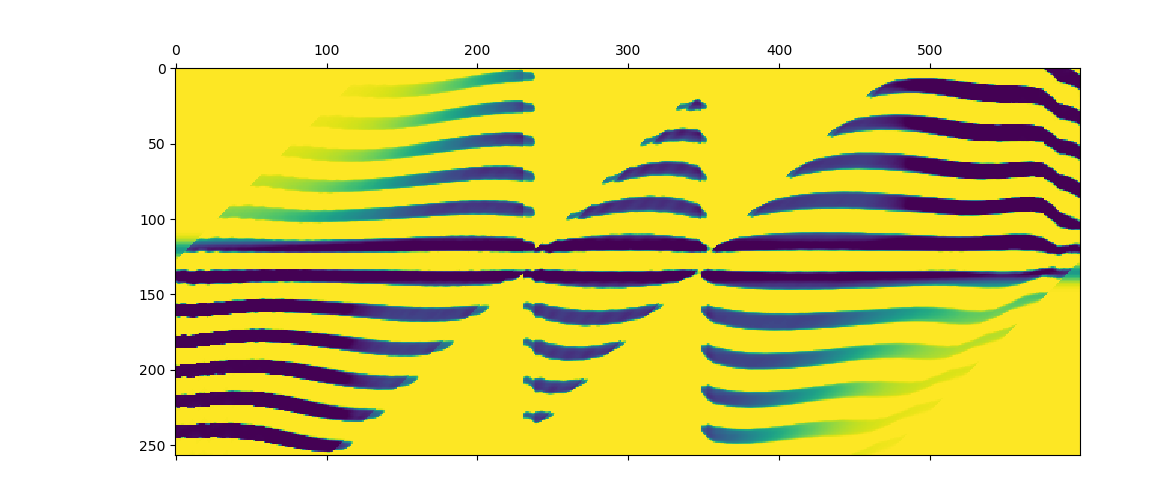

<IPython.core.display.Javascript object>


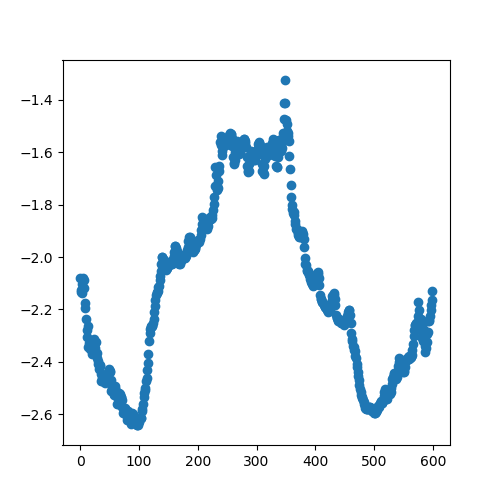

<IPython.core.display.Javascript object>


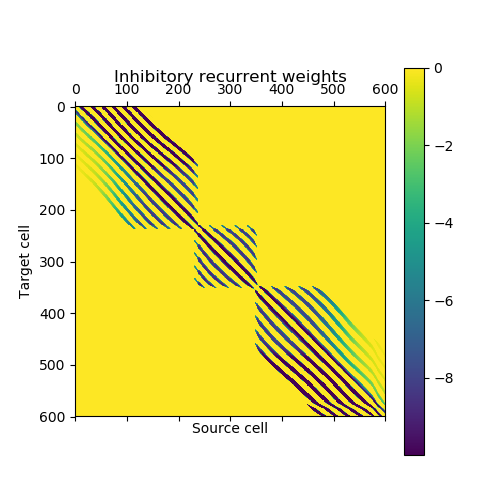

<IPython.core.display.Javascript object>


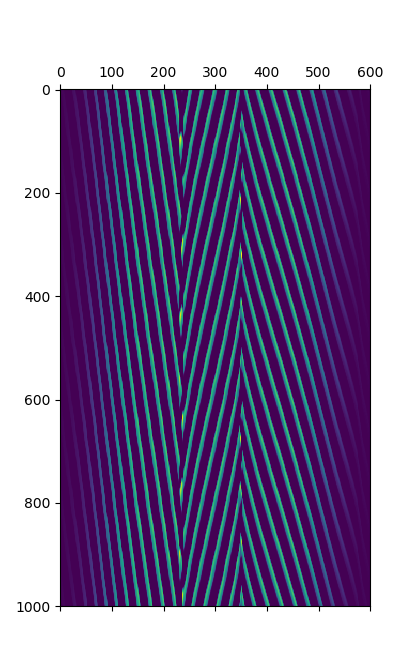

In [593]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(inhibGCN2.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.numX),
            torch.mean(inhibGCN2.inhibitoryWeights[0, :], dim=0))
plt.show()

weights = np.zeros((inhibGCN2.numX, inhibGCN2.numX))
stride = inhibGCN2.inhibitoryWeights.shape[-2]//2
for i in range(inhibGCN2.inhibitoryWeights.shape[-1]):
    lowerBound = max(i-stride, 0)
    upperBound = min(i + stride + 1, inhibGCN2.numX)
    weightUpperBound = min(stride - i  + inhibGCN2.numX, 2*stride+1)
    weightLowerBound = max(stride - i, 0)
    weights[i, lowerBound:upperBound] = inhibGCN2.inhibitoryWeights[0, weightLowerBound:weightUpperBound, i]

plt.matshow(weights)
plt.colorbar()
plt.title("Inhibitory recurrent weights")
plt.xlabel("Source cell")
plt.ylabel("Target cell")
plt.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(results[-1000:, :])
plt.show()

<IPython.core.display.Javascript object>


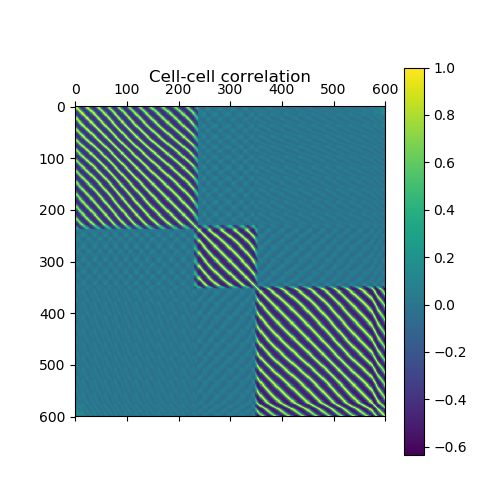

In [594]:
corrs = np.corrcoef(results[:], rowvar=False)
plt.matshow(corrs)
plt.colorbar()
plt.title("Cell-cell correlation")
plt.tight_layout()

<IPython.core.display.Javascript object>


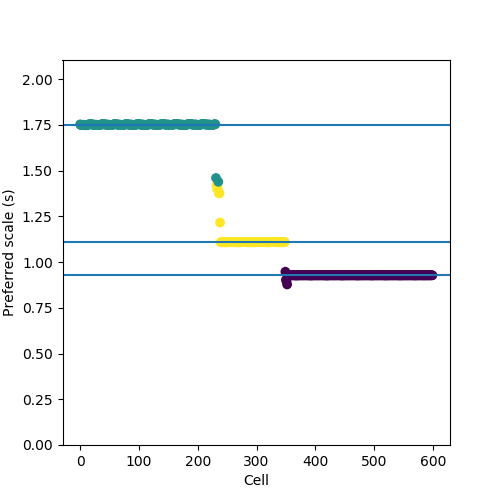

[1.7512727272727273, 1.1088138406537285, 0.9277358490566037]


<IPython.core.display.Javascript object>


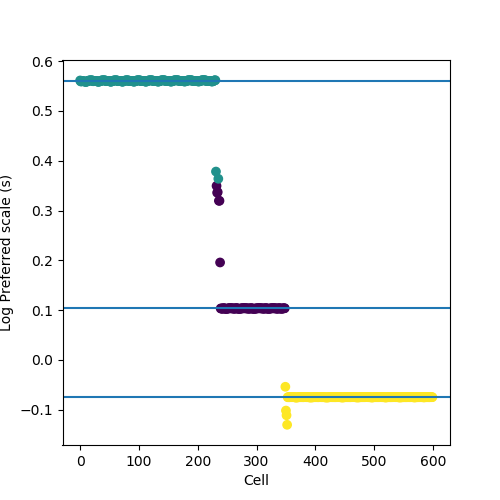

In [756]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(np.asarray(results[100:, :])/np.mean(np.asarray(results[100:, :]), axis=0, keepdims=True))/100.
fig = plt.figure()
ax = plt.gca()
clusters, scales = calculateModuleScales(activityScales, 3)
print(sorted(scales, reverse=True))
for scale in scales:
    plt.axhline(scale)
ax.scatter(np.arange(activityScales.shape[0]), (activityScales), c=clusters)
mod = 0.25
plt.xlabel("Cell")
plt.ylabel("Preferred scale (s)")
plt.ylim((0, 1.2*max(activityScales)))
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(np.asarray(results[100:, :])/np.mean(np.asarray(results[100:, :]), axis=0, keepdims=True))/100.
fig = plt.figure()
ax = plt.gca()
clusters, scales = calculateModuleScales(activityScales, 3)
scales = np.log(scales)
for scale in scales:
    plt.axhline(scale)
ax.scatter(np.arange(activityScales.shape[0]), np.log(activityScales), c=clusters)
mod = 0.25
plt.xlabel("Cell")
plt.ylabel("Log Preferred scale (s)")
plt.show()

In [846]:
inhibGCN2.placeWeightDecay = 100
inhibGCN2.learnFactorP = 1000
inhibGCN2.placeWeights.fill_(0.)

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [850]:
(results,
instResults,
histResults,
placeResults) = inhibGCN2.learn(20,
                              plotting=False,
                              logFreq=(0.01/inhibGCN.dt),
                              speed=1.,
                              preSimulateTime=5,
                              learnInhibitory=False,
                              learnExcitatory=False,
                              simulateTonicBoost=1.)

Starting run 0
Starting run 1
Starting run 2
Starting run 3
Starting run 4
Starting run 5
Starting run 6
Starting run 7
Starting run 8
Starting run 9
Starting run 10
Starting run 11
Starting run 12
Starting run 13
Starting run 14
Starting run 15
Starting run 16
Starting run 17
Starting run 18
Starting run 19


<IPython.core.display.Javascript object>


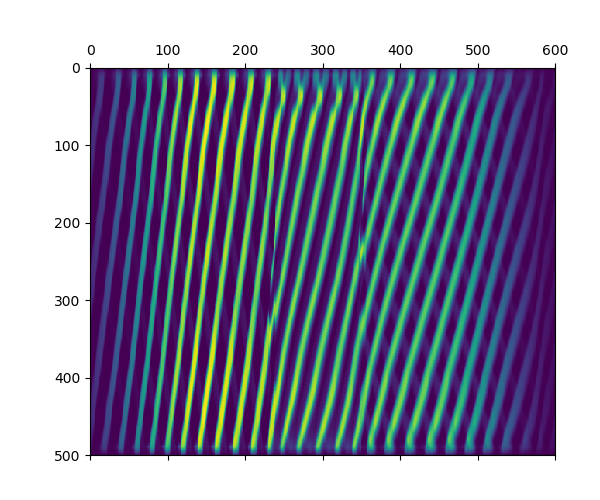

In [852]:
plt.matshow(torch.transpose(inhibGCN2.placeWeights, 0, 1))

<IPython.core.display.Javascript object>


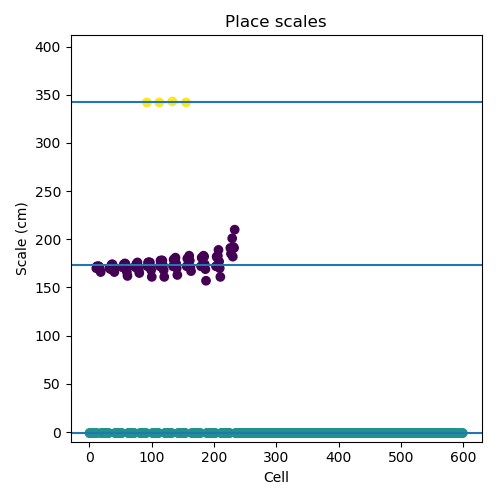

[342.0, 173.5, -1.0]


In [854]:
plt.rcParams['figure.figsize'] = [5, 5]
mat = torch.transpose(inhibGCN2.placeWeights, 0, 1).cpu().numpy()
activityScales = compute_scales(mat[50:-50, :]/np.mean(mat[50:-50, :]*3., axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
clusters, scales = calculateModuleScales(activityScales, 3)
print(sorted(scales, reverse=True))
for scale in scales:
    plt.axhline(scale)
ax.scatter(np.arange(activityScales.shape[0]), (activityScales), c=clusters)
mod = 0.25
plt.title("Place scales")
plt.xlabel("Cell")
plt.ylabel("Scale (cm)")
plt.ylim((-10, 1.2*max(activityScales)))

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


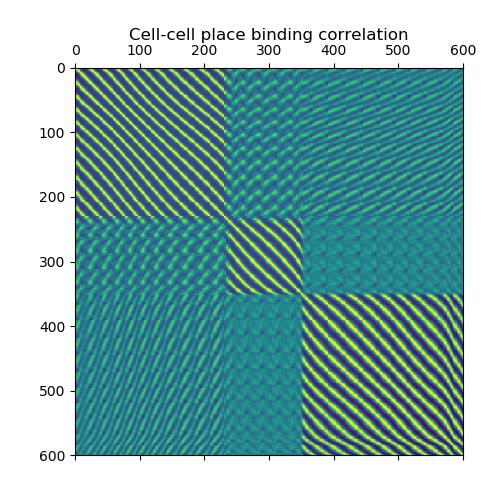

Text(0.5,1.05,'Cell-cell place binding correlation')

In [823]:
corrs = np.corrcoef(inhibGCN2.placeWeights, rowvar=True)
plt.matshow(corrs)
plt.title("Cell-cell place binding correlation")

In [735]:
import pickle as pkl
with open(os.getcwd() + "\\perfectmodel.pkl", "wb") as f:
    pkl.dump(inhibGCN2, f)

In [778]:
inhibGCN2.learnFactorE  /= 10.

In [762]:
inhibGCN.excitationMask.fill_(1.)

tensor([[[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.]]], device='cuda:0')

In [781]:
inhibGCN2.excitatoryWeights["s"].fill_(0.)
inhibGCN2.excitatoryWeights["n"].fill_(0.)
# inhibGCN.excitationMask = inhibGCN2.excitationMask
# inhibGCN.excitatoryKernel = inhibGCN2.excitatoryKernel

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]], device='cuda:0')

In [829]:
(results,
histResults,
instResults,
placeResults) = inhibGCN2.learn(2,
                                preSimulateTime=10.,
                                plotting=False,
                                logFreq=(0.01/inhibGCN.dt),
                                speed=1.,
                                learnInhibitory=False,
                                learnExcitatory=True,
                                learnPlace=False,
                                useExcitatory=True,
                                boosting=True,
                                learnStart=1.)

Starting run 0
Starting run 1


<IPython.core.display.Javascript object>


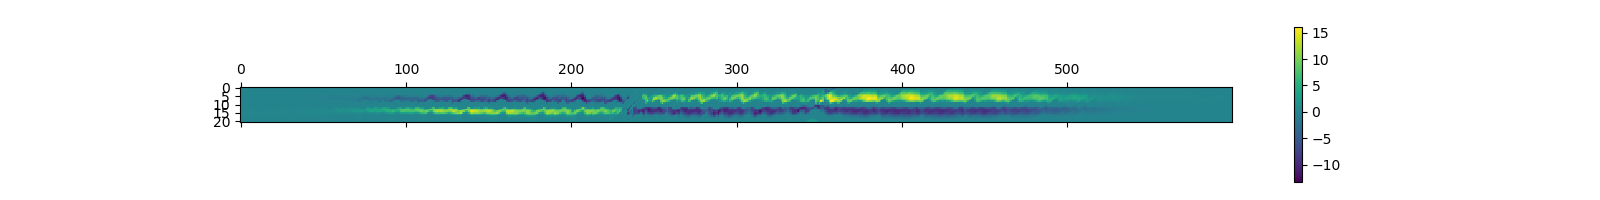

<IPython.core.display.Javascript object>


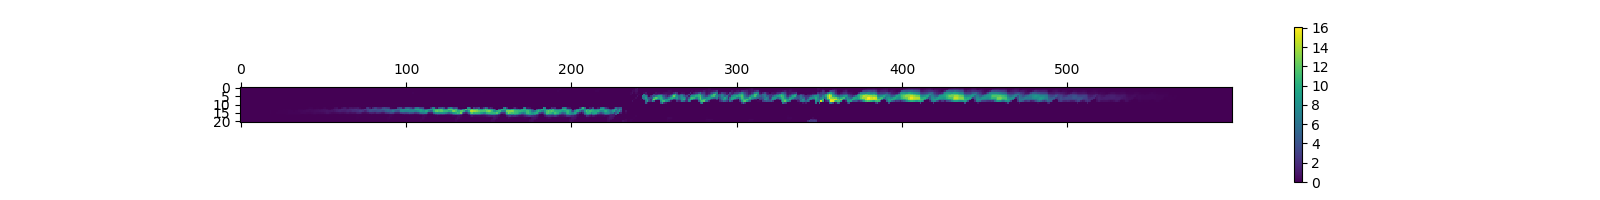

<IPython.core.display.Javascript object>


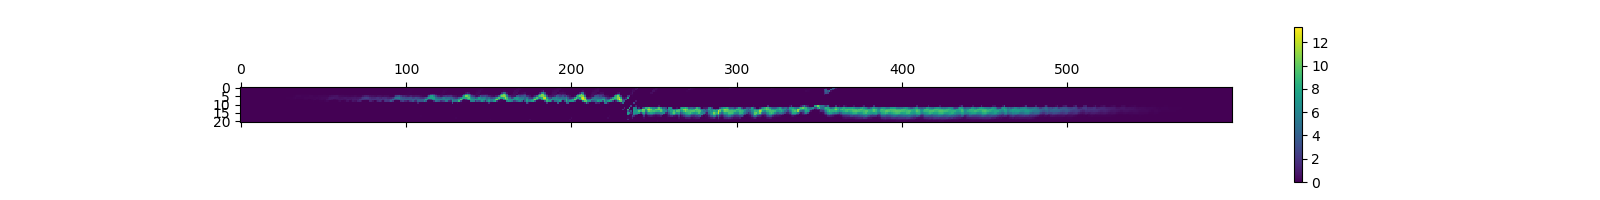

<IPython.core.display.Javascript object>


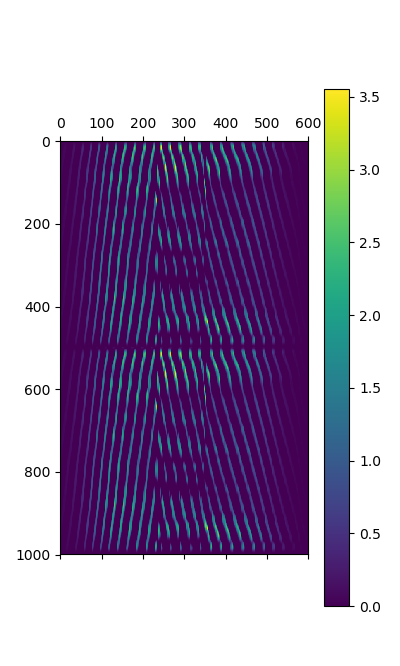

In [830]:
plt.matshow(inhibGCN2.excitatoryWeights["s"][0] - inhibGCN2.excitatoryWeights["n"][0])
plt.colorbar()
plt.matshow(inhibGCN2.excitatoryWeights["s"][0])
plt.colorbar()
plt.matshow(inhibGCN2.excitatoryWeights["n"][0])
plt.colorbar()
plt.matshow(results[-1000:])
plt.colorbar()

In [819]:
plt.rcParams['figure.figsize'] = [5, 5]
simresults, simhistResults, siminstResults = inhibGCN2.simulate(100,
                                                      logFreq=int(0.01/inhibGCN.dt),
                                                      startFrom = 0.,
                                                      vel=-1,
                                                      boosting=False)

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.49
At 8.5
At 8.51
At 8.52
At 8.53
At 8.540000000000001
At 8.55
At 8.56
At 8.57
At 8.58
At 8.59
At 8.6
At 8.61
At 8.620000000000001
At 8.63
At 8.64
At 8.65
At 8.66
At 8.67
At 8.68
At 8.69
At 8.700000000000001
At 8.71
At 8.72
At 8.73
At 8.74
At 8.75
At 8.76
At 8.77
At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.53
At 9.54000000

At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At 17.37
At 17.38
At 17.39
At 17.400000000000002
At 17.41
At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.54
At 17.55
At 17.56
At 17.57
At 17.580000000000002
At 17.59
At 17.6
At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000000002
At 17.75
At 17.76
At 17.77
At 17.78
At 17.79
At 17.8
At 17.81
At 17.82
At 17.830000000000002
At 17.84
At 17.85
At 17.86
At 17.87
At 17.88
At 17.89
At 17.900000000000002
At 17.91
At 17.92
At 17.93
At 17.94
At 17.95
At 17.96
At 17.97
At 17.98
At 17.990000000000002
At 18.0
At 18.01
At 18.02
At 18.03
At 18.04
At 18.05
A

At 25.650000000000002
At 25.66
At 25.67
At 25.68
At 25.69
At 25.7
At 25.71
At 25.72
At 25.73
At 25.740000000000002
At 25.75
At 25.76
At 25.77
At 25.78
At 25.79
At 25.8
At 25.810000000000002
At 25.82
At 25.830000000000002
At 25.84
At 25.85
At 25.86
At 25.87
At 25.88
At 25.89
At 25.900000000000002
At 25.91
At 25.92
At 25.93
At 25.94
At 25.95
At 25.96
At 25.97
At 25.98
At 25.990000000000002
At 26.0
At 26.01
At 26.02
At 26.03
At 26.04
At 26.05
At 26.060000000000002
At 26.07
At 26.080000000000002
At 26.09
At 26.1
At 26.11
At 26.12
At 26.13
At 26.14
At 26.150000000000002
At 26.16
At 26.17
At 26.18
At 26.19
At 26.2
At 26.21
At 26.22
At 26.23
At 26.240000000000002
At 26.25
At 26.26
At 26.27
At 26.28
At 26.29
At 26.3
At 26.310000000000002
At 26.32
At 26.330000000000002
At 26.34
At 26.35
At 26.36
At 26.37
At 26.38
At 26.39
At 26.400000000000002
At 26.41
At 26.42
At 26.43
At 26.44
At 26.45
At 26.46
At 26.47
At 26.48
At 26.490000000000002
At 26.5
At 26.51
At 26.52
At 26.53
At 26.54
At 26.55
At 26.

At 33.27
At 33.28
At 33.29
At 33.3
At 33.31
At 33.32
At 33.33
At 33.34
At 33.35
At 33.36
At 33.37
At 33.38
At 33.39
At 33.4
At 33.410000000000004
At 33.42
At 33.43
At 33.44
At 33.45
At 33.46
At 33.47
At 33.480000000000004
At 33.49
At 33.5
At 33.51
At 33.52
At 33.53
At 33.54
At 33.55
At 33.56
At 33.57
At 33.58
At 33.59
At 33.6
At 33.61
At 33.62
At 33.63
At 33.64
At 33.65
At 33.660000000000004
At 33.67
At 33.68
At 33.69
At 33.7
At 33.71
At 33.72
At 33.730000000000004
At 33.74
At 33.75
At 33.76
At 33.77
At 33.78
At 33.79
At 33.8
At 33.81
At 33.82
At 33.83
At 33.84
At 33.85
At 33.86
At 33.87
At 33.88
At 33.89
At 33.9
At 33.910000000000004
At 33.92
At 33.93
At 33.94
At 33.95
At 33.96
At 33.97
At 33.980000000000004
At 33.99
At 34.0
At 34.01
At 34.02
At 34.03
At 34.04
At 34.05
At 34.06
At 34.07
At 34.08
At 34.09
At 34.1
At 34.11
At 34.12
At 34.13
At 34.14
At 34.15
At 34.160000000000004
At 34.17
At 34.18
At 34.19
At 34.2
At 34.21
At 34.22
At 34.230000000000004
At 34.24
At 34.25
At 34.26
At 34.

At 41.7
At 41.71
At 41.72
At 41.730000000000004
At 41.74
At 41.75
At 41.76
At 41.77
At 41.78
At 41.79
At 41.800000000000004
At 41.81
At 41.82
At 41.83
At 41.84
At 41.85
At 41.86
At 41.87
At 41.88
At 41.89
At 41.9
At 41.910000000000004
At 41.92
At 41.93
At 41.94
At 41.95
At 41.96
At 41.97
At 41.980000000000004
At 41.99
At 42.0
At 42.01
At 42.02
At 42.03
At 42.04
At 42.050000000000004
At 42.06
At 42.07
At 42.08
At 42.09
At 42.1
At 42.11
At 42.12
At 42.13
At 42.14
At 42.15
At 42.160000000000004
At 42.17
At 42.18
At 42.19
At 42.2
At 42.21
At 42.22
At 42.230000000000004
At 42.24
At 42.25
At 42.26
At 42.27
At 42.28
At 42.29
At 42.300000000000004
At 42.31
At 42.32
At 42.33
At 42.34
At 42.35
At 42.36
At 42.37
At 42.38
At 42.39
At 42.4
At 42.410000000000004
At 42.42
At 42.43
At 42.44
At 42.45
At 42.46
At 42.47
At 42.480000000000004
At 42.49
At 42.5
At 42.51
At 42.52
At 42.53
At 42.54
At 42.550000000000004
At 42.56
At 42.57
At 42.58
At 42.59
At 42.6
At 42.61
At 42.62
At 42.63
At 42.64
At 42.65
A

At 50.300000000000004
At 50.31
At 50.32
At 50.33
At 50.34
At 50.35
At 50.36
At 50.370000000000005
At 50.38
At 50.39
At 50.4
At 50.410000000000004
At 50.42
At 50.43
At 50.44
At 50.45
At 50.46
At 50.47
At 50.480000000000004
At 50.49
At 50.5
At 50.51
At 50.52
At 50.53
At 50.54
At 50.550000000000004
At 50.56
At 50.57
At 50.58
At 50.59
At 50.6
At 50.61
At 50.620000000000005
At 50.63
At 50.64
At 50.65
At 50.660000000000004
At 50.67
At 50.68
At 50.69
At 50.7
At 50.71
At 50.72
At 50.730000000000004
At 50.74
At 50.75
At 50.76
At 50.77
At 50.78
At 50.79
At 50.800000000000004
At 50.81
At 50.82
At 50.83
At 50.84
At 50.85
At 50.86
At 50.870000000000005
At 50.88
At 50.89
At 50.9
At 50.910000000000004
At 50.92
At 50.93
At 50.94
At 50.95
At 50.96
At 50.97
At 50.980000000000004
At 50.99
At 51.0
At 51.01
At 51.02
At 51.03
At 51.04
At 51.050000000000004
At 51.06
At 51.07
At 51.08
At 51.09
At 51.1
At 51.11
At 51.120000000000005
At 51.13
At 51.14
At 51.15
At 51.160000000000004
At 51.17
At 51.18
At 51.19
At

At 57.95
At 57.96
At 57.97
At 57.980000000000004
At 57.99
At 58.0
At 58.01
At 58.02
At 58.03
At 58.04
At 58.050000000000004
At 58.06
At 58.07
At 58.08
At 58.09
At 58.1
At 58.11
At 58.120000000000005
At 58.13
At 58.14
At 58.15
At 58.160000000000004
At 58.17
At 58.18
At 58.19
At 58.2
At 58.21
At 58.22
At 58.230000000000004
At 58.24
At 58.25
At 58.26
At 58.27
At 58.28
At 58.29
At 58.300000000000004
At 58.31
At 58.32
At 58.33
At 58.34
At 58.35
At 58.36
At 58.370000000000005
At 58.38
At 58.39
At 58.4
At 58.410000000000004
At 58.42
At 58.43
At 58.44
At 58.45
At 58.46
At 58.47
At 58.480000000000004
At 58.49
At 58.5
At 58.51
At 58.52
At 58.53
At 58.54
At 58.550000000000004
At 58.56
At 58.57
At 58.58
At 58.59
At 58.6
At 58.61
At 58.620000000000005
At 58.63
At 58.64
At 58.65
At 58.660000000000004
At 58.67
At 58.68
At 58.69
At 58.7
At 58.71
At 58.72
At 58.730000000000004
At 58.74
At 58.75
At 58.76
At 58.77
At 58.78
At 58.79
At 58.800000000000004
At 58.81
At 58.82
At 58.83
At 58.84
At 58.85
At 58.

At 65.47
At 65.48
At 65.49
At 65.5
At 65.51
At 65.52
At 65.53
At 65.54
At 65.55
At 65.56
At 65.57000000000001
At 65.58
At 65.59
At 65.6
At 65.61
At 65.62
At 65.63
At 65.64
At 65.65
At 65.66
At 65.67
At 65.68
At 65.69
At 65.7
At 65.71000000000001
At 65.72
At 65.73
At 65.74
At 65.75
At 65.76
At 65.77
At 65.78
At 65.79
At 65.8
At 65.81
At 65.82000000000001
At 65.83
At 65.84
At 65.85
At 65.86
At 65.87
At 65.88
At 65.89
At 65.9
At 65.91
At 65.92
At 65.93
At 65.94
At 65.95
At 65.96000000000001
At 65.97
At 65.98
At 65.99
At 66.0
At 66.01
At 66.02
At 66.03
At 66.04
At 66.05
At 66.06
At 66.07000000000001
At 66.08
At 66.09
At 66.1
At 66.11
At 66.12
At 66.13
At 66.14
At 66.15
At 66.16
At 66.17
At 66.18
At 66.19
At 66.2
At 66.21000000000001
At 66.22
At 66.23
At 66.24
At 66.25
At 66.26
At 66.27
At 66.28
At 66.29
At 66.3
At 66.31
At 66.32000000000001
At 66.33
At 66.34
At 66.35
At 66.36
At 66.37
At 66.38
At 66.39
At 66.4
At 66.41
At 66.42
At 66.43
At 66.44
At 66.45
At 66.46000000000001
At 66.47
At 66

At 73.96000000000001
At 73.97
At 73.98
At 73.99
At 74.0
At 74.01
At 74.02
At 74.03
At 74.04
At 74.05
At 74.06
At 74.07000000000001
At 74.08
At 74.09
At 74.10000000000001
At 74.11
At 74.12
At 74.13
At 74.14
At 74.15
At 74.16
At 74.17
At 74.18
At 74.19
At 74.2
At 74.21000000000001
At 74.22
At 74.23
At 74.24
At 74.25
At 74.26
At 74.27
At 74.28
At 74.29
At 74.3
At 74.31
At 74.32000000000001
At 74.33
At 74.34
At 74.35000000000001
At 74.36
At 74.37
At 74.38
At 74.39
At 74.4
At 74.41
At 74.42
At 74.43
At 74.44
At 74.45
At 74.46000000000001
At 74.47
At 74.48
At 74.49
At 74.5
At 74.51
At 74.52
At 74.53
At 74.54
At 74.55
At 74.56
At 74.57000000000001
At 74.58
At 74.59
At 74.60000000000001
At 74.61
At 74.62
At 74.63
At 74.64
At 74.65
At 74.66
At 74.67
At 74.68
At 74.69
At 74.7
At 74.71000000000001
At 74.72
At 74.73
At 74.74
At 74.75
At 74.76
At 74.77
At 74.78
At 74.79
At 74.8
At 74.81
At 74.82000000000001
At 74.83
At 74.84
At 74.85000000000001
At 74.86
At 74.87
At 74.88
At 74.89
At 74.9
At 74.91


At 82.37
At 82.38
At 82.39
At 82.4
At 82.41
At 82.42
At 82.43
At 82.44
At 82.45
At 82.46000000000001
At 82.47
At 82.48
At 82.49
At 82.5
At 82.51
At 82.52
At 82.53
At 82.54
At 82.55
At 82.56
At 82.57000000000001
At 82.58
At 82.59
At 82.60000000000001
At 82.61
At 82.62
At 82.63
At 82.64
At 82.65
At 82.66
At 82.67
At 82.68
At 82.69
At 82.7
At 82.71000000000001
At 82.72
At 82.73
At 82.74
At 82.75
At 82.76
At 82.77
At 82.78
At 82.79
At 82.8
At 82.81
At 82.82000000000001
At 82.83
At 82.84
At 82.85000000000001
At 82.86
At 82.87
At 82.88
At 82.89
At 82.9
At 82.91
At 82.92
At 82.93
At 82.94
At 82.95
At 82.96000000000001
At 82.97
At 82.98
At 82.99
At 83.0
At 83.01
At 83.02
At 83.03
At 83.04
At 83.05
At 83.06
At 83.07000000000001
At 83.08
At 83.09
At 83.10000000000001
At 83.11
At 83.12
At 83.13
At 83.14
At 83.15
At 83.16
At 83.17
At 83.18
At 83.19
At 83.2
At 83.21000000000001
At 83.22
At 83.23
At 83.24
At 83.25
At 83.26
At 83.27
At 83.28
At 83.29
At 83.3
At 83.31
At 83.32000000000001
At 83.33
At 

At 90.53
At 90.54
At 90.55
At 90.56
At 90.57000000000001
At 90.58
At 90.59
At 90.60000000000001
At 90.61
At 90.62
At 90.63
At 90.64
At 90.65
At 90.66
At 90.67
At 90.68
At 90.69
At 90.7
At 90.71000000000001
At 90.72
At 90.73
At 90.74
At 90.75
At 90.76
At 90.77
At 90.78
At 90.79
At 90.8
At 90.81
At 90.82000000000001
At 90.83
At 90.84
At 90.85000000000001
At 90.86
At 90.87
At 90.88
At 90.89
At 90.9
At 90.91
At 90.92
At 90.93
At 90.94
At 90.95
At 90.96000000000001
At 90.97
At 90.98
At 90.99
At 91.0
At 91.01
At 91.02
At 91.03
At 91.04
At 91.05
At 91.06
At 91.07000000000001
At 91.08
At 91.09
At 91.10000000000001
At 91.11
At 91.12
At 91.13
At 91.14
At 91.15
At 91.16
At 91.17
At 91.18
At 91.19
At 91.2
At 91.21000000000001
At 91.22
At 91.23
At 91.24
At 91.25
At 91.26
At 91.27
At 91.28
At 91.29
At 91.3
At 91.31
At 91.32000000000001
At 91.33
At 91.34
At 91.35000000000001
At 91.36
At 91.37
At 91.38
At 91.39
At 91.4
At 91.41
At 91.42
At 91.43
At 91.44
At 91.45
At 91.46000000000001
At 91.47
At 91.48

At 98.67
At 98.68
At 98.69
At 98.7
At 98.71000000000001
At 98.72
At 98.73
At 98.74000000000001
At 98.75
At 98.76
At 98.77
At 98.78
At 98.79
At 98.8
At 98.81
At 98.82000000000001
At 98.83
At 98.84
At 98.85000000000001
At 98.86
At 98.87
At 98.88
At 98.89
At 98.9
At 98.91
At 98.92
At 98.93
At 98.94
At 98.95
At 98.96000000000001
At 98.97
At 98.98
At 98.99000000000001
At 99.0
At 99.01
At 99.02
At 99.03
At 99.04
At 99.05
At 99.06
At 99.07000000000001
At 99.08
At 99.09
At 99.10000000000001
At 99.11
At 99.12
At 99.13
At 99.14
At 99.15
At 99.16
At 99.17
At 99.18
At 99.19
At 99.2
At 99.21000000000001
At 99.22
At 99.23
At 99.24000000000001
At 99.25
At 99.26
At 99.27
At 99.28
At 99.29
At 99.3
At 99.31
At 99.32000000000001
At 99.33
At 99.34
At 99.35000000000001
At 99.36
At 99.37
At 99.38
At 99.39
At 99.4
At 99.41
At 99.42
At 99.43
At 99.44
At 99.45
At 99.46000000000001
At 99.47
At 99.48
At 99.49000000000001
At 99.5
At 99.51
At 99.52
At 99.53
At 99.54
At 99.55
At 99.56
At 99.57000000000001
At 99.58


<IPython.core.display.Javascript object>


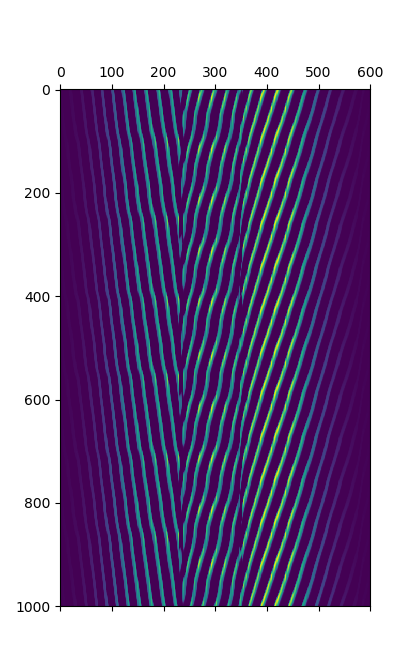

In [820]:
plt.matshow(simresults[-1000:, :])

<IPython.core.display.Javascript object>


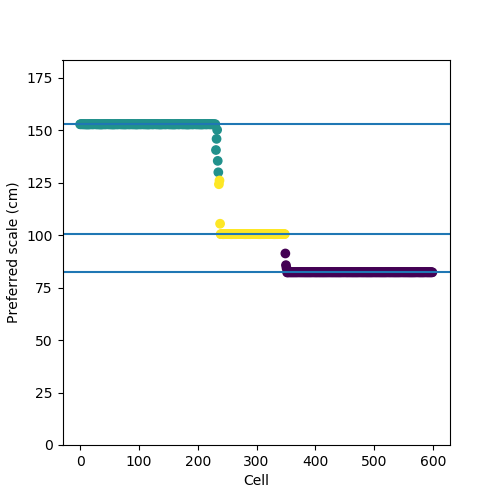

[152.77777777777777, 100.44329896907216, 82.26890756302521]


In [821]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(np.asarray(simresults[100:, :])/np.mean(np.asarray(simresults[100:, :]), axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
clusters, scales = calculateModuleScales(activityScales, 3)
print(sorted(scales, reverse=True))
for scale in scales:
    plt.axhline(scale)
ax.scatter(np.arange(activityScales.shape[0]), (activityScales), c=clusters)
mod = 0.25
plt.xlabel("Cell")
plt.ylabel("Preferred scale (cm)")
plt.ylim((0, 1.2*max(activityScales)))
plt.show()

In [1095]:
torch.sum(inhibGCN.excitatoryWeights["s"][0] +
                                      inhibGCN.excitatoryWeights["n"][0],
                                      dim = 0).shape

torch.Size([300])

In [1098]:
oldEnvelope=inhibGCN.envelope

In [1110]:
inhibGCN.envelope = torch.min(torch.sum(inhibGCN.excitatoryWeights["s"][0] +
                                      inhibGCN.excitatoryWeights["n"][0],
                                      dim = 0)/75, inhibGCN.zero+1)

<IPython.core.display.Javascript object>


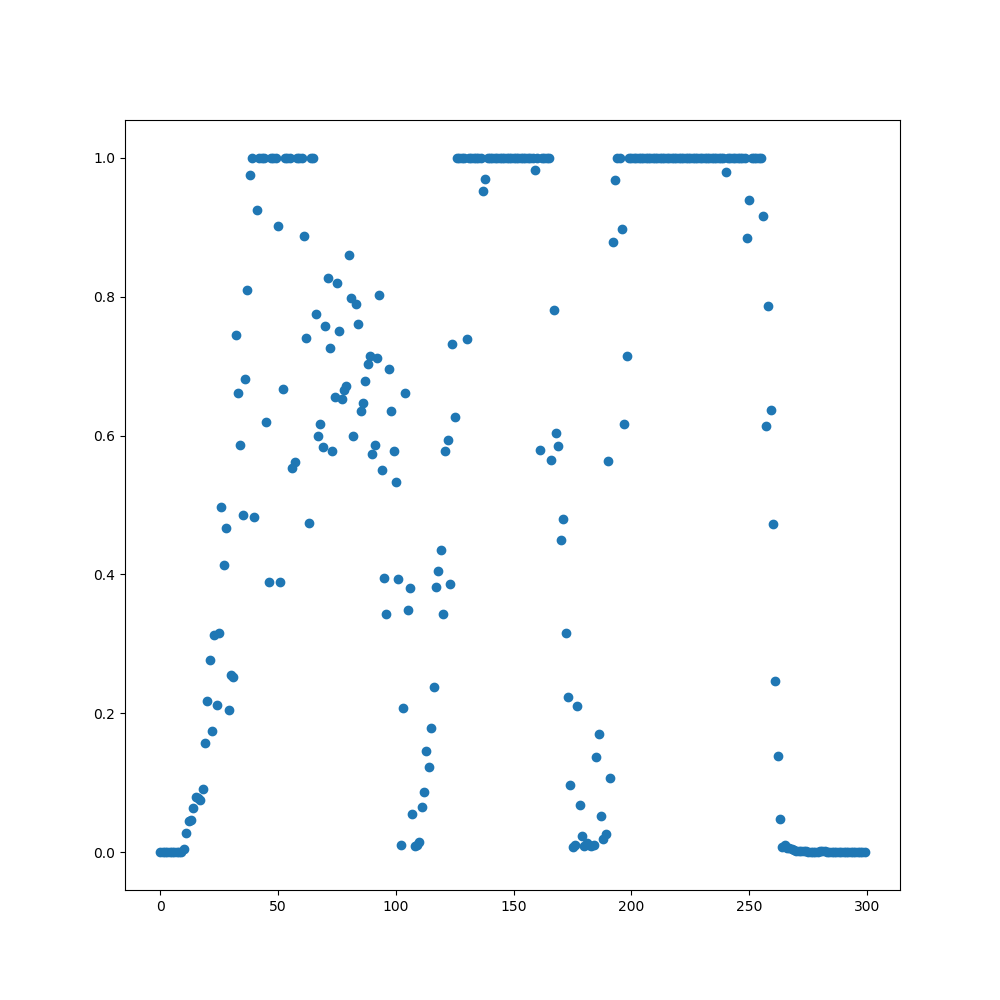

In [1111]:
plt.figure()
plt.scatter(np.arange(inhibGCN.envelope.shape[0]), inhibGCN.envelope)
plt.show()

<IPython.core.display.Javascript object>


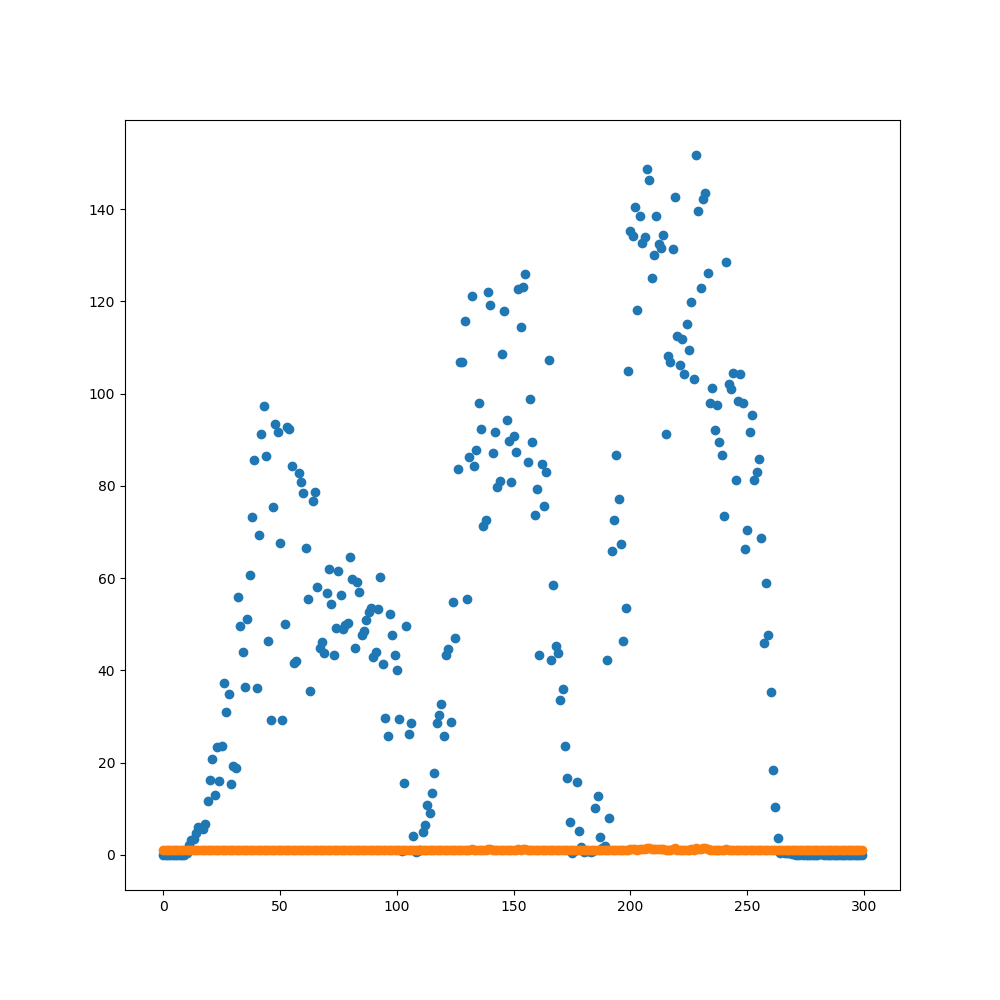

In [1097]:
plt.figure()
plt.scatter(np.arange(300), torch.sum(inhibGCN.excitatoryWeights["s"][0] +
                                      inhibGCN.excitatoryWeights["n"][0],
                                      dim = 0))
plt.show()

<IPython.core.display.Javascript object>


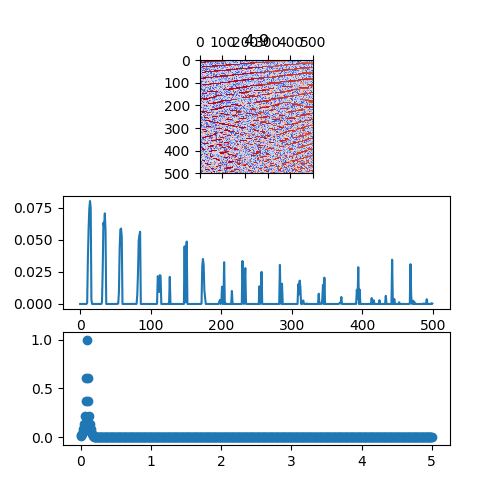

Starting run 0


UnboundLocalError: local variable 'output' referenced before assignment

In [61]:
plt.rcParams['figure.figsize'] = [5, 5]
inhibGCN.learn(1, plotting=True, plotInterval=10, speed=1., preSimulateTime=50.)

<IPython.core.display.Javascript object>


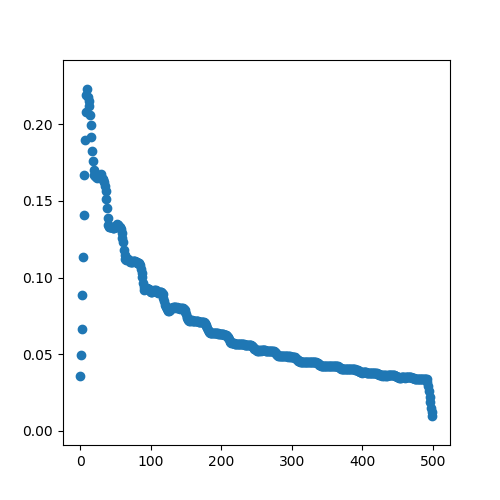

In [17]:
plt.figure()
plt.scatter(np.arange(inhibGCN.longHistory.shape[-1]), inhibGCN.longHistory[0, 0])
plt.show()

In [ ]:
alphas = np.asarray([20,
                    10,
                    15,
                    5,
                    20,
                    20,
                    10,
                    15,
                    40,
                    40,
                    10,
                    5,
                    5,
                    40,
                    15,
                    0.5,
                    5.,
                    2.,
                    1.,
                    1.,
                    ])

boostEffects = np.asarray([100,
                          200,
                          200,
                          200,
                          200,
                          400,
                          100,
                          100,
                          100,
                          400,
                          400,
                          100,
                          400,
                          200,
                          400,
                          50,
                          50.,
                          50.,
                          50.,
                          400.,
                          ])

scales = np.asarray([43.75,
                    37.3,
                    30,
                    60,
                    21.6,
                    14.5,
                    74,
                    55,
                    33.5,
                    9,
                    23,
                    106.5,
                    34.5,
                    15,
                    17.5,
                    700,
                    150.,
                    282.,
                    400.,
                    103.,
                    ])


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(1./(alphas)**.7,
                       1./(boostEffects)**.7,
                       scales,
                       linewidth=0,
                       #cmap=cm.coolwarm,
                       antialiased=True)


ax.set_xlabel("Moving average constant")
ax.set_ylabel("Boost effect")
ax.set_zlabel("Scale")
plt.title("Scale vs. boosting")

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


ax.view_init(15, 210)
plt.savefig("ScaleSurface.png", dpi = 250)
plt.draw()
plt.show()

In [ ]:
combinations = (1./(alphas/0.001) * 1./boostEffects)**0.7

plt.figure()
fit = np.polyfit(combinations,scales,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.scatter(combinations, scales)
plt.plot(combinations, fit_fn(combinations), '--k',
         label = "y = {0:4.3f}x + {1:4.3f}".format(fit_fn[1], fit_fn[0]))
plt.legend(loc="best")
plt.show()

In [ ]:
weights = torch.transpose(GCN.placeWeights, 0, 1).cpu().numpy()
placeScales = compute_scales(weights[:, :]/np.max(weights[:, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(placeScales.shape[0]), placeScales)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.gca()
smoothed = smooth(placeScales,window_len=5, window="flat")
ax.scatter(np.arange(smoothed.shape[0]), smoothed)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Scales')
ax1.set_ylabel('Scale (cm)', color=color)
ax1.scatter(np.arange(GCN.numX), 1./placeScales, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Boost effect (negative square root)', color=color)  # we already handled the x-label with ax1
ax2.scatter(np.arange(GCN.numX), np.power(GCN.boostEffect, 1/2.), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [ ]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
np.min(results)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
createMovie(results[-1000:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", .01)

<video controls src="./test.mp4" />